In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
import seaborn as sns
from scipy.stats import qmc, norm

In [2]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_excel('data/MK-6070-full-v2.xlsx',sheet_name = 0)
#df = pd.read_csv('data/MK6070-revised.csv')
df.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df.columns]
print(len(df))
df.head()

124


,Sample_name,Protein_concentration,Surfactant_concentration,Temperature,Time_M_,If_10mM_L_Met,pH,RCE_LMW,RCE_Main,RCE_HMW,SEC_HMW,SEC_Monomer,SEC_LMW
0,MK-6070(1)-PS20(0.02) T0,1,0.02,5,0,N,5.0,3.5,96.5,ND,1.9,97.4,0.6
1,MK-6070(1)-PS20(0.1) T0,1,0.10,5,0,N,5.0,2.4,97.6,ND,1.7,97.7,0.6
2,"MK-6070(1)-PS20(0.02), 10 mM L-Met T0",1,0.02,5,0,Y,5.0,2.6,97.4,ND,2.1,97.3,0.6
3,MK-6070(1)-PS20(0.05) T0,1,0.05,5,0,N,5.0,2.5,97.5,ND,2.0,97.5,0.5
4,MK-6070(1)-PS20(0.02) T0,1,0.02,25,0,N,5.0,3.5,96.5,ND,1.9,97.4,0.6


In [3]:
cols_feature = ['Protein_concentration','Surfactant_concentration','Temperature',
                'Time_M_','If_10mM_L_Met','pH']
#cols_target = ['delta_RCE_LMW','delta_SEC_HMW']
cols_target = ['RCE_LMW','SEC_HMW']
#cols_cate = ['Time_M_','If_10mM_L_Met']
#cols_cate = ['Temperature','If_10mM_L_Met','Time_M_']
cols_cate = ['Temperature','If_10mM_L_Met'] #treat Time_M_ as a continous variable
#cols_task = ['Time_M_']

In [4]:
df_x = df[cols_feature]

from sklearn.preprocessing import LabelEncoder
for x_name in cols_cate:
    lab = LabelEncoder()
    df_x[x_name] = lab.fit_transform(df_x[x_name])

"""
#convert Buffer column to labels
for x_name in cols_cate:
    labels, categories = factorize(df_x[x_name])
    df_x[x_name+"_label"] = labels
    df_x.drop([x_name],axis = 1,inplace=True)

t_labels, t_categories = factorize(df[cols_task[0]])
df_x['task_ind'] = t_labels

df_x.drop(cols_task,axis = 1,inplace=True)
"""
df_x.head()

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/4097459740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[x_name] = lab.fit_transform(df_x[x_name])
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/4097459740.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x[x_name] = lab.fit_transform(df_x[x_name])


,Protein_concentration,Surfactant_concentration,Temperature,Time_M_,If_10mM_L_Met,pH
0,1,0.02,0,0,0,5.0
1,1,0.10,0,0,0,5.0
2,1,0.02,0,0,1,5.0
3,1,0.05,0,0,0,5.0
4,1,0.02,1,0,0,5.0


### Descriptive analysis on feature space

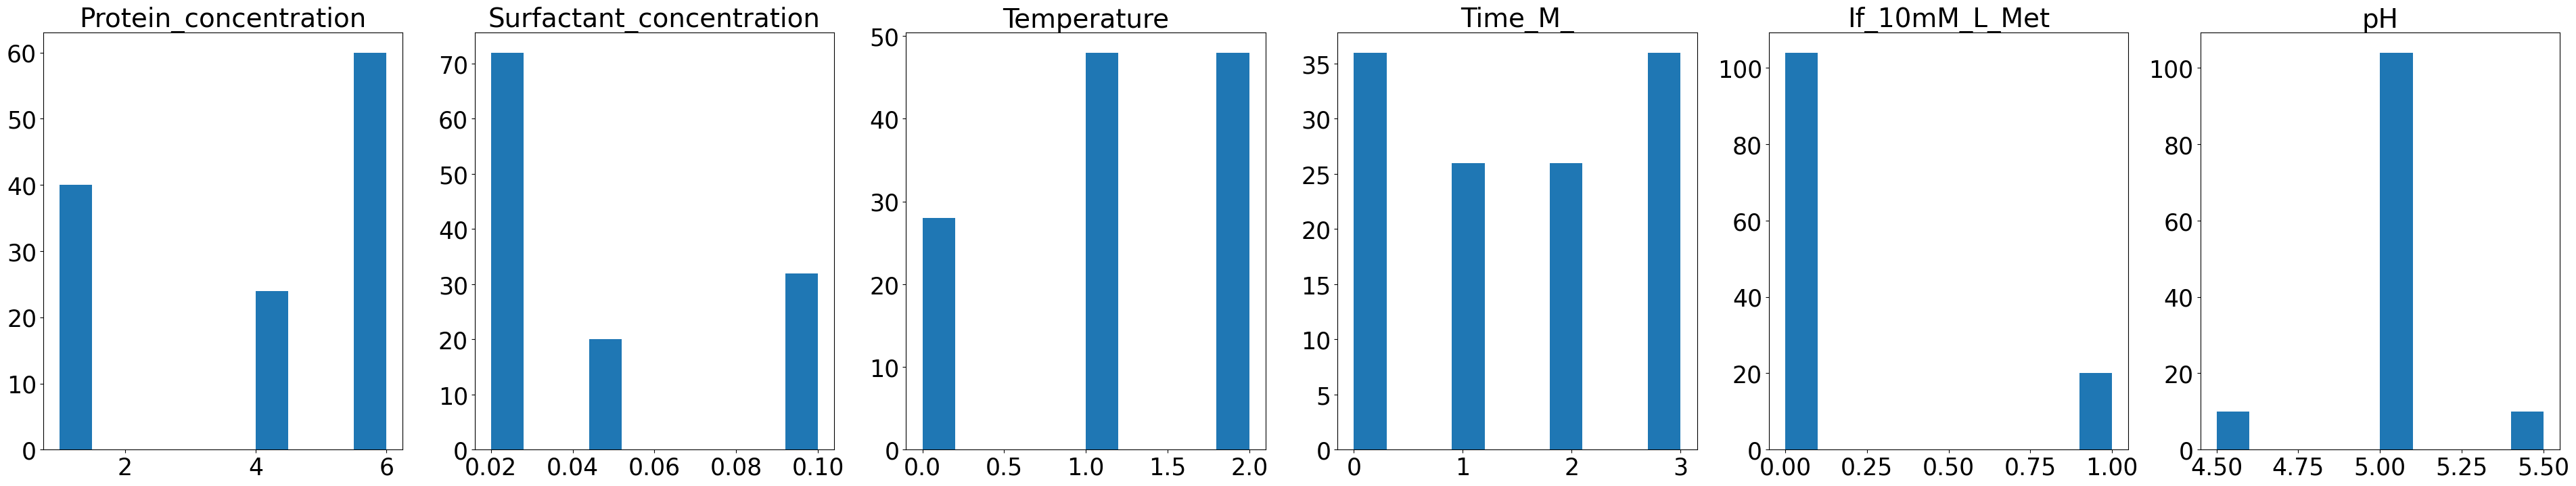

In [37]:
#f = plt.figure(figsize=(25, 25))
f,axes = plt.subplots(nrows = 1,ncols = df_x.shape[1],figsize=(6*8,1*8))

for i,col in enumerate(df_x.columns):
    axes[i].hist(df_x[col])
    axes[i].set_title(col,fontsize = 28)
    axes[i].tick_params(axis='both', which='major', labelsize=25)


In [ ]:
"""
#onehot encoding
df_x = pd.get_dummies(df_x, columns = cols_cate)
#print(total_df.head())
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
#df_x.drop(cols_cate,axis = 1,inplace = True)
#convert boolean True False to 0 1
bool_cols = df_x.select_dtypes(include='bool').columns
df_x[bool_cols] = df_x[bool_cols].astype(int)
print(df_x.head())
"""

In [5]:
df_y = df[cols_target]

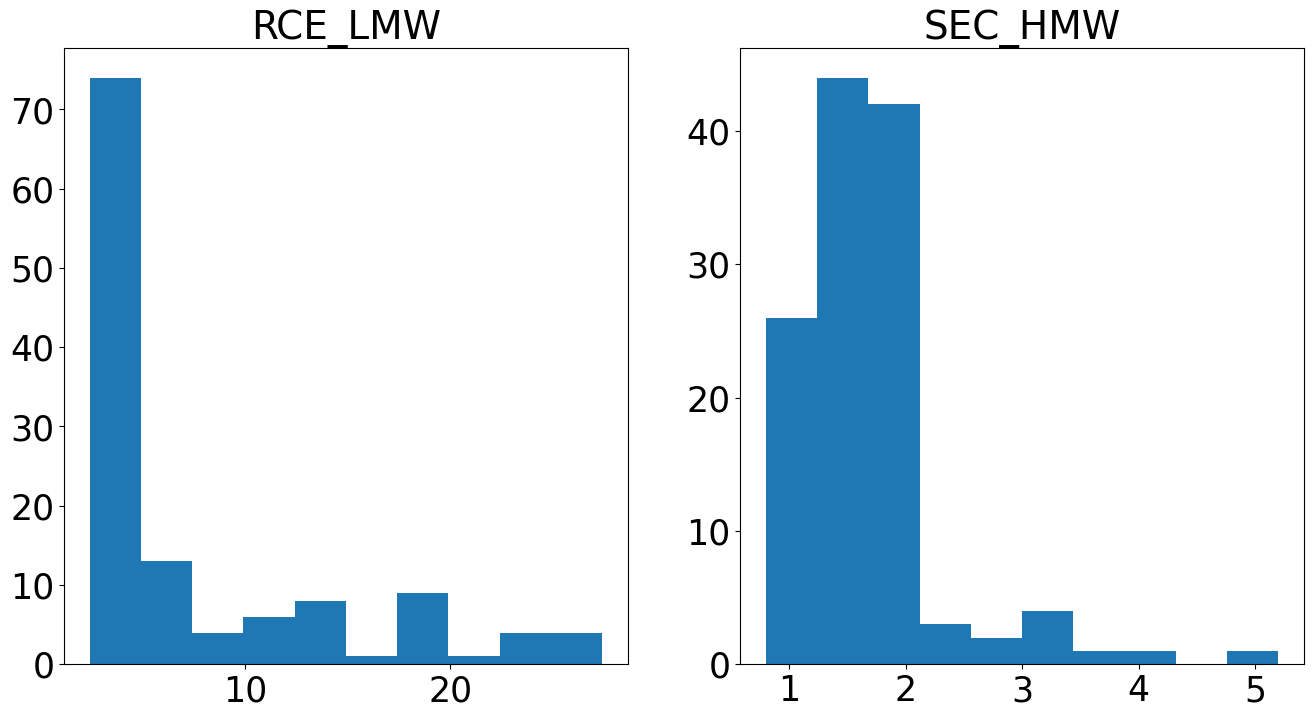

In [38]:
f,axes = plt.subplots(nrows = 1,ncols = df_y.shape[1],figsize=(2*8,1*8))
for i,col in enumerate(df_y.columns):
    axes[i].hist(df_y[col])
    axes[i].set_title(col,fontsize = 28)
    axes[i].tick_params(axis='both', which='major', labelsize=25)

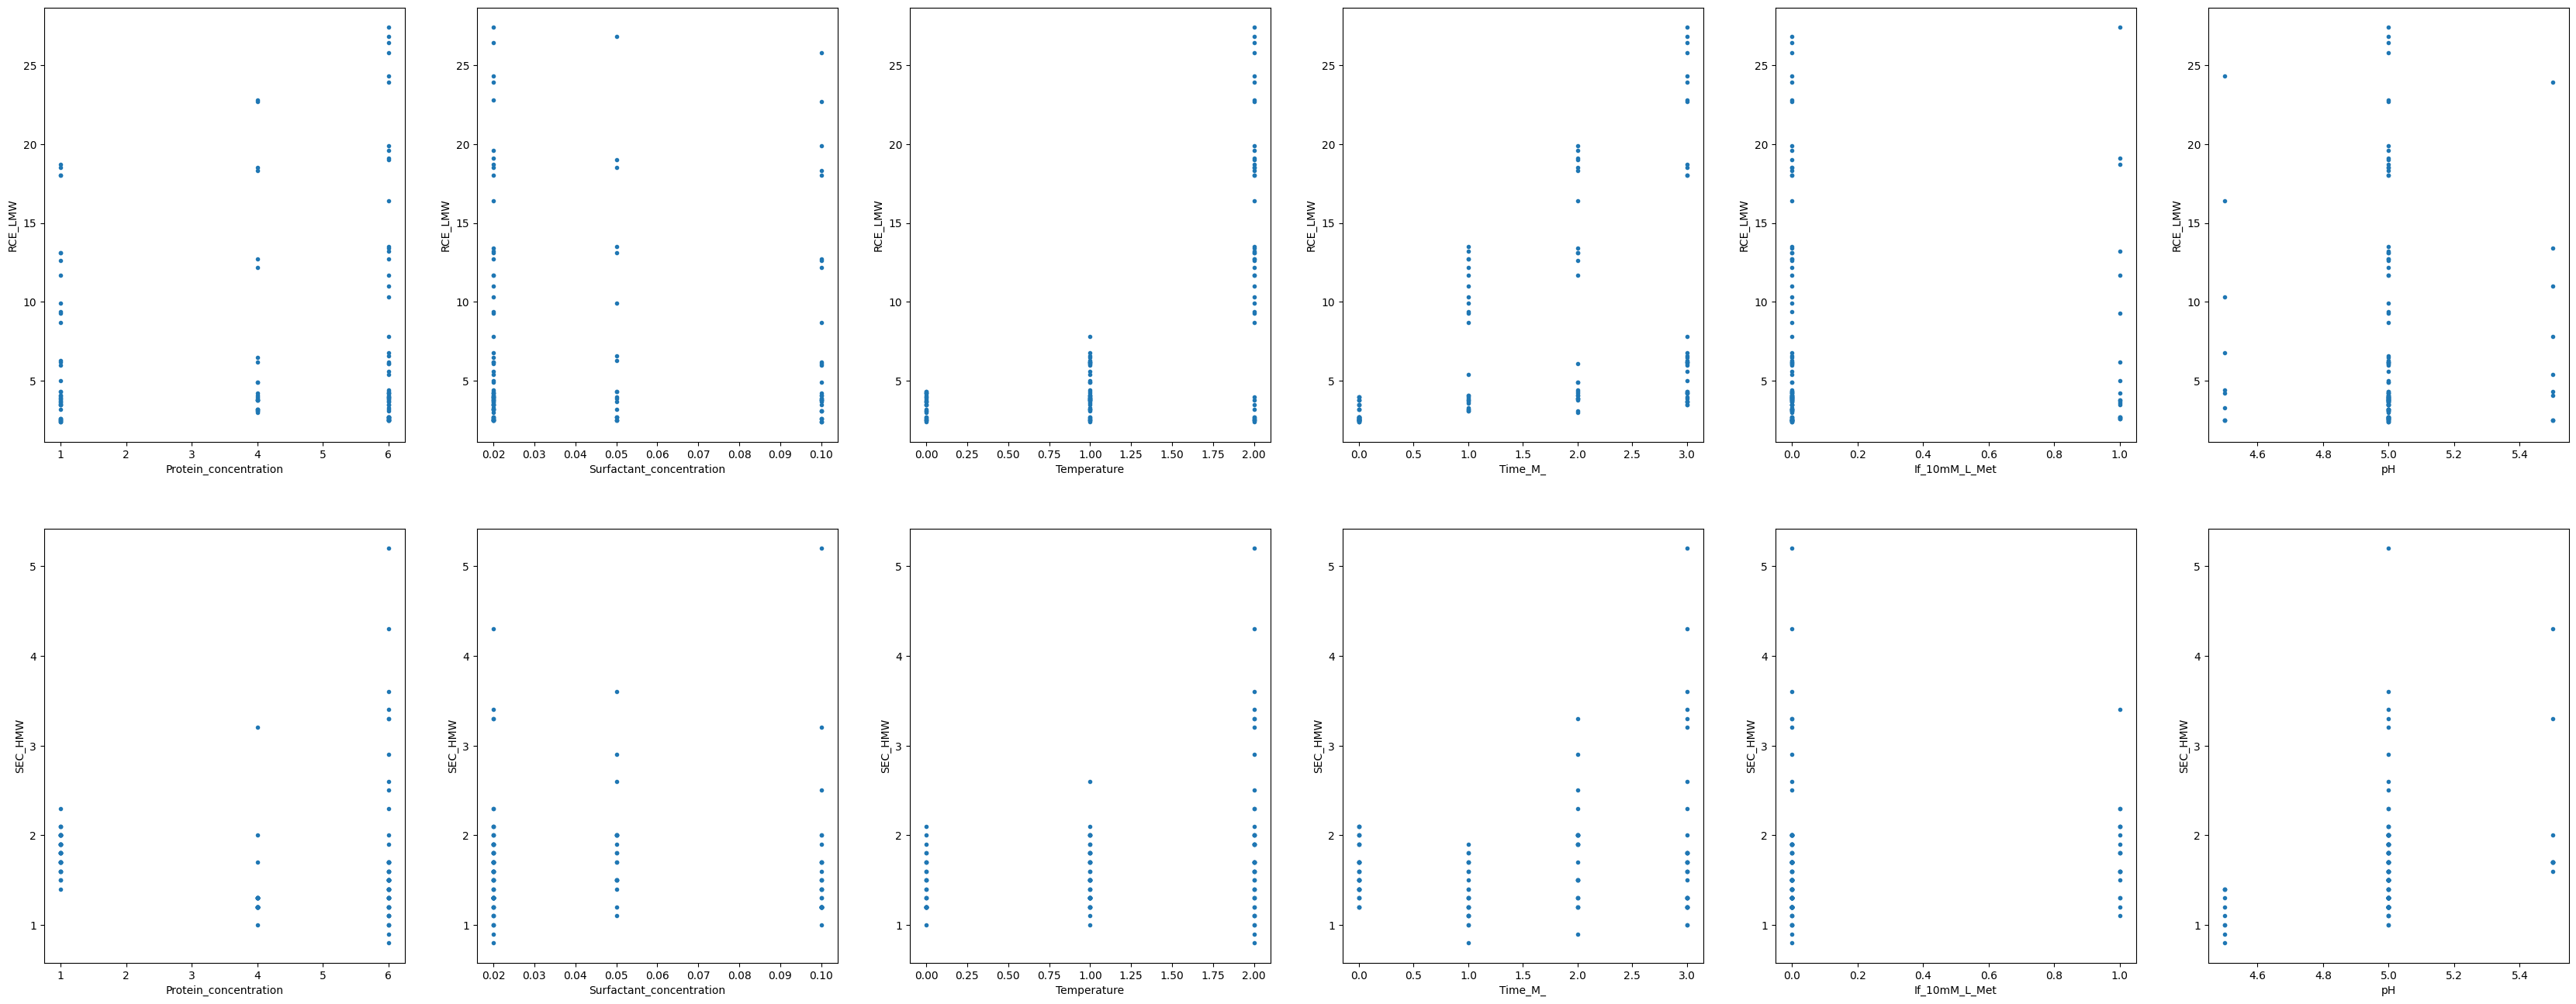

In [8]:
f,axes = plt.subplots(nrows = len(cols_target),ncols = df_x.shape[1],figsize=(6*7,2*8))
for j in range(len(cols_target)):
    for i,col in enumerate(df_x.columns):
        df_xy = pd.concat([df_x[col],df_y[cols_target[j]]],axis = 1)
        df_xy.sort_values(by = [col],inplace= True)
        axes[j][i].plot(df_xy[col],df_xy[cols_target[j]],marker = '.',linestyle='none')
        #axes[j][i].set_title(col)
        axes[j][i].set_xlabel(col)
        axes[j][i].set_ylabel(cols_target[j])

In [6]:
ls_model = ['rf','simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'simpleGP'
x_scale_option = 'x-minmax'
y_scale_option = 'y-stand'
cate_transform_option = 'label'
#remove_pred_outlier_option= 0

#output_rank_option = 1 #if 0, no correlation between output
task_rank_option = 2#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'
noise_option = 0 #noise percentage

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option

if model_option == 'multi-task-single-output' or  model_option =='multi-task-multi-output':
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        task_rank_label = ''
        lik_rank_label = ''

if noise_option>0:
        noise_label = 'noise_'+str(noise_option)
else:
        noise_label = ''

#task_feat = 'task_feat_'+cols_task[0]
#use_temp_as_feat = 'use_temp_as_feat_' + str(1)

folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label,
                        task_rank_label,lik_rank_label,noise_label])


figPath = 'output/6070new-0808-time-cont-factor-include-time0-ard/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [7]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

def rf_sklearn(X_train,y_train,X_test,y_test,feature_names,tmp_col_y,figPath,is_plot_imp = False):
    rf = RandomForestRegressor(random_state= 10)
    rf.fit(X_train,y_train)
    y_train_pred = rf.predict(X_train)
    y_pred = rf.predict(X_test)
    """
    test_var = metrics.mean_squared_error(y_test, y_pred)
    train_var = metrics.mean_squared_error(y_train, y_train_pred)
    test_std = np.sqrt(test_var)
    train_std = np.sqrt(train_var)
    """

    test_std = np.abs(y_test - y_pred)
    train_std = np.abs(y_train - y_train_pred)
    
    importances=rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)

    if is_plot_imp:
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title(tmp_col_y + " Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        figName = tmp_col_y + 'featureImp.jpg'
        plt.savefig(os.path.join(figPath,figName))
    
    return y_train_pred, train_std, y_pred, test_std, forest_importances

In [8]:
# We will use the simplest form of GP model, exact inference
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        feat_num = train_x.shape[-1]
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=feat_num))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(t_train_x, t_train_y, likelihood)
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    ls_loss = []
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(t_train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, t_train_y)
        ls_loss.append(loss.item())
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    
    #plt.plot(ls_loss)
    #plt.title('Neg. Loss', fontsize='small')
    #plt.show()
    
    # Set into eval mode
    model.eval()
    model.likelihood.eval()


    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = model.likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = model.likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()
    return test_mean, test_lower, test_upper, train_mean, train_lower, train_upper,model


### Batch GP

In [ ]:
from sklearn.model_selection import KFold, ShuffleSplit
"""
kfold = KFold(n_splits=5
              , shuffle=True,random_state=0)
"""

shuffle_split_cv = ShuffleSplit(test_size = 0.3,train_size=0.7,n_splits = 5)

num_outputs = len(cols_target)
ls_X_train = []
ls_X_test = []
lls_y_train = []
lls_y_test = []
ls_y_scaler = []

X = df_x.to_numpy()
Y = df_y.to_numpy()

for d in range(num_outputs):
        ls_y_train = []
        ls_y_test = []
        lls_y_train.append(ls_y_train)
        lls_y_test.append(ls_y_test)



for d in range(num_outputs):
    if y_scale_label == 'y-robust':
            y_scaler = RobustScaler()
            scaled_Y = y_scaler.fit_transform(Y[:,d].reshape(-1,1))
    elif y_scale_label == 'y-stand':
            y_scaler = StandardScaler()
            scaled_Y = y_scaler.fit_transform(Y[:,d].reshape(-1,1))
    elif y_scale_label == 'y-minmax':
            y_scaler = MinMaxScaler()
            scaled_Y = y_scaler.fit_transform(Y[:,d].reshape(-1,1))
    else:
            scaled_Y = Y[:,d].reshape(-1,1)
    ls_y_scaler.append(y_scaler)



for train_ix, test_ix in shuffle_split_cv.split(X):
    X_train, X_test=X[train_ix,:], X[test_ix,:]

    if x_scale_label != 'no-x-scale':
        x_mm_scaler = MinMaxScaler()
        scaled_X_train=x_mm_scaler.fit_transform(X_train) 
        scaled_X_test=x_mm_scaler.transform(X_test)
    else:
        scaled_X_train= X_train
        scaled_X_test=X_test
    
    ls_X_train.append(torch.Tensor(scaled_X_train))
    ls_X_test.append(torch.Tensor(scaled_X_test))

    

    for d in range(num_outputs):
        y_train, y_test= Y[train_ix,d],Y[test_ix,d]
        y_scaler = ls_y_scaler[d]
        scaled_y_train = y_scaler.transform(y_train.reshape(-1,1))
        lls_y_train[d].append(torch.Tensor(scaled_y_train))
        lls_y_test[d].append(torch.Tensor(y_test))

t_train_x = torch.cat(ls_X_train).view(5,-1,6)
print('t_train_x.shape',t_train_x.shape)

t_test_x = torch.cat(ls_X_test).view(5,-1,6)
print('t_test_x.shape',t_test_x.shape)

ls_t_y_train = []
ls_t_y_test = []

for d in range(num_outputs):
    t_train_y = torch.cat(lls_y_train[d]).view(5,-1)
    print('t_train_y.shape',t_train_y.shape)

    t_test_y = torch.cat(lls_y_test[d]).view(5,-1)
    print('t_test_y.shape',t_test_y.shape)

    ls_t_y_train.append(t_train_y)
    ls_t_y_test.append(t_test_y)

torch.Size([5, 86, 6])
torch.Size([5, 38, 6])
torch.Size([5, 86])
torch.Size([5, 38])
torch.Size([5, 86])
torch.Size([5, 38])


In [11]:
# We will use the simplest form of GP model, exact inference
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, n_cv = 5):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape = torch.Size([n_cv]))
        feat_num = train_x.shape[-1]
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape = torch.Size([n_cv]),ard_num_dims=feat_num),
                                                         batch_shape = torch.Size([n_cv]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50,n_cv = 5):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(t_train_x, t_train_y, likelihood,n_cv)
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    ls_loss = []
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(t_train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, t_train_y).sum()
        ls_loss.append(loss.item())
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()
    
    #plt.plot(ls_loss)
    #plt.title('Neg. Loss', fontsize='small')
    #plt.show()
    
    # Set into eval mode
    model.eval()
    model.likelihood.eval()


    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = model.likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = model.likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()
    return test_mean, test_lower, test_upper, train_mean, train_lower, train_upper,model


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Iter 1/500 - Loss: 5.715   noise: 0.693
Iter 2/500 - Loss: 5.484   noise: 0.644
Iter 3/500 - Loss: 5.261   noise: 0.598
Iter 4/500 - Loss: 5.041   noise: 0.554
Iter 5/500 - Loss: 4.825   noise: 0.513
Iter 6/500 - Loss: 4.610   noise: 0.474
Iter 7/500 - Loss: 4.399   noise: 0.437
Iter 8/500 - Loss: 4.189   noise: 0.402
Iter 9/500 - Loss: 3.984   noise: 0.369
Iter 10/500 - Loss: 3.783   noise: 0.339
Iter 11/500 - Loss: 3.588   noise: 0.311
Iter 12/500 - Loss: 3.397   noise: 0.284
Iter 13/500 - Loss: 3.210   noise: 0.260
Iter 14/500 - Loss: 3.027   noise: 0.237
Iter 15/500 - Loss: 2.846   noise: 0.216
Iter 16/500 - Loss: 2.668   noise: 0.197
Iter 17/500 - Loss: 2.491   noise: 0.179
Iter 18/500 - Loss: 2.317   noise: 0.163
Iter 19/500 - Loss: 2

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_92459/3743122844.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_92459/3743122844.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_92459/3743122844.py:103: UserWarning: color is 

Iter 19/500 - Loss: 4.934   noise: 0.158
Iter 20/500 - Loss: 4.909   noise: 0.146
Iter 21/500 - Loss: 4.890   noise: 0.136
Iter 22/500 - Loss: 4.875   noise: 0.127
Iter 23/500 - Loss: 4.865   noise: 0.119
Iter 24/500 - Loss: 4.857   noise: 0.113
Iter 25/500 - Loss: 4.852   noise: 0.107
Iter 26/500 - Loss: 4.849   noise: 0.103
Iter 27/500 - Loss: 4.847   noise: 0.099
Iter 28/500 - Loss: 4.845   noise: 0.096
Iter 29/500 - Loss: 4.841   noise: 0.094
Iter 30/500 - Loss: 4.837   noise: 0.093
Iter 31/500 - Loss: 4.831   noise: 0.092
Iter 32/500 - Loss: 4.825   noise: 0.092
Iter 33/500 - Loss: 4.818   noise: 0.092
Iter 34/500 - Loss: 4.810   noise: 0.093
Iter 35/500 - Loss: 4.802   noise: 0.094
Iter 36/500 - Loss: 4.794   noise: 0.096
Iter 37/500 - Loss: 4.787   noise: 0.098
Iter 38/500 - Loss: 4.780   noise: 0.100
Iter 39/500 - Loss: 4.774   noise: 0.102
Iter 40/500 - Loss: 4.769   noise: 0.104
Iter 41/500 - Loss: 4.765   noise: 0.106
Iter 42/500 - Loss: 4.761   noise: 0.109
Iter 43/500 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_92459/3743122844.py:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_92459/3743122844.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_92459/3743122844.py:103: UserWarning: color is 

         Output_RCE_LMW_CV_1  Output_RCE_LMW_CV_2  Output_RCE_LMW_CV_3  \
MAE                 0.770000             0.710000             0.650000   
MAE2                0.480000             0.490000             0.470000   
MSE                 1.410000             1.210000             0.860000   
RMSE                1.190000             1.100000             0.930000   
MAPE                0.158072             0.130828             0.149535   
MAXE                4.990000             4.850000             2.980000   
EVS                 0.910000             0.980000             0.970000   
R2                  0.910000             0.980000             0.960000   
AVG_STD             0.310000             0.240000             0.280000   
MIN_STD             0.230000             0.160000             0.210000   
MAX_STD             0.540000             0.690000             0.780000   

         Output_RCE_LMW_CV_4  Output_RCE_LMW_CV_5  Output_SEC_HMW_CV_1  \
MAE                 0.910000         

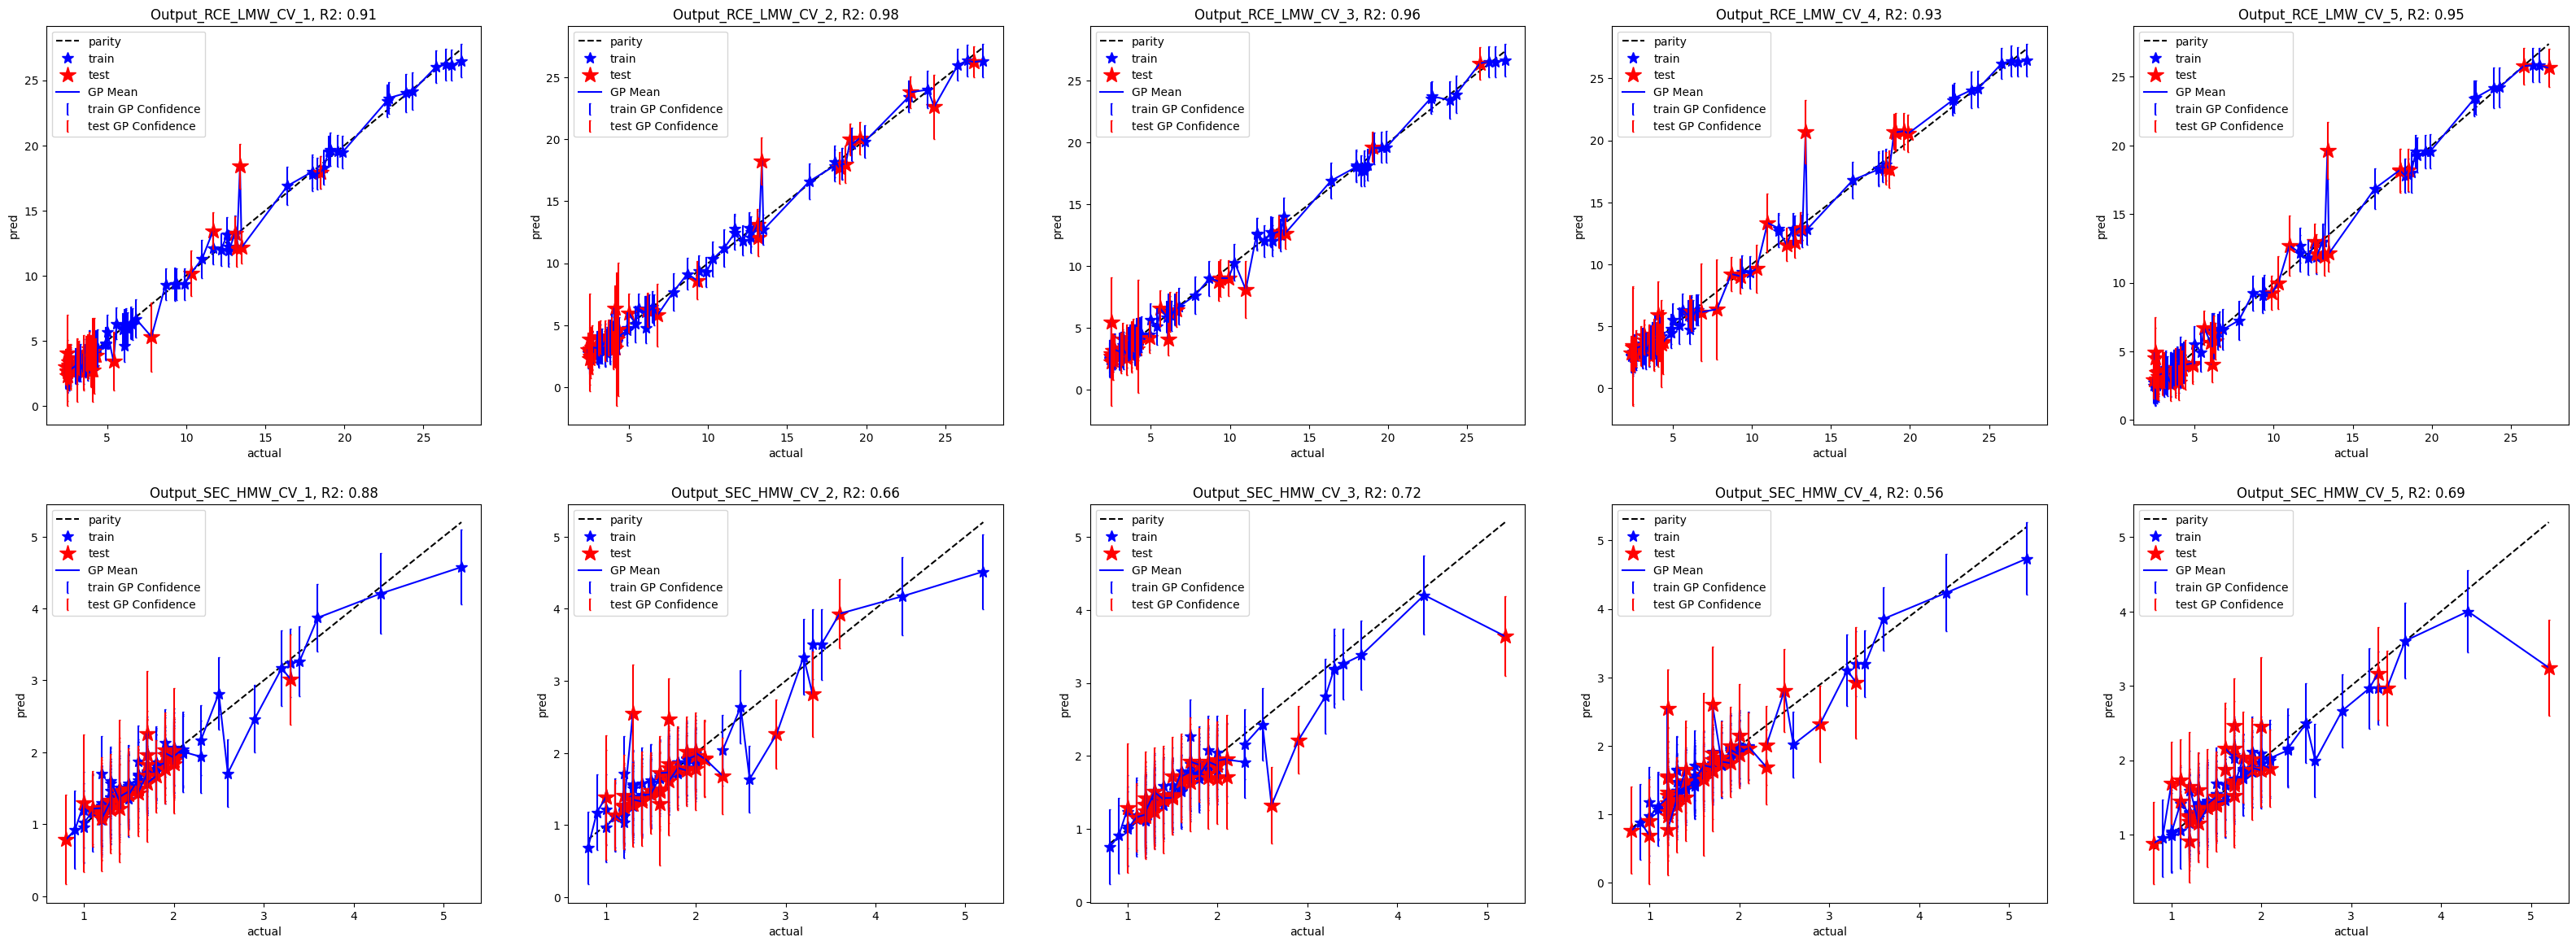

In [ ]:
#simpleGP and rf
#if x_scale_option>0:

y_plot_scale_label='no-y-scale'

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = df_y.columns

plot_axis_lb = df_y.min(axis = 0) - 0.4* df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4* df_y.std(axis = 0)

num_outputs = len(cols_target)
num_tasks = 5 #cv

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))
cols_target_wide = []

lls_models = []
lls_arr_mean = []


# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
f, y_axes = plt.subplots(num_outputs, num_tasks, figsize=(num_tasks*8,num_outputs*7))
y_axes = y_axes.ravel()
for j,col_target in enumerate(cols_target):
    t_train_y = ls_t_y_train[j]
    t_test_y = ls_t_y_test[j]
    #train_mean,train_lower,train_upper,model = simpleGP_gpytorch(t_train_x,t_train_y,training_iter = 700)
    test_mean,test_lower,test_upper,train_mean,train_lower,train_upper,model = simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 500)
    lls_models.append(model)
    arr_test_y = t_test_y.detach().numpy()

    for task_ind in range(num_tasks):
        batch_ind = task_ind
    
        a = task_ind + num_tasks*j
        #a = j + len(cols_target)*task_ind
    
        tmp_col_y = 'Output_'+col_target + '_CV_'+str(task_ind+1)
        cols_target_wide.append(tmp_col_y)
            

        if y_scale_label=='no-y-scale':
                arr_train_y = t_train_y.detach().numpy()
                arr_test_mean = test_mean.detach().numpy()
                arr_test_lower = test_lower.detach().numpy()
                arr_test_upper = test_upper.detach().numpy()

                arr_train_mean = train_mean.detach().numpy()
                arr_train_lower = train_lower.detach().numpy()
                arr_train_upper = train_upper.detach().numpy()
        else:
                y_scaler = ls_y_scaler[j]
                arr_train_y = y_scaler.inverse_transform(t_train_y[batch_ind,:].reshape(-1,1))
                arr_train_mean = y_scaler.inverse_transform(train_mean[batch_ind,:].reshape(-1,1))
                arr_train_lower = y_scaler.inverse_transform(train_lower[batch_ind,:].reshape(-1,1))
                arr_train_upper = y_scaler.inverse_transform(train_upper[batch_ind,:].reshape(-1,1))

                arr_test_mean = y_scaler.inverse_transform(test_mean[batch_ind,:].reshape(-1,1))
                arr_test_lower = y_scaler.inverse_transform(test_lower[batch_ind,:].reshape(-1,1))
                arr_test_upper = y_scaler.inverse_transform(test_upper[batch_ind,:].reshape(-1,1))

        lls_arr_mean.append(arr_train_mean)
        

        y_true = arr_test_y[batch_ind]
        y_pred = arr_test_mean
        y_train = arr_train_y
        mean_train_pred = arr_train_mean
        std_train_pred = arr_train_mean - arr_train_lower
        std_test_pred = arr_test_mean - arr_test_lower

        train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
        df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
        df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
        df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
        df_train_comp['mode'] = 'train'
    
        test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
        df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
        df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
        df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
        df_test_comp['mode'] = 'test'
    
        df_comp = pd.concat([df_train_comp,df_test_comp])
        df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

        #plot a parity line
        y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
        # Plot training data as blue stars
        y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

        # Plot training data as red stars
        y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
        # Predictive mean as blue line
        y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
        if uncertainty_figure_option == 'shade':
            # Shade in confidence
            y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
        else:
            yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
            yerr = yerr.values.tolist()
            yerr_train = df_train_comp['pred'] - df_train_comp['lower']
            yerr_train = yerr_train.values.tolist()
            yerr_test = df_test_comp['pred'] - df_test_comp['lower']
            yerr_test = yerr_test.values.tolist()
            y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
            y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
        if is_set_axis_limit:
            #y_axes[a].set_xlim([-2.5,2.5])
            #y_axes[a].set_ylim([-2.5,2.5])
            y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
            y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

        y_axes[a].legend(['parity','train','test','GP Mean','train GP Confidence','test GP Confidence'])
        #y_axes[a].set_title(tmp_col_y)
        y_axes[a].set_xlabel('actual')
        y_axes[a].set_ylabel('pred')
    

        arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
        arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
        arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
        arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
        arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),6)
        arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
        arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
        arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
        arr_test_metrics[8,a] = round(np.mean(std_test_pred)/np.mean(np.abs(y_true)),2)
        arr_test_metrics[9,a] = round(np.min(std_test_pred)/np.mean(np.abs(y_true)),2)
        arr_test_metrics[10,a] = round(np.max(std_test_pred)/np.mean(np.abs(y_true)),2)

        arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
        arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
        arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
        arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
        arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
        arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
        arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
        arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
        arr_train_metrics[8,a] = round(np.mean(std_train_pred)/np.mean(np.abs(y_train)),2)
        arr_train_metrics[9,a] = round(np.min(std_train_pred)/np.mean(np.abs(y_train)),2)
        arr_train_metrics[10,a] = round(np.max(std_train_pred)/np.mean(np.abs(y_train)),2)

        title_str = tmp_col_y + ', R2: '+ str(arr_test_metrics[7,a])
        y_axes[a].set_title(title_str)

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin-batch.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')




### ShuffleSplit

In [9]:
from sklearn.model_selection import KFold, ShuffleSplit
"""
kfold = KFold(n_splits=5
              , shuffle=True,random_state=0)
"""

shuffle_split_cv = ShuffleSplit(test_size = 0.3,train_size=0.7,n_splits = 5)

ls_X_train = []
ls_X_test = []
ls_y_train = []
ls_y_test = []
X = df_x.to_numpy()
Y = df_y.to_numpy()

ls_y_scaler = []
num_outputs = len(cols_target)

for d in range(num_outputs):
    if y_scale_label == 'y-robust':
            y_scaler = RobustScaler()
            scaled_Y = y_scaler.fit_transform(Y[:,d].reshape(-1,1))
    elif y_scale_label == 'y-stand':
            y_scaler = StandardScaler()
            scaled_Y = y_scaler.fit_transform(Y[:,d].reshape(-1,1))
    elif y_scale_label == 'y-minmax':
            y_scaler = MinMaxScaler()
            scaled_Y = y_scaler.fit_transform(Y[:,d].reshape(-1,1))
    else:
            scaled_Y = Y[:,d].reshape(-1,1)
    ls_y_scaler.append(y_scaler)



for train_ix, test_ix in shuffle_split_cv.split(X):
    X_train, X_test=X[train_ix,:], X[test_ix,:]
    y_train, y_test= Y[train_ix],Y[test_ix]

    if x_scale_label != 'no-x-scale':
        x_mm_scaler = MinMaxScaler()
        scaled_X_train=x_mm_scaler.fit_transform(X_train) 
        scaled_X_test=x_mm_scaler.transform(X_test)
    else:
        scaled_X_train= X_train
        scaled_X_test=X_test

    output_y_train = []
    output_y_test = []
    for d in range(num_outputs):
        y_scaler = ls_y_scaler[d]
        scaled_y_train = y_scaler.transform(y_train[:,d].reshape(-1,1))
        output_y_train.append(torch.Tensor(scaled_y_train))
        output_y_test.append(torch.Tensor(y_test[:,d].reshape(-1,1)))
        
    ls_X_train.append(torch.Tensor(scaled_X_train))
    ls_X_test.append(torch.Tensor(scaled_X_test))
    ls_y_train.append(output_y_train)
    ls_y_test.append(output_y_test)
    #ls_y_train.append(torch.Tensor(y_train))
    #ls_y_test.append(torch.Tensor(y_test))



In [13]:
scaled_X_train.shape

(86, 6)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Iter 1/100 - Loss: 1.152   noise: 0.693
Iter 2/100 - Loss: 1.108   noise: 0.644
Iter 3/100 - Loss: 1.064   noise: 0.598
Iter 4/100 - Loss: 1.020   noise: 0.554
Iter 5/100 - Loss: 0.976   noise: 0.513
Iter 6/100 - Loss: 0.932   noise: 0.474
Iter 7/100 - Loss: 0.890   noise: 0.437
Iter 8/100 - Loss: 0.848   noise: 0.402
Iter 9/100 - Loss: 0.808   noise: 0.369
Iter 10/100 - Loss: 0.769   noise: 0.339
Iter 11/100 - Loss: 0.732   noise: 0.311
Iter 12/100 - Loss: 0.695   noise: 0.284
Iter 13/100 - Loss: 0.659   noise: 0.260
Iter 14/100 - Loss: 0.624   noise: 0.237
Iter 15/100 - Loss: 0.589   noise: 0.216
Iter 16/100 - Loss: 0.554   noise: 0.197
Iter 17/100 - Loss: 0.521   noise: 0.180
Iter 18/100 - Loss: 0.488   noise: 0.163
Iter 19/100 - Loss: 0

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 54/100 - Loss: 0.060   noise: 0.020
Iter 55/100 - Loss: 0.057   noise: 0.020
Iter 56/100 - Loss: 0.055   noise: 0.020
Iter 57/100 - Loss: 0.052   noise: 0.021
Iter 58/100 - Loss: 0.049   noise: 0.021
Iter 59/100 - Loss: 0.047   noise: 0.021
Iter 60/100 - Loss: 0.044   noise: 0.022
Iter 61/100 - Loss: 0.042   noise: 0.022
Iter 62/100 - Loss: 0.040   noise: 0.023
Iter 63/100 - Loss: 0.037   noise: 0.023
Iter 64/100 - Loss: 0.035   noise: 0.023
Iter 65/100 - Loss: 0.033   noise: 0.024
Iter 66/100 - Loss: 0.031   noise: 0.024
Iter 67/100 - Loss: 0.030   noise: 0.024
Iter 68/100 - Loss: 0.028   noise: 0.025
Iter 69/100 - Loss: 0.026   noise: 0.025
Iter 70/100 - Loss: 0.024   noise: 0.025
Iter 71/100 - Loss: 0.022   noise: 0.025
Iter 72/100 - Loss: 0.021   noise: 0.025
Iter 73/100 - Loss: 0.020   noise: 0.025
Iter 74/100 - Loss: 0.019   noise: 0.024
Iter 75/100 - Loss: 0.019   noise: 0.024
Iter 76/100 - Loss: 0.018   noise: 0.024
Iter 77/100 - Loss: 0.017   noise: 0.024
Iter 78/100 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 34/100 - Loss: 0.002   noise: 0.035
Iter 35/100 - Loss: -0.016   noise: 0.032
Iter 36/100 - Loss: -0.033   noise: 0.030
Iter 37/100 - Loss: -0.048   noise: 0.027
Iter 38/100 - Loss: -0.061   noise: 0.025
Iter 39/100 - Loss: -0.073   noise: 0.023
Iter 40/100 - Loss: -0.084   noise: 0.021
Iter 41/100 - Loss: -0.093   noise: 0.020
Iter 42/100 - Loss: -0.100   noise: 0.019
Iter 43/100 - Loss: -0.106   noise: 0.017
Iter 44/100 - Loss: -0.110   noise: 0.016
Iter 45/100 - Loss: -0.113   noise: 0.015
Iter 46/100 - Loss: -0.116   noise: 0.015
Iter 47/100 - Loss: -0.117   noise: 0.014
Iter 48/100 - Loss: -0.118   noise: 0.013
Iter 49/100 - Loss: -0.118   noise: 0.013
Iter 50/100 - Loss: -0.119   noise: 0.012
Iter 51/100 - Loss: -0.120   noise: 0.012
Iter 52/100 - Loss: -0.121   noise: 0.012
Iter 53/100 - Loss: -0.122   noise: 0.012
Iter 54/100 - Loss: -0.125   noise: 0.011
Iter 55/100 - Loss: -0.128   noise: 0.011
Iter 56/100 - Loss: -0.132   noise: 0.011
Iter 57/100 - Loss: -0.138   noise:

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 17/100 - Loss: 0.508   noise: 0.180
Iter 18/100 - Loss: 0.475   noise: 0.163
Iter 19/100 - Loss: 0.443   noise: 0.149
Iter 20/100 - Loss: 0.412   noise: 0.135
Iter 21/100 - Loss: 0.381   noise: 0.123
Iter 22/100 - Loss: 0.352   noise: 0.111
Iter 23/100 - Loss: 0.324   noise: 0.101
Iter 24/100 - Loss: 0.297   noise: 0.092
Iter 25/100 - Loss: 0.271   noise: 0.084
Iter 26/100 - Loss: 0.247   noise: 0.076
Iter 27/100 - Loss: 0.224   noise: 0.069
Iter 28/100 - Loss: 0.202   noise: 0.063
Iter 29/100 - Loss: 0.183   noise: 0.058
Iter 30/100 - Loss: 0.164   noise: 0.053
Iter 31/100 - Loss: 0.148   noise: 0.048
Iter 32/100 - Loss: 0.133   noise: 0.044
Iter 33/100 - Loss: 0.120   noise: 0.041
Iter 34/100 - Loss: 0.108   noise: 0.038
Iter 35/100 - Loss: 0.099   noise: 0.035
Iter 36/100 - Loss: 0.090   noise: 0.032
Iter 37/100 - Loss: 0.083   noise: 0.030
Iter 38/100 - Loss: 0.078   noise: 0.028
Iter 39/100 - Loss: 0.073   noise: 0.027
Iter 40/100 - Loss: 0.070   noise: 0.025
Iter 41/100 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 1/100 - Loss: 1.131   noise: 0.693
Iter 2/100 - Loss: 1.087   noise: 0.644
Iter 3/100 - Loss: 1.043   noise: 0.598
Iter 4/100 - Loss: 1.000   noise: 0.554
Iter 5/100 - Loss: 0.956   noise: 0.513
Iter 6/100 - Loss: 0.912   noise: 0.474
Iter 7/100 - Loss: 0.870   noise: 0.437
Iter 8/100 - Loss: 0.828   noise: 0.402
Iter 9/100 - Loss: 0.787   noise: 0.369
Iter 10/100 - Loss: 0.748   noise: 0.339
Iter 11/100 - Loss: 0.709   noise: 0.311
Iter 12/100 - Loss: 0.671   noise: 0.284
Iter 13/100 - Loss: 0.634   noise: 0.260
Iter 14/100 - Loss: 0.597   noise: 0.237
Iter 15/100 - Loss: 0.560   noise: 0.216
Iter 16/100 - Loss: 0.524   noise: 0.197
Iter 17/100 - Loss: 0.488   noise: 0.179
Iter 18/100 - Loss: 0.452   noise: 0.163
Iter 19/100 - Loss: 0.417   noise: 0.148
Iter 20/100 - Loss: 0.383   noise: 0.135
Iter 21/100 - Loss: 0.349   noise: 0.122
Iter 22/100 - Loss: 0.316   noise: 0.111
Iter 23/100 - Loss: 0.283   noise: 0.101
Iter 24/100 - Loss: 0.251   noise: 0.091
Iter 25/100 - Loss: 0.221

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 66/100 - Loss: 0.801   noise: 0.068
Iter 67/100 - Loss: 0.801   noise: 0.067
Iter 68/100 - Loss: 0.801   noise: 0.066
Iter 69/100 - Loss: 0.801   noise: 0.066
Iter 70/100 - Loss: 0.800   noise: 0.065
Iter 71/100 - Loss: 0.800   noise: 0.064
Iter 72/100 - Loss: 0.800   noise: 0.064
Iter 73/100 - Loss: 0.800   noise: 0.063
Iter 74/100 - Loss: 0.800   noise: 0.063
Iter 75/100 - Loss: 0.800   noise: 0.062
Iter 76/100 - Loss: 0.799   noise: 0.062
Iter 77/100 - Loss: 0.799   noise: 0.062
Iter 78/100 - Loss: 0.799   noise: 0.061
Iter 79/100 - Loss: 0.799   noise: 0.061
Iter 80/100 - Loss: 0.799   noise: 0.061
Iter 81/100 - Loss: 0.799   noise: 0.061
Iter 82/100 - Loss: 0.799   noise: 0.061
Iter 83/100 - Loss: 0.799   noise: 0.061
Iter 84/100 - Loss: 0.799   noise: 0.061
Iter 85/100 - Loss: 0.799   noise: 0.061
Iter 86/100 - Loss: 0.799   noise: 0.061
Iter 87/100 - Loss: 0.799   noise: 0.061
Iter 88/100 - Loss: 0.798   noise: 0.061
Iter 89/100 - Loss: 0.798   noise: 0.061
Iter 90/100 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 41/100 - Loss: 1.047   noise: 0.185
Iter 42/100 - Loss: 1.047   noise: 0.187
Iter 43/100 - Loss: 1.047   noise: 0.188
Iter 44/100 - Loss: 1.047   noise: 0.189
Iter 45/100 - Loss: 1.046   noise: 0.188
Iter 46/100 - Loss: 1.046   noise: 0.187
Iter 47/100 - Loss: 1.046   noise: 0.185
Iter 48/100 - Loss: 1.045   noise: 0.184
Iter 49/100 - Loss: 1.045   noise: 0.181
Iter 50/100 - Loss: 1.044   noise: 0.179
Iter 51/100 - Loss: 1.044   noise: 0.176
Iter 52/100 - Loss: 1.044   noise: 0.174
Iter 53/100 - Loss: 1.043   noise: 0.171
Iter 54/100 - Loss: 1.043   noise: 0.169
Iter 55/100 - Loss: 1.043   noise: 0.167
Iter 56/100 - Loss: 1.043   noise: 0.166
Iter 57/100 - Loss: 1.043   noise: 0.165
Iter 58/100 - Loss: 1.043   noise: 0.164
Iter 59/100 - Loss: 1.043   noise: 0.164
Iter 60/100 - Loss: 1.043   noise: 0.163
Iter 61/100 - Loss: 1.043   noise: 0.164
Iter 62/100 - Loss: 1.043   noise: 0.164
Iter 63/100 - Loss: 1.043   noise: 0.165
Iter 64/100 - Loss: 1.042   noise: 0.166
Iter 65/100 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 17/100 - Loss: 1.078   noise: 0.187
Iter 18/100 - Loss: 1.075   noise: 0.174
Iter 19/100 - Loss: 1.074   noise: 0.162
Iter 20/100 - Loss: 1.072   noise: 0.152
Iter 21/100 - Loss: 1.070   noise: 0.144
Iter 22/100 - Loss: 1.069   noise: 0.137
Iter 23/100 - Loss: 1.069   noise: 0.132
Iter 24/100 - Loss: 1.069   noise: 0.129
Iter 25/100 - Loss: 1.068   noise: 0.127
Iter 26/100 - Loss: 1.067   noise: 0.125
Iter 27/100 - Loss: 1.066   noise: 0.125
Iter 28/100 - Loss: 1.063   noise: 0.126
Iter 29/100 - Loss: 1.061   noise: 0.127
Iter 30/100 - Loss: 1.058   noise: 0.130
Iter 31/100 - Loss: 1.056   noise: 0.132
Iter 32/100 - Loss: 1.054   noise: 0.136
Iter 33/100 - Loss: 1.053   noise: 0.139
Iter 34/100 - Loss: 1.051   noise: 0.143
Iter 35/100 - Loss: 1.050   noise: 0.147
Iter 36/100 - Loss: 1.050   noise: 0.151
Iter 37/100 - Loss: 1.049   noise: 0.155
Iter 38/100 - Loss: 1.049   noise: 0.159
Iter 39/100 - Loss: 1.048   noise: 0.162
Iter 40/100 - Loss: 1.048   noise: 0.165
Iter 41/100 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 74/100 - Loss: 0.780   noise: 0.086
Iter 75/100 - Loss: 0.780   noise: 0.085
Iter 76/100 - Loss: 0.780   noise: 0.085
Iter 77/100 - Loss: 0.780   noise: 0.085
Iter 78/100 - Loss: 0.780   noise: 0.084
Iter 79/100 - Loss: 0.780   noise: 0.084
Iter 80/100 - Loss: 0.780   noise: 0.084
Iter 81/100 - Loss: 0.780   noise: 0.084
Iter 82/100 - Loss: 0.780   noise: 0.084
Iter 83/100 - Loss: 0.780   noise: 0.084
Iter 84/100 - Loss: 0.780   noise: 0.084
Iter 85/100 - Loss: 0.780   noise: 0.084
Iter 86/100 - Loss: 0.780   noise: 0.084
Iter 87/100 - Loss: 0.780   noise: 0.084
Iter 88/100 - Loss: 0.779   noise: 0.084
Iter 89/100 - Loss: 0.779   noise: 0.085
Iter 90/100 - Loss: 0.779   noise: 0.085
Iter 91/100 - Loss: 0.779   noise: 0.085
Iter 92/100 - Loss: 0.779   noise: 0.085
Iter 93/100 - Loss: 0.779   noise: 0.086
Iter 94/100 - Loss: 0.779   noise: 0.086
Iter 95/100 - Loss: 0.779   noise: 0.086
Iter 96/100 - Loss: 0.779   noise: 0.086
Iter 97/100 - Loss: 0.779   noise: 0.087
Iter 98/100 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


Iter 56/100 - Loss: 0.819   noise: 0.139
Iter 57/100 - Loss: 0.818   noise: 0.137
Iter 58/100 - Loss: 0.818   noise: 0.135
Iter 59/100 - Loss: 0.818   noise: 0.134
Iter 60/100 - Loss: 0.817   noise: 0.132
Iter 61/100 - Loss: 0.817   noise: 0.131
Iter 62/100 - Loss: 0.817   noise: 0.129
Iter 63/100 - Loss: 0.817   noise: 0.128
Iter 64/100 - Loss: 0.817   noise: 0.127
Iter 65/100 - Loss: 0.817   noise: 0.126
Iter 66/100 - Loss: 0.817   noise: 0.125
Iter 67/100 - Loss: 0.817   noise: 0.125
Iter 68/100 - Loss: 0.816   noise: 0.124
Iter 69/100 - Loss: 0.816   noise: 0.124
Iter 70/100 - Loss: 0.816   noise: 0.124
Iter 71/100 - Loss: 0.816   noise: 0.125
Iter 72/100 - Loss: 0.816   noise: 0.125
Iter 73/100 - Loss: 0.816   noise: 0.126
Iter 74/100 - Loss: 0.816   noise: 0.126
Iter 75/100 - Loss: 0.816   noise: 0.127
Iter 76/100 - Loss: 0.815   noise: 0.128
Iter 77/100 - Loss: 0.815   noise: 0.129
Iter 78/100 - Loss: 0.815   noise: 0.129
Iter 79/100 - Loss: 0.815   noise: 0.130
Iter 80/100 - Lo

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_28114/1651916471.py:124: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)


         Output_RCE_LMW_CV_1  Output_RCE_LMW_CV_2  Output_RCE_LMW_CV_3  \
MAE                 0.720000             0.690000             0.960000   
MAE2                0.470000             0.460000             0.870000   
MSE                 0.920000             1.030000             1.990000   
RMSE                0.960000             1.020000             1.410000   
MAPE                0.143916             0.140496             0.228464   
MAXE                2.860000             3.500000             5.190000   
EVS                 0.970000             0.980000             0.950000   
R2                  0.970000             0.980000             0.950000   
AVG_STD             0.270000             0.290000             0.260000   
MIN_STD             0.180000             0.210000             0.150000   
MAX_STD             0.700000             0.500000             0.620000   

         Output_RCE_LMW_CV_4  Output_RCE_LMW_CV_5  Output_SEC_HMW_CV_1  \
MAE                 0.720000         

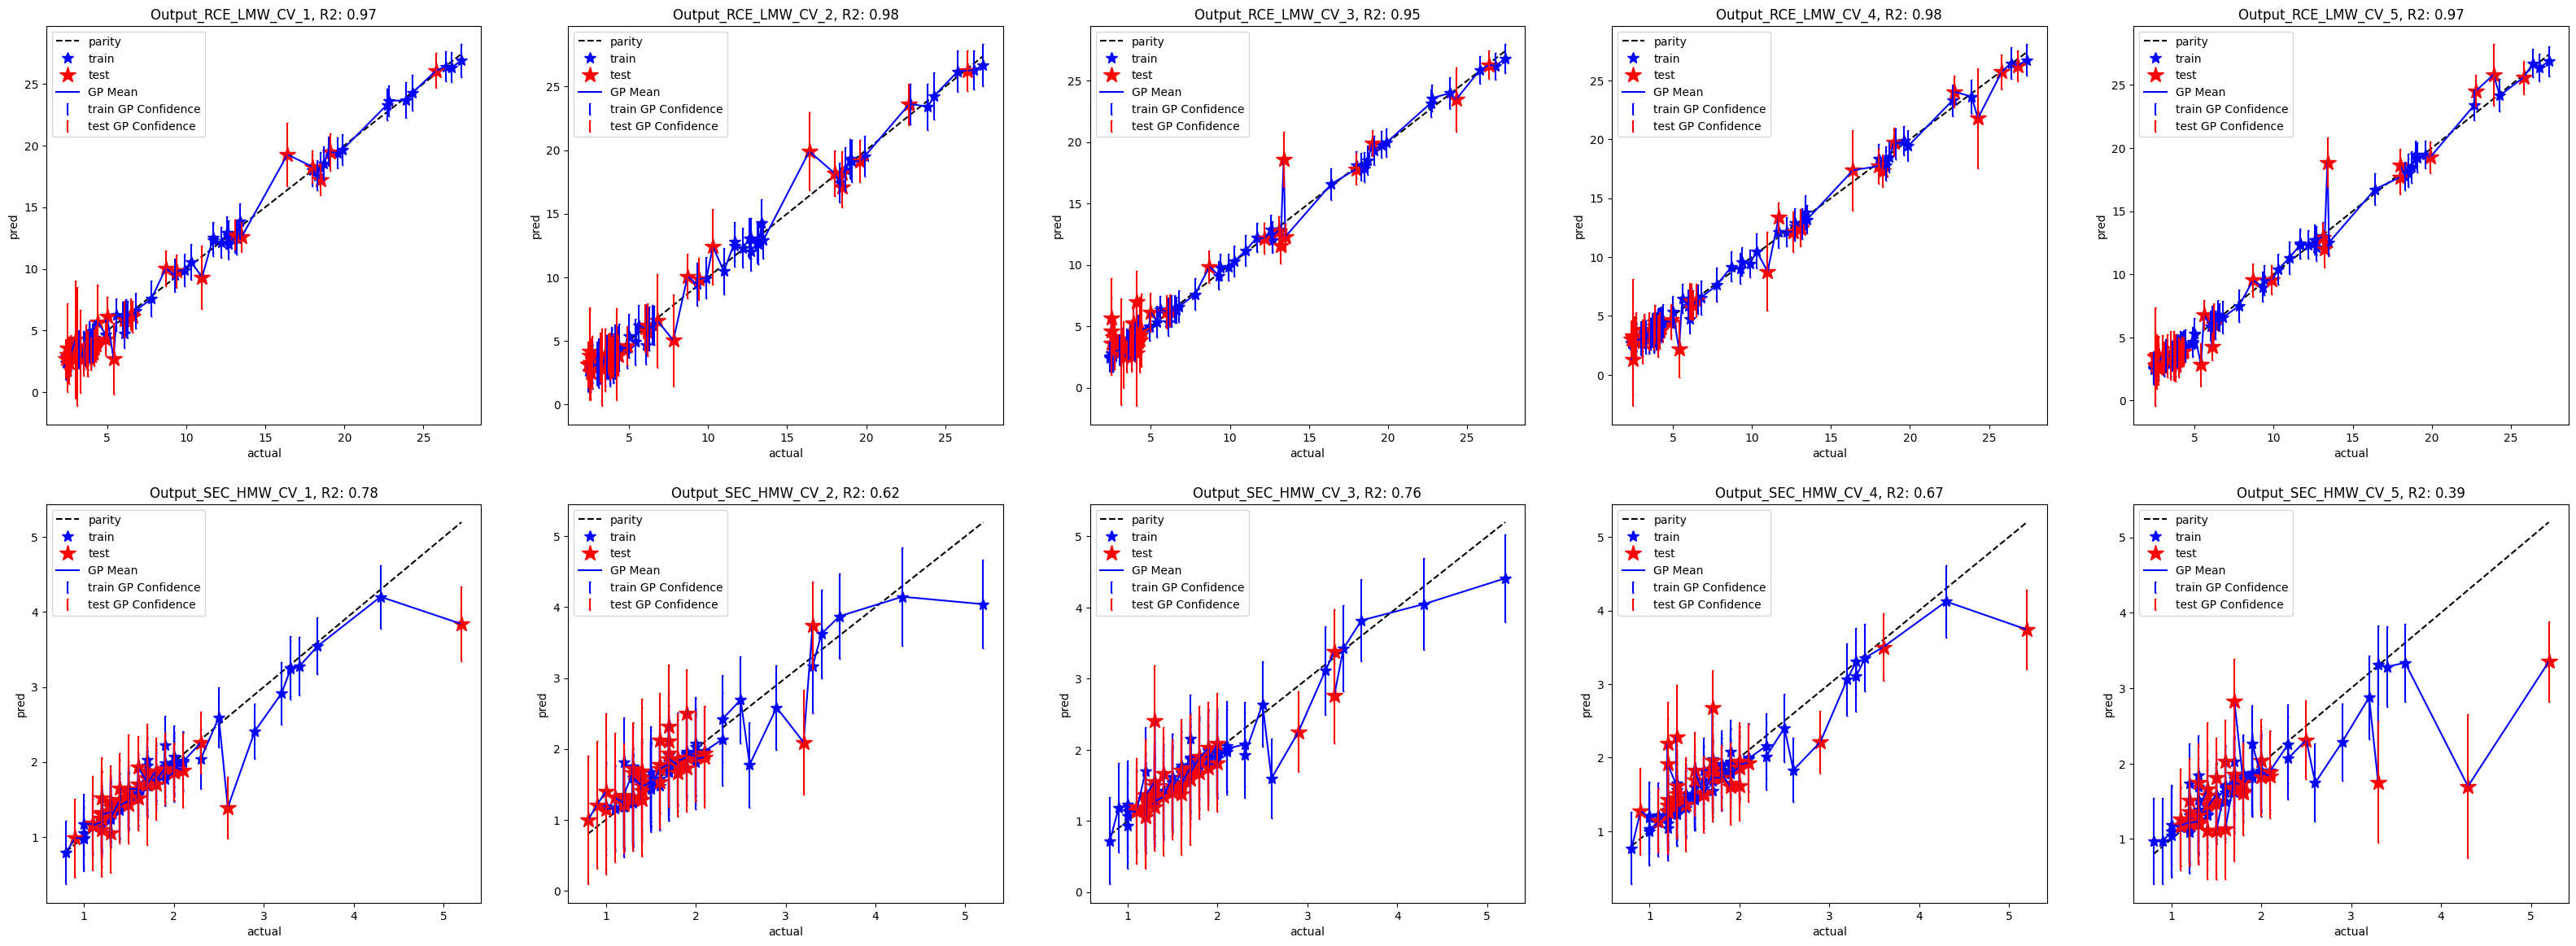

In [14]:
#simpleGP and rf
#if x_scale_option>0:

y_plot_scale_label='no-y-scale'

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = df_y.columns

plot_axis_lb = df_y.min(axis = 0) - 0.4* df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4* df_y.std(axis = 0)

num_outputs = len(cols_target)
num_tasks = 5 #cv

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))
cols_target_wide = []

lls_models = []
lls_arr_mean = []


# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
f, y_axes = plt.subplots(num_outputs, num_tasks, figsize=(num_tasks*8,num_outputs*7))
y_axes = y_axes.ravel()
for j,col_target in enumerate(cols_target):
    for task_ind in range(num_tasks):
    
        a = task_ind + num_tasks*j
        #a = j + len(cols_target)*task_ind
    
        tmp_col_y = 'Output_'+col_target + '_CV_'+str(task_ind+1)
        cols_target_wide.append(tmp_col_y)
    
        scaled_X_train_task = scaled_X_train
        scaled_X_test_task = scaled_X_test
        
        
        

        t_train_x = ls_X_train[task_ind]
        t_train_y = ls_y_train[task_ind][j].flatten()
        t_test_x = ls_X_test[task_ind]
        t_test_y = ls_y_test[task_ind][j].flatten()

        if model_option == 'rf':
            y_train = df_y_train[tmp_col_y].to_numpy()
            y_true = df_y_test[tmp_col_y].to_numpy()
            mean_train_pred, std_train_pred, mean_test_pred, std_test_pred, _, = rf_sklearn(scaled_X_train,
                                                                                      y_train,
                                                                                      scaled_X_test,
                                                                                      y_true,
                                                                                      cols_feature_new,
                                                                                      tmp_col_y,figPath,
                                                                                      is_plot_imp = False)
            y_pred = mean_test_pred
        elif model_option == 'simpleGP':

            
      
            

            test_mean,test_lower,test_upper,train_mean,train_lower,train_upper,model = simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 100)
            lls_models.append(model)

            arr_train_x = t_train_x.detach().numpy()
            arr_test_x = t_test_x.detach().numpy()
            arr_test_y = t_test_y.detach().numpy()

            if y_scale_label=='no-y-scale':
                arr_train_y = t_train_y.detach().numpy()
                arr_test_mean = test_mean.detach().numpy()
                arr_test_lower = test_lower.detach().numpy()
                arr_test_upper = test_upper.detach().numpy()

                arr_train_mean = train_mean.detach().numpy()
                arr_train_lower = train_lower.detach().numpy()
                arr_train_upper = train_upper.detach().numpy()
            else:
                y_scaler = ls_y_scaler[j]
                arr_train_y = y_scaler.inverse_transform(t_train_y.reshape(-1,1))
                arr_train_mean = y_scaler.inverse_transform(train_mean.reshape(-1,1))
                arr_train_lower = y_scaler.inverse_transform(train_lower.reshape(-1,1))
                arr_train_upper = y_scaler.inverse_transform(train_upper.reshape(-1,1))

                arr_test_mean = y_scaler.inverse_transform(test_mean.reshape(-1,1))
                arr_test_lower = y_scaler.inverse_transform(test_lower.reshape(-1,1))
                arr_test_upper = y_scaler.inverse_transform(test_upper.reshape(-1,1))

        lls_arr_mean.append(arr_train_mean)

        y_true = arr_test_y
        y_pred = arr_test_mean
        y_train = arr_train_y
        mean_train_pred = arr_train_mean
        std_train_pred = arr_train_mean - arr_train_lower
        std_test_pred = arr_test_mean - arr_test_lower

        train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
        df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
        df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
        df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
        df_train_comp['mode'] = 'train'
    
        test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
        df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
        df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
        df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
        df_test_comp['mode'] = 'test'
    
        df_comp = pd.concat([df_train_comp,df_test_comp])
        df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

        #plot a parity line
        y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
        # Plot training data as blue stars
        y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

        # Plot training data as red stars
        y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
        # Predictive mean as blue line
        y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
        if uncertainty_figure_option == 'shade':
            # Shade in confidence
            y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
        else:
            yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
            yerr = yerr.values.tolist()
            yerr_train = df_train_comp['pred'] - df_train_comp['lower']
            yerr_train = yerr_train.values.tolist()
            yerr_test = df_test_comp['pred'] - df_test_comp['lower']
            yerr_test = yerr_test.values.tolist()
            y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
            y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
        if is_set_axis_limit:
            #y_axes[a].set_xlim([-2.5,2.5])
            #y_axes[a].set_ylim([-2.5,2.5])
            y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
            y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

        y_axes[a].legend(['parity','train','test','GP Mean','train GP Confidence','test GP Confidence'])
        #y_axes[a].set_title(tmp_col_y)
        y_axes[a].set_xlabel('actual')
        y_axes[a].set_ylabel('pred')
    

        arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
        arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
        arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
        arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
        arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),6)
        arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
        arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
        arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
        arr_test_metrics[8,a] = round(np.mean(std_test_pred)/np.mean(np.abs(y_true)),2)
        arr_test_metrics[9,a] = round(np.min(std_test_pred)/np.mean(np.abs(y_true)),2)
        arr_test_metrics[10,a] = round(np.max(std_test_pred)/np.mean(np.abs(y_true)),2)

        arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
        arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
        arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
        arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
        arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
        arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
        arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
        arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
        arr_train_metrics[8,a] = round(np.mean(std_train_pred)/np.mean(np.abs(y_train)),2)
        arr_train_metrics[9,a] = round(np.min(std_train_pred)/np.mean(np.abs(y_train)),2)
        arr_train_metrics[10,a] = round(np.max(std_train_pred)/np.mean(np.abs(y_train)),2)

        title_str = tmp_col_y + ', R2: '+ str(arr_test_metrics[7,a])
        y_axes[a].set_title(title_str)

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')




## Together

Iter 1/100 - Loss: 5.614   noise: 0.693
Iter 2/100 - Loss: 5.397   noise: 0.644
Iter 3/100 - Loss: 5.181   noise: 0.598
Iter 4/100 - Loss: 4.963   noise: 0.554
Iter 5/100 - Loss: 4.748   noise: 0.513
Iter 6/100 - Loss: 4.534   noise: 0.474
Iter 7/100 - Loss: 4.324   noise: 0.437
Iter 8/100 - Loss: 4.119   noise: 0.402
Iter 9/100 - Loss: 3.920   noise: 0.370
Iter 10/100 - Loss: 3.726   noise: 0.339
Iter 11/100 - Loss: 3.536   noise: 0.311
Iter 12/100 - Loss: 3.352   noise: 0.285
Iter 13/100 - Loss: 3.170   noise: 0.260
Iter 14/100 - Loss: 2.992   noise: 0.238
Iter 15/100 - Loss: 2.816   noise: 0.217
Iter 16/100 - Loss: 2.644   noise: 0.198
Iter 17/100 - Loss: 2.474   noise: 0.180
Iter 18/100 - Loss: 2.309   noise: 0.164
Iter 19/100 - Loss: 2.148   noise: 0.149
Iter 20/100 - Loss: 1.992   noise: 0.135
Iter 21/100 - Loss: 1.840   noise: 0.123
Iter 22/100 - Loss: 1.694   noise: 0.112
Iter 23/100 - Loss: 1.554   noise: 0.102
Iter 24/100 - Loss: 1.420   noise: 0.092
Iter 25/100 - Loss: 1.293

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 99 and the array at index 1 has size 495

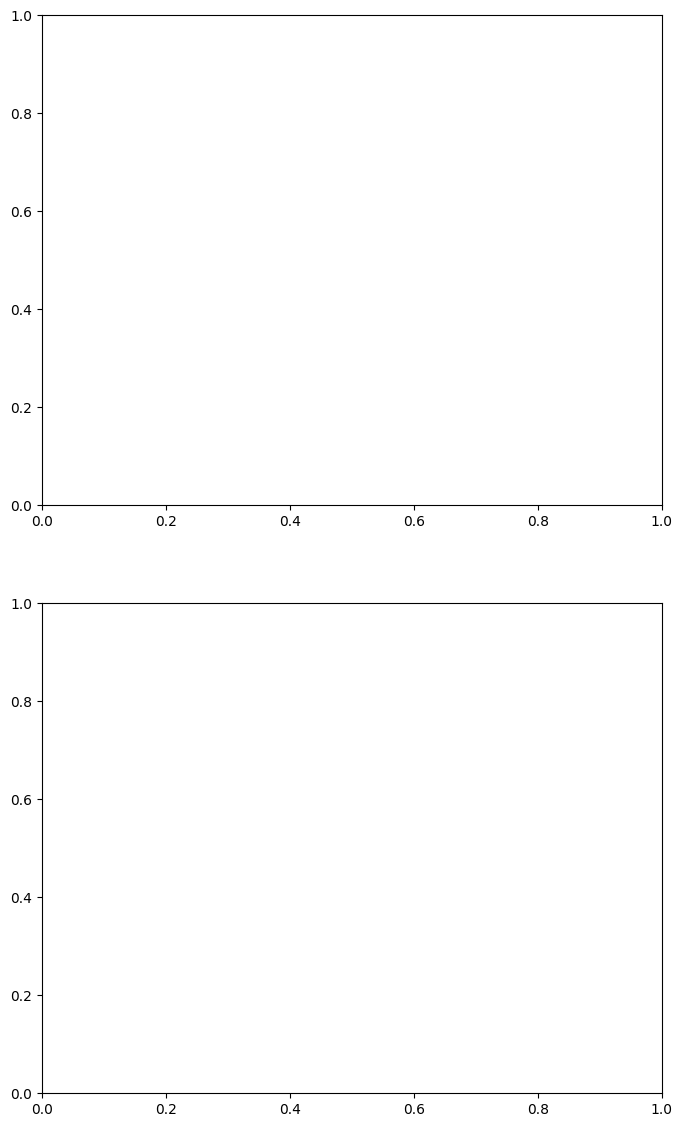

In [17]:

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=4,
                                                                stratify=df_x[cols_cate]) #1 good, #3 OK

xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_mm_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_mm_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)



#simpleGP and rf
#if x_scale_option>0:

y_plot_scale_label='no-y-scale'

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = df_y.columns

plot_axis_lb = df_y.min(axis = 0) - 0.4* df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4* df_y.std(axis = 0)

num_outputs = len(cols_target)
num_tasks = 1

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))
cols_target_wide = []

lls_models = []
lls_arr_mean = []
ls_y_scaler = []

ls_df_train_compare = []
ls_df_test_compare = []

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
f, y_axes = plt.subplots(num_outputs, num_tasks, figsize=(num_tasks*8,num_outputs*7))
y_axes = y_axes.ravel()
for j,col_target in enumerate(cols_target):
  for task_ind in range(num_tasks):
  
    a = task_ind + num_tasks*j
    #a = j + len(cols_target)*task_ind
    #tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+col_target
    tmp_col_y = 'Output_'+col_target
    cols_target_wide.append(tmp_col_y)
    
    scaled_X_train_task = scaled_X_train
    scaled_X_test_task = scaled_X_test
    df_X_train_task = df_X_train
    df_X_test_task = df_X_test
    if x_scale_label != 'no-x-scale':
        t_train_x = torch.Tensor(scaled_X_train_task)
        t_test_x = torch.Tensor(scaled_X_test_task)
    else:
        t_train_x = torch.Tensor(df_X_train_task.to_numpy())
        t_test_x = torch.Tensor(df_X_test_task.to_numpy())

    df_y_train_task = df_y_train.iloc[:,j]
    df_y_test_task = df_y_test.iloc[:,j]

    if model_option == 'rf':
      y_train = df_y_train[tmp_col_y].to_numpy()
      y_true = df_y_test[tmp_col_y].to_numpy()
      mean_train_pred, std_train_pred, mean_test_pred, std_test_pred, _, = rf_sklearn(scaled_X_train,
                                                                                      y_train,
                                                                                      scaled_X_test,
                                                                                      y_true,
                                                                                      cols_feature_new,
                                                                                      tmp_col_y,figPath,
                                                                                      is_plot_imp = False)
      #mean_train = mean_train_pred
      y_pred = mean_test_pred
    elif model_option == 'simpleGP':

      if y_scale_label == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train_task.to_numpy().reshape(-1,1))
      elif y_scale_label == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train_task.to_numpy().reshape(-1,1))
      elif y_scale_label == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train_task.to_numpy().reshape(-1,1))
      else:
        scaled_y_train = df_y_train_task.to_numpy()
      
      ls_y_scaler.append(y_scaler)

      t_train_y = torch.Tensor(scaled_y_train).flatten()
      test_mean,test_lower,test_upper,train_mean,train_lower,train_upper,model = simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 100)
      lls_models.append(model)

      t_test_y = torch.Tensor(df_y_test_task.to_numpy())
      arr_train_x = t_train_x.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()

      if y_scale_label=='no-y-scale':
        arr_train_y = t_train_y.detach().numpy()
        arr_test_mean = test_mean.detach().numpy()
        arr_test_lower = test_lower.detach().numpy()
        arr_test_upper = test_upper.detach().numpy()

        arr_train_mean = train_mean.detach().numpy()
        arr_train_lower = train_lower.detach().numpy()
        arr_train_upper = train_upper.detach().numpy()
      else:
        arr_train_y = y_scaler.inverse_transform(t_train_y.reshape(-1,1))
        arr_train_mean = y_scaler.inverse_transform(train_mean.reshape(-1,1))
        arr_train_lower = y_scaler.inverse_transform(train_lower.reshape(-1,1))
        arr_train_upper = y_scaler.inverse_transform(train_upper.reshape(-1,1))

        arr_test_mean = y_scaler.inverse_transform(test_mean.reshape(-1,1))
        arr_test_lower = y_scaler.inverse_transform(test_lower.reshape(-1,1))
        arr_test_upper = y_scaler.inverse_transform(test_upper.reshape(-1,1))

      lls_arr_mean.append(arr_train_mean)

      y_true = arr_test_y
      y_pred = arr_test_mean
      y_train = arr_train_y
      mean_train_pred = arr_train_mean
      std_train_pred = arr_train_mean - arr_train_lower
      std_test_pred = arr_test_mean - arr_test_lower

    train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
    df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
    df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      #y_axes[a].set_xlim([-2.5,2.5])
      #y_axes[a].set_ylim([-2.5,2.5])
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),6)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(std_test_pred)/np.mean(np.abs(y_true)),2)
    arr_test_metrics[9,a] = round(np.min(std_test_pred)/np.mean(np.abs(y_true)),2)
    arr_test_metrics[10,a] = round(np.max(std_test_pred)/np.mean(np.abs(y_true)),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
    arr_train_metrics[8,a] = round(np.mean(std_train_pred)/np.mean(np.abs(y_train)),2)
    arr_train_metrics[9,a] = round(np.min(std_train_pred)/np.mean(np.abs(y_train)),2)
    arr_train_metrics[10,a] = round(np.max(std_train_pred)/np.mean(np.abs(y_train)),2)
    
    y_axes[a].set_title(tmp_col_y + ', R2:' + str(arr_test_metrics[7,a]))
    ls_df_train_compare.append(df_train_comp)
    ls_df_test_compare.append(df_test_comp)

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')


In [46]:
within1sd_train_1 = (df_train_comp['true'] > df_train_comp['lower']) & (df_train_comp['true'] < df_train_comp['upper'])
print(sum(within1sd_train_1)/len(df_train_comp))

within1sd_test_1 = (df_test_comp['true'] > df_test_comp['lower']) & (df_test_comp['true'] < df_test_comp['upper'])
print(sum(within1sd_test_1)/len(df_test_comp))

1.0
0.88


In [48]:
df_train_comp = ls_df_train_compare[0]
df_test_comp = ls_df_test_compare[0]

within1sd_train_1 = (df_train_comp['true'] > df_train_comp['lower']) & (df_train_comp['true'] < df_train_comp['upper'])
print(sum(within1sd_train_1)/len(df_train_comp))

within1sd_test_1 = (df_test_comp['true'] > df_test_comp['lower']) & (df_test_comp['true'] < df_test_comp['upper'])
print(sum(within1sd_test_1)/len(df_test_comp))

0.98989898989899
0.84


In [51]:
(0.88+0.84)/2

0.86

## By Task

Iter 1/50 - Loss: 1.327   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.312   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.297   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 1.283   lengthscale: 0.850   noise: 0.554
Iter 5/50 - Loss: 1.270   lengthscale: 0.899   noise: 0.513
Iter 6/50 - Loss: 1.258   lengthscale: 0.938   noise: 0.474
Iter 7/50 - Loss: 1.246   lengthscale: 0.963   noise: 0.438
Iter 8/50 - Loss: 1.233   lengthscale: 0.973   noise: 0.404
Iter 9/50 - Loss: 1.221   lengthscale: 0.970   noise: 0.372
Iter 10/50 - Loss: 1.208   lengthscale: 0.958   noise: 0.343
Iter 11/50 - Loss: 1.196   lengthscale: 0.940   noise: 0.315
Iter 12/50 - Loss: 1.184   lengthscale: 0.921   noise: 0.290
Iter 13/50 - Loss: 1.174   lengthscale: 0.904   noise: 0.266
Iter 14/50 - Loss: 1.163   lengthscale: 0.893   noise: 0.244
Iter 15/50 - Loss: 1.153   lengthscale: 0.892   noise: 0.223
Iter 16/50 - Loss: 1.143   lengthscale: 0.900   noise: 0.205
Iter 17/50 - Loss: 1.133   length

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_2693/2122568830.py:137: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_2693/2122568830.py:140: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:2

Iter 1/50 - Loss: 1.244   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.219   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.195   lengthscale: 0.797   noise: 0.598
Iter 4/50 - Loss: 1.172   lengthscale: 0.852   noise: 0.554
Iter 5/50 - Loss: 1.150   lengthscale: 0.907   noise: 0.513
Iter 6/50 - Loss: 1.128   lengthscale: 0.963   noise: 0.474
Iter 7/50 - Loss: 1.108   lengthscale: 1.017   noise: 0.437
Iter 8/50 - Loss: 1.089   lengthscale: 1.069   noise: 0.403
Iter 9/50 - Loss: 1.070   lengthscale: 1.116   noise: 0.371
Iter 10/50 - Loss: 1.053   lengthscale: 1.158   noise: 0.341
Iter 11/50 - Loss: 1.036   lengthscale: 1.193   noise: 0.314
Iter 12/50 - Loss: 1.020   lengthscale: 1.220   noise: 0.288
Iter 13/50 - Loss: 1.005   lengthscale: 1.238   noise: 0.264
Iter 14/50 - Loss: 0.990   lengthscale: 1.248   noise: 0.243
Iter 15/50 - Loss: 0.975   lengthscale: 1.250   noise: 0.223
Iter 16/50 - Loss: 0.961   lengthscale: 1.243   noise: 0.205
Iter 17/50 - Loss: 0.947   length

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_2693/2122568830.py:137: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_2693/2122568830.py:140: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:2

Iter 23/50 - Loss: 1.304   lengthscale: 0.553   noise: 0.142
Iter 24/50 - Loss: 1.304   lengthscale: 0.546   noise: 0.134
Iter 25/50 - Loss: 1.303   lengthscale: 0.543   noise: 0.128
Iter 26/50 - Loss: 1.303   lengthscale: 0.542   noise: 0.122
Iter 27/50 - Loss: 1.303   lengthscale: 0.540   noise: 0.117
Iter 28/50 - Loss: 1.303   lengthscale: 0.536   noise: 0.113
Iter 29/50 - Loss: 1.303   lengthscale: 0.529   noise: 0.109
Iter 30/50 - Loss: 1.303   lengthscale: 0.521   noise: 0.106
Iter 31/50 - Loss: 1.304   lengthscale: 0.517   noise: 0.103
Iter 32/50 - Loss: 1.304   lengthscale: 0.516   noise: 0.101
Iter 33/50 - Loss: 1.304   lengthscale: 0.518   noise: 0.099
Iter 34/50 - Loss: 1.304   lengthscale: 0.520   noise: 0.098
Iter 35/50 - Loss: 1.304   lengthscale: 0.520   noise: 0.096
Iter 36/50 - Loss: 1.304   lengthscale: 0.519   noise: 0.095
Iter 37/50 - Loss: 1.304   lengthscale: 0.519   noise: 0.095
Iter 38/50 - Loss: 1.304   lengthscale: 0.520   noise: 0.094
Iter 39/50 - Loss: 1.304

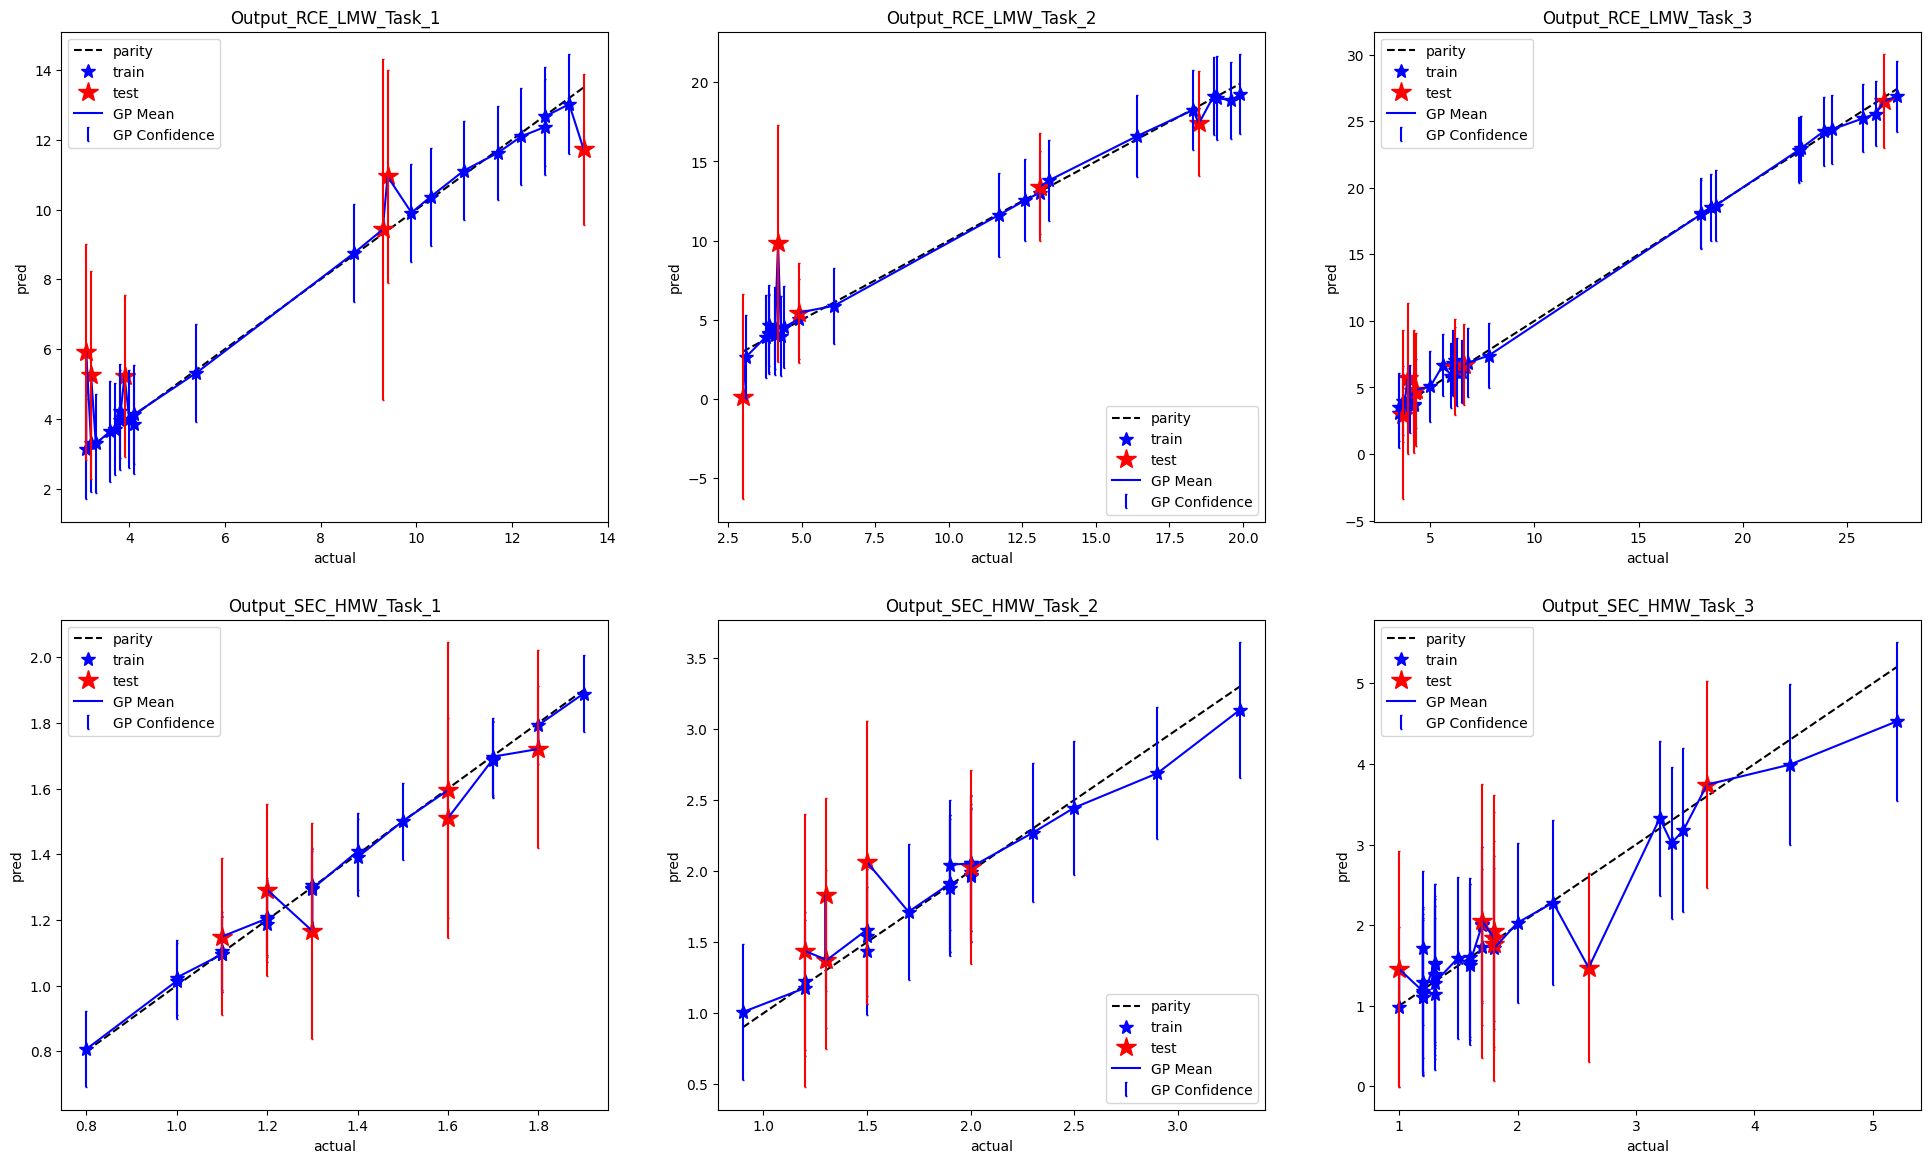

In [44]:
#simpleGP and rf
#if x_scale_option>0:

y_plot_scale_label='no-y-scale'

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = df_y_train.columns

plot_axis_lb = df_y.min(axis = 0) - 0.4* df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4* df_y.std(axis = 0)

num_outputs = len(cols_target)
num_tasks = df_x['task_ind'].unique().shape[0]

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))
cols_target_wide = []

lls_models = []
lls_arr_mean = []

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
f, y_axes = plt.subplots(num_outputs, num_tasks, figsize=(num_tasks*8,num_outputs*7))
y_axes = y_axes.ravel()
for j,col_target in enumerate(cols_target):
  ls_models_target = []
  ls_arr_mean = []
  for task_ind in range(num_tasks):
  
    a = task_ind + num_tasks*j
    #a = j + len(cols_target)*task_ind
    #tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+col_target
    tmp_col_y = 'Output_'+col_target + '_Task_'+str(task_ind+1)
    cols_target_wide.append(tmp_col_y)
    train_task_rows = df_X_train['task_ind'] == task_ind
    test_task_rows = df_X_test['task_ind'] == task_ind
    
    scaled_X_train_task = scaled_X_train[train_task_rows,:-1] #exclude task_ind column
    scaled_X_test_task = scaled_X_test[test_task_rows,:-1]
    df_X_train_task = df_X_train.loc[train_task_rows,df_X_train.columns[:-1]]
    df_X_test_task = df_X_test.loc[test_task_rows,df_X_test.columns[:-1]]
    if x_scale_label != 'no-x-scale':
        t_train_x = torch.Tensor(scaled_X_train_task)
        t_test_x = torch.Tensor(scaled_X_test_task)
    else:
        t_train_x = torch.Tensor(df_X_train_task.to_numpy())
        t_test_x = torch.Tensor(df_X_test_task.to_numpy())

    df_y_train_task = df_y_train.loc[train_task_rows,col_target]
    df_y_test_task = df_y_test.loc[test_task_rows,col_target]

    if model_option == 'rf':
      y_train = df_y_train[tmp_col_y].to_numpy()
      y_true = df_y_test[tmp_col_y].to_numpy()
      mean_train_pred, std_train_pred, mean_test_pred, std_test_pred, _, = rf_sklearn(scaled_X_train,
                                                                                      y_train,
                                                                                      scaled_X_test,
                                                                                      y_true,
                                                                                      cols_feature_new,
                                                                                      tmp_col_y,figPath,
                                                                                      is_plot_imp = False)
      #mean_train = mean_train_pred
      y_pred = mean_test_pred
    elif model_option == 'simpleGP':

      if y_scale_label == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train_task.to_numpy().reshape(-1,1))
      elif y_scale_label == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train_task.to_numpy().reshape(-1,1))
      elif y_scale_label == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train_task.to_numpy().reshape(-1,1))
      else:
        scaled_y_train = df_y_train_task.to_numpy()

      t_train_y = torch.Tensor(scaled_y_train).flatten()
      test_mean,test_lower,test_upper,train_mean,train_lower,train_upper,model = simpleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50)
      ls_models_target.append(model)

      t_test_y = torch.Tensor(df_y_test_task.to_numpy())
      arr_train_x = t_train_x.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()

      if y_scale_label=='no-y-scale':
        arr_train_y = t_train_y.detach().numpy()
        arr_test_mean = test_mean.detach().numpy()
        arr_test_lower = test_lower.detach().numpy()
        arr_test_upper = test_upper.detach().numpy()

        arr_train_mean = train_mean.detach().numpy()
        arr_train_lower = train_lower.detach().numpy()
        arr_train_upper = train_upper.detach().numpy()
      else:
        arr_train_y = y_scaler.inverse_transform(t_train_y.reshape(-1,1))
        arr_train_mean = y_scaler.inverse_transform(train_mean.reshape(-1,1))
        arr_train_lower = y_scaler.inverse_transform(train_lower.reshape(-1,1))
        arr_train_upper = y_scaler.inverse_transform(train_upper.reshape(-1,1))

        arr_test_mean = y_scaler.inverse_transform(test_mean.reshape(-1,1))
        arr_test_lower = y_scaler.inverse_transform(test_lower.reshape(-1,1))
        arr_test_upper = y_scaler.inverse_transform(test_upper.reshape(-1,1))

      ls_arr_mean.append(arr_train_mean)

      y_true = arr_test_y
      y_pred = arr_test_mean
      y_train = arr_train_y
      mean_train_pred = arr_train_mean
      std_train_pred = arr_train_mean - arr_train_lower
      std_test_pred = arr_test_mean - arr_test_lower

    train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
    df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
    df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      #y_axes[a].set_xlim([-2.5,2.5])
      #y_axes[a].set_ylim([-2.5,2.5])
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),6)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(std_test_pred)/np.mean(np.abs(y_true)),2)
    arr_test_metrics[9,a] = round(np.min(std_test_pred)/np.mean(np.abs(y_true)),2)
    arr_test_metrics[10,a] = round(np.max(std_test_pred)/np.mean(np.abs(y_true)),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train_pred),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train_pred),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train_pred),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train_pred),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train_pred),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train_pred),2)
    arr_train_metrics[8,a] = round(np.mean(std_train_pred)/np.mean(np.abs(y_train)),2)
    arr_train_metrics[9,a] = round(np.min(std_train_pred)/np.mean(np.abs(y_train)),2)
    arr_train_metrics[10,a] = round(np.max(std_train_pred)/np.mean(np.abs(y_train)),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']
  lls_models.append(ls_models_target)
  lls_arr_mean.append(ls_arr_mean)

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

## Generate Synthetic Data

In [228]:
from scipy.stats import qmc, norm
#pH_lb_by_buffer_dict = {0:3.7,1:5,2:3.7,3:6.2}
#pH_ub_by_buffer_dict = {0:5.7,1:7,2:5.7,3:8.2}
#buffer_dict = {0:'Ace',1:'His',2:'Cit',3:'Phos'}
task_dict = {0:'1M',1:'2M',2:'3M'}
temp_dict = {0: '5C', 1:'25C',2:'40C'}

np.random.seed(2024)
n_temp_level = df_x['Temperature'].unique().shape[0]
n_met_level = df_x['If_10mM_L_Met'].unique().shape[0]

col_x = 'pH' #pH
col_y = 'Protein_concentration'#'Protein_concentration'

#cols_cont = ['Protein_concentration','Surfactant_concentration','pH']
cols_cont = [col_x,col_y]

l_bounds = df_x[cols_cont].min() - df_x[cols_cont].std()
u_bounds = df_x[cols_cont].max() + df_x[cols_cont].std()
if cols_cont[0] == 'Surfactant_concentration':
        if (l_bounds.iloc[0]<0):
            l_bounds.iloc[0] = 0

if len(cols_cont) > 1:
    if cols_cont[1] == 'Protein_concentration':
        l_bounds.iloc[1] = 0.5
        u_bounds.iloc[1] = 6.5
        #if (l_bounds.iloc[1]<0):
        #    l_bounds.iloc[1] = 0.02


if cols_cont[0] == 'pH':
    l_bounds.iloc[0] = 3.7
    u_bounds.iloc[0] = 5.7

#l_bounds = [3.7,1.0]
#u_bounds = [5.7,6.0]
print(l_bounds)
print(u_bounds)

sampler = qmc.LatinHypercube(d=len(cols_cont)) #numerous columns
n_sample = 100


pH                       3.7
Protein_concentration    0.5
dtype: float64
pH                       5.7
Protein_concentration    6.5
dtype: float64


## Together

In [276]:
from scipy.stats import qmc, norm
#pH_lb_by_buffer_dict = {0:3.7,1:5,2:3.7,3:6.2}
#pH_ub_by_buffer_dict = {0:5.7,1:7,2:5.7,3:8.2}
#buffer_dict = {0:'Ace',1:'His',2:'Cit',3:'Phos'}
task_dict = {1:'1M',2:'2M',3:'3M'}
temp_dict = {0: '5C', 1:'25C',2:'40C'}

np.random.seed(2024)
n_temp_level = df_x['Temperature'].unique().shape[0]
n_met_level = df_x['If_10mM_L_Met'].unique().shape[0]

col_x = 'pH' #pH
col_y = 'Protein_concentration'#'Protein_concentration'
col_t = 'Time_M_'
#cols_cont = ['Protein_concentration','Surfactant_concentration','pH']
cols_cont = [col_x,col_y]

l_bounds = df_x[cols_cont].min()
u_bounds = df_x[cols_cont].max()
if cols_cont[0] == 'Surfactant_concentration':
        if (l_bounds.iloc[0]<0):
            l_bounds.iloc[0] = 0

if len(cols_cont) > 1:
    if cols_cont[1] == 'Protein_concentration':
        l_bounds.iloc[1] = 0.5
        u_bounds.iloc[1] = 6.5
        #if (l_bounds.iloc[1]<0):
        #    l_bounds.iloc[1] = 0.02


if cols_cont[0] == 'pH':
    l_bounds.iloc[0] = 3.7
    u_bounds.iloc[0] = 5.7


l_bound_t,u_bound_t = 0.0, 4.0

print(l_bounds)
print(u_bounds)

sampler = qmc.LatinHypercube(d=len(cols_cont)) #numerous columns
sampler_t = qmc.LatinHypercube(d=1) #for time factor
n_sample = 100


pH                       3.7
Protein_concentration    0.5
dtype: float64
pH                       5.7
Protein_concentration    6.5
dtype: float64


### Consider Time separately

In [ ]:
from matplotlib import cm
import pickle


ls_df_X_syn_bt = []
ls_df_y_syn_bt = []
ls_df_X_syn_bt_mesh = []

plot_target_ind = 1


#df_X_recom['If_10mM_L_Met_label'] = 1
temp_label_idx = 2

plot_type = 'contour'#surface#contour
scale_type = 'custom' #uniform#custom
my_min = 0.0
my_max = 27.0#7.0(5C)#26(40C)#7.5(25C)

if plot_type == 'contour':
    if scale_type == 'uniform':
        contour_levels = np.linspace(my_min, my_max, 20)
    else:
        contour_levels = 20

#

recom_conds2 = (df_x['pH']==5.0) & (df_x['If_10mM_L_Met'] == 1)&(df_x['Surfactant_concentration'] == 0.02) & (df_x['Temperature'] == temp_label_idx)
df_X_recom2 = df_x[recom_conds2]
df_y_recom2 = df_y[recom_conds2]



for task_idx in task_dict:
                recom_conds1 = (df_X_train['pH']==5.0) & (df_X_train['Protein_concentration']==4.0)&(df_X_train['Surfactant_concentration'] == 0.02) & (df_X_train['Temperature'] == temp_label_idx)
                df_X_recom1 = df_X_train[recom_conds1]
                df_y_recom1 = df_y_train[recom_conds1]

                df_X_recom1['If_10mM_L_Met'] = 1
                df_X_recom1['Time_M_'] = task_idx
                scaled_X_recom=xct.transform(df_X_recom1)
                t_recom_x = torch.Tensor(scaled_X_recom) #exclude task_ind column
#for task_idx in range(2,3):
    #for temp_label_idx in range(n_temp_level):
                print('===============task'+str(task_idx)+'==========:')
                row_conds = (df_X_train['Time_M_']==task_idx)
                df_X_train_bt = df_X_train[row_conds]
                df_y_train_bt = df_y_train[row_conds][cols_target[plot_target_ind]]
                df_Xy_train_bt = pd.concat([df_X_train_bt,df_y_train_bt],axis = 1)
                df_Xy_train_bt.index = range(len(df_Xy_train_bt))
                #new_train_mean =  (arr_train_mean[row_conds,1] + arr_train_mean[row_conds,0])*(-1) #lmw + hmw
                #new_train_mean =  arr_train_mean[row_conds,plot_target_ind]*(-1) #lmw + hmw
                new_train_mean =  lls_arr_mean[plot_target_ind][row_conds]*(-1)
                best_train_idx_bt = np.argmax(new_train_mean)
                print('==Among training data==')
                with pd.option_context('display.float_format', '{:0.2f}'.format):
                        print(df_X_train_bt.iloc[best_train_idx_bt,:])
                
                
                sample = sampler.random(n=n_sample)
                sample_scaled = qmc.scale(sample, l_bounds.values, u_bounds.values)
                df_X_syn_bt = pd.DataFrame(index = range(n_sample))
               
                #df_X_syn_bt['Protein_concentration'] =  df_X_train_bt.iloc[best_train_idx_bt,0] #4 #df_X_train_bt.iloc[best_train_idx_bt,0]
                df_X_syn_bt[cols_cont] = sample_scaled
                df_X_syn_bt['Surfactant_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,1] #0.02
                #df_X_syn_bt['pH'] = df_X_train_bt.iloc[best_train_idx_bt,2] #5.0
                #df_X_syn_bt['Temperature_label'] = df_X_train_bt.iloc[best_train_idx_bt,3]
                df_X_syn_bt['Temperature'] = temp_label_idx
                #df_X_syn_bt['Time_M_'] = df_X_train_bt.iloc[best_train_idx_bt,3] 
                #df_X_syn_bt['If_10mM_L_Met_label'] = df_X_train_bt.iloc[best_train_idx_bt,4]
                df_X_syn_bt['If_10mM_L_Met'] = np.random.choice(range(n_met_level),n_sample)#1
                #df_X_syn_bt['task_ind'] = task_idx
                
                #reorder df_X_syn_bt columns
                df_X_syn_bt = df_X_syn_bt[df_X_train_bt.columns]
                #add recommended optimal formulation to plot points
                df_X_syn_bt.loc[len(df_X_syn_bt)] = [4.0, 0.02,
       temp_label_idx, 0.0, 1.0, 5.0] #[''Protein_concentration', 'Surfactant_concentration', 'Temperature',
       #'Time_M_', 'If_10mM_L_Met', 'pH']
                df_X_syn_bt.loc[len(df_X_syn_bt)] = [4.0, 0.02,
       temp_label_idx, 1.0, 1.0, 5.0]
                df_X_syn_bt.loc[len(df_X_syn_bt)] = [4.0, 0.02,
       temp_label_idx, 2.0, 1.0, 5.0]
            
                #add training to plot points
                df_X_syn_bt = pd.concat([df_X_train_bt,df_X_syn_bt],axis = 0)
                df_X_syn_bt.reset_index(inplace = True, drop= True)
                
                mesh_x = df_X_syn_bt[col_x].sort_values()
                mesh_y = df_X_syn_bt[col_y].sort_values()
                X,Y = np.meshgrid(mesh_x, mesh_y)
                df_X_syn_bt_mesh = pd.DataFrame(columns=df_X_syn_bt.columns,index = range(X.shape[0]*X.shape[1]))

                #df_X_syn_bt_mesh['Protein_concentration'] = 4.0#df_X_train_bt.iloc[best_train_idx_bt,0] #4.0
                df_X_syn_bt_mesh[col_x] = np.ravel(X)
                df_X_syn_bt_mesh[col_y] = np.ravel(Y)
                #df_X_syn_bt_mesh['pH'] = 5.0 #df_X_train_bt.iloc[best_train_idx_bt,2] #5.0
                #df_X_syn_bt_mesh['Surfactant_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,1] #0.02
                df_X_syn_bt_mesh['Surfactant_concentration'] = 0.02
                df_X_syn_bt_mesh['Temperature'] = temp_label_idx
                df_X_syn_bt_mesh['Time_M_'] = task_idx#df_X_train_bt.iloc[best_train_idx_bt,3] 
                #df_X_syn_bt_mesh['Temperature_label'] = df_X_train_bt.iloc[best_train_idx_bt,3]
                df_X_syn_bt_mesh['If_10mM_L_Met'] = 1#df_X_train_bt.iloc[best_train_idx_bt,4]
                #df_X_syn_bt_mesh['task_ind'] = task_idx
                #df_X_syn_bt_mesh = df_X_syn_bt_mesh.sort_values(by=['pH','Protein_concentration'])
    
                scaled_X_syn=xct.transform(df_X_syn_bt_mesh)
                t_syn_x = torch.Tensor(scaled_X_syn)

                model = lls_models[plot_target_ind]
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                        syn_pred = model(t_syn_x)
                        syn_mean = syn_pred.mean
                        syn_lower, syn_upper = syn_pred.confidence_region()
                        recom_pred = model(t_recom_x)
                        recom_mean = recom_pred.mean
                        recom_lower, recom_upper = recom_pred.confidence_region()
                y_scaler = ls_y_scaler[plot_target_ind]
                arr_syn_x = t_syn_x.detach().numpy()
                arr_syn_mean = y_scaler.inverse_transform(syn_mean.reshape(-1,1))
                arr_syn_lower = y_scaler.inverse_transform(syn_lower.reshape(-1,1))
                arr_syn_upper = y_scaler.inverse_transform(syn_upper.reshape(-1,1))
                #df_y_syn_bt = pd.DataFrame(arr_syn_mean,columns=df_y_train.columns)
                df_y_syn_bt = pd.DataFrame(arr_syn_mean,columns=[cols_target[plot_target_ind]])
        

                arr_recom_mean = y_scaler.inverse_transform(recom_mean.reshape(-1,1))
                arr_recom_lower = y_scaler.inverse_transform(recom_lower.reshape(-1,1))
                arr_recom_upper = y_scaler.inverse_transform(recom_upper.reshape(-1,1))
                arr_recom_x = t_recom_x.detach().numpy()
                

                #calculate expected improvement
                #new_syn_mean =  (arr_syn_mean[:,1] + arr_syn_mean[:,0])*(-1)
                new_syn_mean =  (arr_syn_mean)*(-1)
                y_std = np.mean(arr_syn_upper - arr_syn_mean,axis = 1)
                df_y_syn_bt['err'] = y_std
                z = (new_syn_mean - new_train_mean[best_train_idx_bt])/y_std.reshape(-1,1)
                ei = (new_syn_mean - new_train_mean[best_train_idx_bt])*norm.cdf(z) + y_std.reshape(-1,1)*norm.pdf(z)
                df_y_syn_bt['ei'] = ei

                ls_df_X_syn_bt.append(df_X_syn_bt)
                ls_df_y_syn_bt.append(df_y_syn_bt)
                ls_df_X_syn_bt_mesh.append(df_X_syn_bt_mesh)

                print('==After simulation==')
                
                best_syn_idx = np.argmax(new_syn_mean)
                
                with pd.option_context('display.float_format', '{:0.2f}'.format):
                        print(df_X_syn_bt_mesh.iloc[best_syn_idx,:])


                # Plot the surrogate model
                col_target = cols_target[plot_target_ind]
                
                x = df_X_syn_bt_mesh[col_x]
                y = df_X_syn_bt_mesh[col_y]
                r = df_y_syn_bt[col_target].values
                R = r.reshape(X.shape)
                
                my_cmap = plt.cm.get_cmap('RdYlGn_r')
                
                #Plot sampled points
                act_conds_task = (df_X_recom2['Time_M_']==task_idx)
                df_plot_act= df_X_recom2[act_conds_task]
                #df_plot_act=df_X_recom2
                if len(df_plot_act)>0:
                    df_plot_act['z'] = df_y_recom2[col_target]
                    xa = df_plot_act[col_x].values
                    ya = df_plot_act[col_y].values
                    za = df_plot_act['z'].values
                    tempa = df_plot_act['Temperature'].values
                
                
                recom_conds_task = (df_X_syn_bt_mesh['pH']==5.0) & (df_X_syn_bt_mesh['Protein_concentration']==4.0)&(df_X_syn_bt_mesh['Surfactant_concentration'] == 0.02)&(df_X_syn_bt_mesh['If_10mM_L_Met'] == 1.0)
                df_plot_recom = df_X_syn_bt_mesh[recom_conds_task]
                df_plot_recom['z'] = df_y_syn_bt[recom_conds_task][col_target]
                """
                recom_conds_task = (df_X_recom1['task_ind']==task_idx)
                df_X_recom_bt= df_X_recom1[recom_conds_task]
                df_plot_recom = df_X_recom_bt
                df_plot_recom['z'] = arr_recom_mean[recom_conds_task,plot_target_ind]
                """
                

                xr = df_plot_recom[col_x].values
                yr = df_plot_recom[col_y].values
                zr = df_plot_recom['z'].values
                tempr = df_plot_recom['Temperature'].values	

                if scale_type != 'uniform':
                    if len(df_plot_act)>0:
                        z_min = min(df_plot_recom['z'].min(),R.min(),df_plot_act['z'].min())
                        z_max = max(df_plot_recom['z'].max(),R.max(),df_plot_act['z'].max())
                    else:
                        z_min = min(df_plot_recom['z'].min(),R.min())
                        z_max = max(df_plot_recom['z'].max(),R.max())
                else:
                    z_min = my_min
                    z_max = my_max
                
                if plot_type != 'contour':
                    fig = plt.figure(figsize=(25, 25))
                    ax = plt.axes(projection ='3d')
                
                    surf = ax.plot_surface(X, Y, R, cmap=my_cmap, alpha=0.5,
                       linewidth=0, antialiased=False, label = 'Surrogate Model')
                    
                    scatter_act =ax.scatter(xa, ya, za,s = 150,c = 'black',label = 'Actual Formulations')
                    for i in range(len(df_plot_act)):
                        scatter_label = temp_dict[tempa[i]]+ ',' + 'Conc '+str(int(ya[i]))+ ',' + col_target[-3:]+' '+str(round(za[i],2))
                        #ax.text(xa[i]+0.1, ya[i]+0.5*tempa[i], za[i], scatter_label,fontsize = 25)
                        if ya[i] == 6:
                            ax.text(xa[i] + 0.2, ya[i]-0*tempa[i], za[i], scatter_label,fontsize = 25)
                        else:
                            ax.text(xa[i] + 0.2, ya[i]-1.2*tempa[i], za[i], scatter_label,fontsize = 25)
                
                
                    scatter_recom = ax.scatter(xr, yr, zr,
                           s = 300,marker = '*',c = 'blue',label = 'Proposed Formulations')
                
                    for i in range(len(df_plot_recom)):
                        scatter_label = temp_dict[tempr[i]]+ ',' + 'Conc '+str(int(yr[i]))+ ','+ col_target[-3:]+' '+ str(round(zr[i],2))
                        #scatter_label = str(round(zr[i],2))
                        ax.text(xr[i]-0.2, yr[i]+1*tempr[i], zr[i], scatter_label,fontsize = 25,color='blue')
                    
                    cbar = fig.colorbar(surf)
                    cbar.mappable.set_clim(vmin=z_min,vmax=z_max) #this works
                    cbar.ax.tick_params(labelsize=25)
                    

                    ax.tick_params(axis='both', which='major', labelsize=25)
                    ax.tick_params(axis='z', which='major', labelsize=25)
                    ax.tick_params(axis='z', which='major', pad=10)
                    ax.tick_params(axis='x', which='major', pad=5)
                    ax.tick_params(axis='y', which='major', pad=5)
                    ax.set_xlabel(col_x,fontsize=28, labelpad=30)
                    ax.set_ylabel(col_y,fontsize=28, labelpad=20)
                    ax.set_zlabel(col_target,fontsize=28, labelpad=30)
                    ax.set_zlim(z_max, z_min)
                    
                else:
                    fig = plt.figure(figsize=(20, 16))
                    #ax = plt.axes()
                    if scale_type == 'uniform':
                        cont = plt.contourf(X, Y, R, cmap=my_cmap, levels = contour_levels)
                    else:
                        cont = plt.contourf(X, Y, R, cmap=my_cmap, levels = contour_levels)
    
                    if len(df_plot_act)>0:
                        scatter_act =plt.scatter(xa, ya, s = 150,c = 'black',label = 'Actual Formulations')
                        for i in range(len(df_plot_act)):
                            scatter_label = temp_dict[tempa[i]]+ ',' + 'Conc '+str(int(ya[i]))+ ',' + col_target[-3:]+' '+str(round(za[i],2))
                            #ax.text(xa[i]+0.1, ya[i]+0.5*tempa[i], za[i], scatter_label,fontsize = 25)
                            plt.text(xa[i]-0.1, ya[i], scatter_label,fontsize = 25)
                
                
                    scatter_recom = plt.scatter(xr, yr,
                           s = 300,marker = '*',c = 'blue',label = 'Proposed Formulations')
                
                    for i in range(len(df_plot_recom)):
                        scatter_label = temp_dict[tempr[i]]+ ',' + 'Conc '+str(int(yr[i]))+ ','+ col_target[-3:]+' '+ str(round(zr[i],2))
                        #scatter_label = str(round(zr[i],2))
                        plt.text(xr[i]-0.1, yr[i], scatter_label,fontsize = 25,color='blue')

                    cbar = plt.colorbar(cont)
                    cbar.ax.tick_params(labelsize=25)
                    plt.tick_params(axis='both', which='major', labelsize=25, pad=5)
                    plt.xlabel(col_x,fontsize=28, labelpad=30)
                    #plt.ylabel('Protein_concentration',fontsize=28, labelpad=20)
                    plt.ylabel(col_y,fontsize=28, labelpad=30)
                
                
                
                
                
                str_title1 = col_target + ' ' +plot_type + ' Under ' + temp_dict[temp_label_idx] + task_dict[task_idx]
                str_title2 = col_target + ' ' +plot_type + ' Under ' + temp_dict[temp_label_idx] + task_dict[task_idx]+ scale_type + col_x + col_y
                plt.title(str_title1, fontsize = 30)
                plt.legend(fontsize = 28)
                
                

                
                file_name = '/'+str_title2 + '.png'
                plt.savefig(figPath+file_name)
               

                """
                # Serialize the variable and save it to a file
                
                save_file_x = '/ls_df_X_syn_bt' + col_target + task_dict[task_idx] + temp_dict[temp_label_idx]
                save_file_y = '/ls_df_y_syn_bt' + col_target + task_dict[task_idx] + temp_dict[temp_label_idx]
                save_file_x_mesh = '/ls_df_X_syn_bt_mesh' + col_target + task_dict[task_idx] + temp_dict[temp_label_idx]
                with open(figPath+save_file_x+'.pkl', 'wb') as file1:
                    pickle.dump(ls_df_X_syn_bt, file1)
                with open(figPath+save_file_y+'.pkl', 'wb') as file2:
                    pickle.dump(ls_df_y_syn_bt, file2)
                with open(figPath+save_file_x_mesh+'.pkl', 'wb') as file3:
                    pickle.dump(ls_df_X_syn_bt_mesh, file3)
                """
                
df_X_syn = pd.concat(ls_df_X_syn_bt)
df_y_syn = pd.concat(ls_df_y_syn_bt)

### Plot different times on the same plot

In [384]:
from scipy.stats import qmc, norm
#pH_lb_by_buffer_dict = {0:3.7,1:5,2:3.7,3:6.2}
#pH_ub_by_buffer_dict = {0:5.7,1:7,2:5.7,3:8.2}
#buffer_dict = {0:'Ace',1:'His',2:'Cit',3:'Phos'}
task_dict = {0:'0M',1:'1M',2:'2M',3:'3M'}
temp_dict = {0:'5C',1:'25C',2:'40C'}

np.random.seed(2024)
n_temp_level = df_x['Temperature'].unique().shape[0]
n_met_level = df_x['If_10mM_L_Met'].unique().shape[0]

n_time_level = len(task_dict)

col_x = 'pH' #pH
col_y = 'Protein_concentration'#'Protein_concentration'
#col_y = 'Time_M_'

cols_cont = [col_x,col_y]

l_bounds = df_x[cols_cont].min()
u_bounds = df_x[cols_cont].max()



if cols_cont[0] == 'pH':
    l_bounds.iloc[0] = 3.7
    u_bounds.iloc[0] = 5.7

if cols_cont[0] == 'Protein_concentration':
    l_bounds.iloc[0] = 0.5
    u_bounds.iloc[0] = 6.5


if cols_cont[1] == 'Protein_concentration':
    l_bounds.iloc[1] = 0.5
    u_bounds.iloc[1] = 6.5


if cols_cont[1] == 'Time_M_':
    l_bounds.iloc[1] = 0.0
    u_bounds.iloc[1] = n_time_level - 1


print(l_bounds)
print(u_bounds)

sampler = qmc.LatinHypercube(d=len(cols_cont)) #numerous columns
#sampler_t = qmc.LatinHypercube(d=1) #for time factor
n_sample = 100#2#100

is_normalize_hmw = True


pH                       3.7
Protein_concentration    0.5
dtype: float64
pH                       5.7
Protein_concentration    6.5
dtype: float64


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap = plt.cm.get_cmap('RdYlGn_r')
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


===============target: SEC_HMW ==========:
===============Temperature5C==========:
==Among training data==
Protein_concentration      6.00
Surfactant_concentration   0.02
Temperature                0.00
Time_M_                    3.00
If_10mM_L_Met              0.00
pH                         4.50
Name: 85, dtype: float64
==After simulation==
Protein_concentration      5.47
Surfactant_concentration   0.02
Temperature                0.00
Time_M_                    1.00
If_10mM_L_Met              1.00
pH                         4.52
Name: 8693, dtype: float64
===============Temperature25C==========:
==Among training data==
Protein_concentration      6.00
Surfactant_concentration   0.02
Temperature                1.00
Time_M_                    2.00
If_10mM_L_Met              0.00
pH                         4.50
Name: 73, dtype: float64
==After simulation==
Protein_concentration      4.65
Surfactant_concentration   0.02
Temperature                1.00
Time_M_                    1.00
If_10

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_act['z'] = df_y_recom2[col_target]
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:213: SettingWithCop

===============Temperature40C==========:
==Among training data==
Protein_concentration      6.00
Surfactant_concentration   0.02
Temperature                2.00
Time_M_                    1.00
If_10mM_L_Met              0.00
pH                         4.50
Name: 67, dtype: float64
==After simulation==
Protein_concentration      2.11
Surfactant_concentration   0.02
Temperature                2.00
Time_M_                    1.00
If_10mM_L_Met              1.00
pH                         4.52
Name: 2823, dtype: float64


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_act['z'] = df_y_recom2[col_target]
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_65790/2041102992.py:213: SettingWithCop

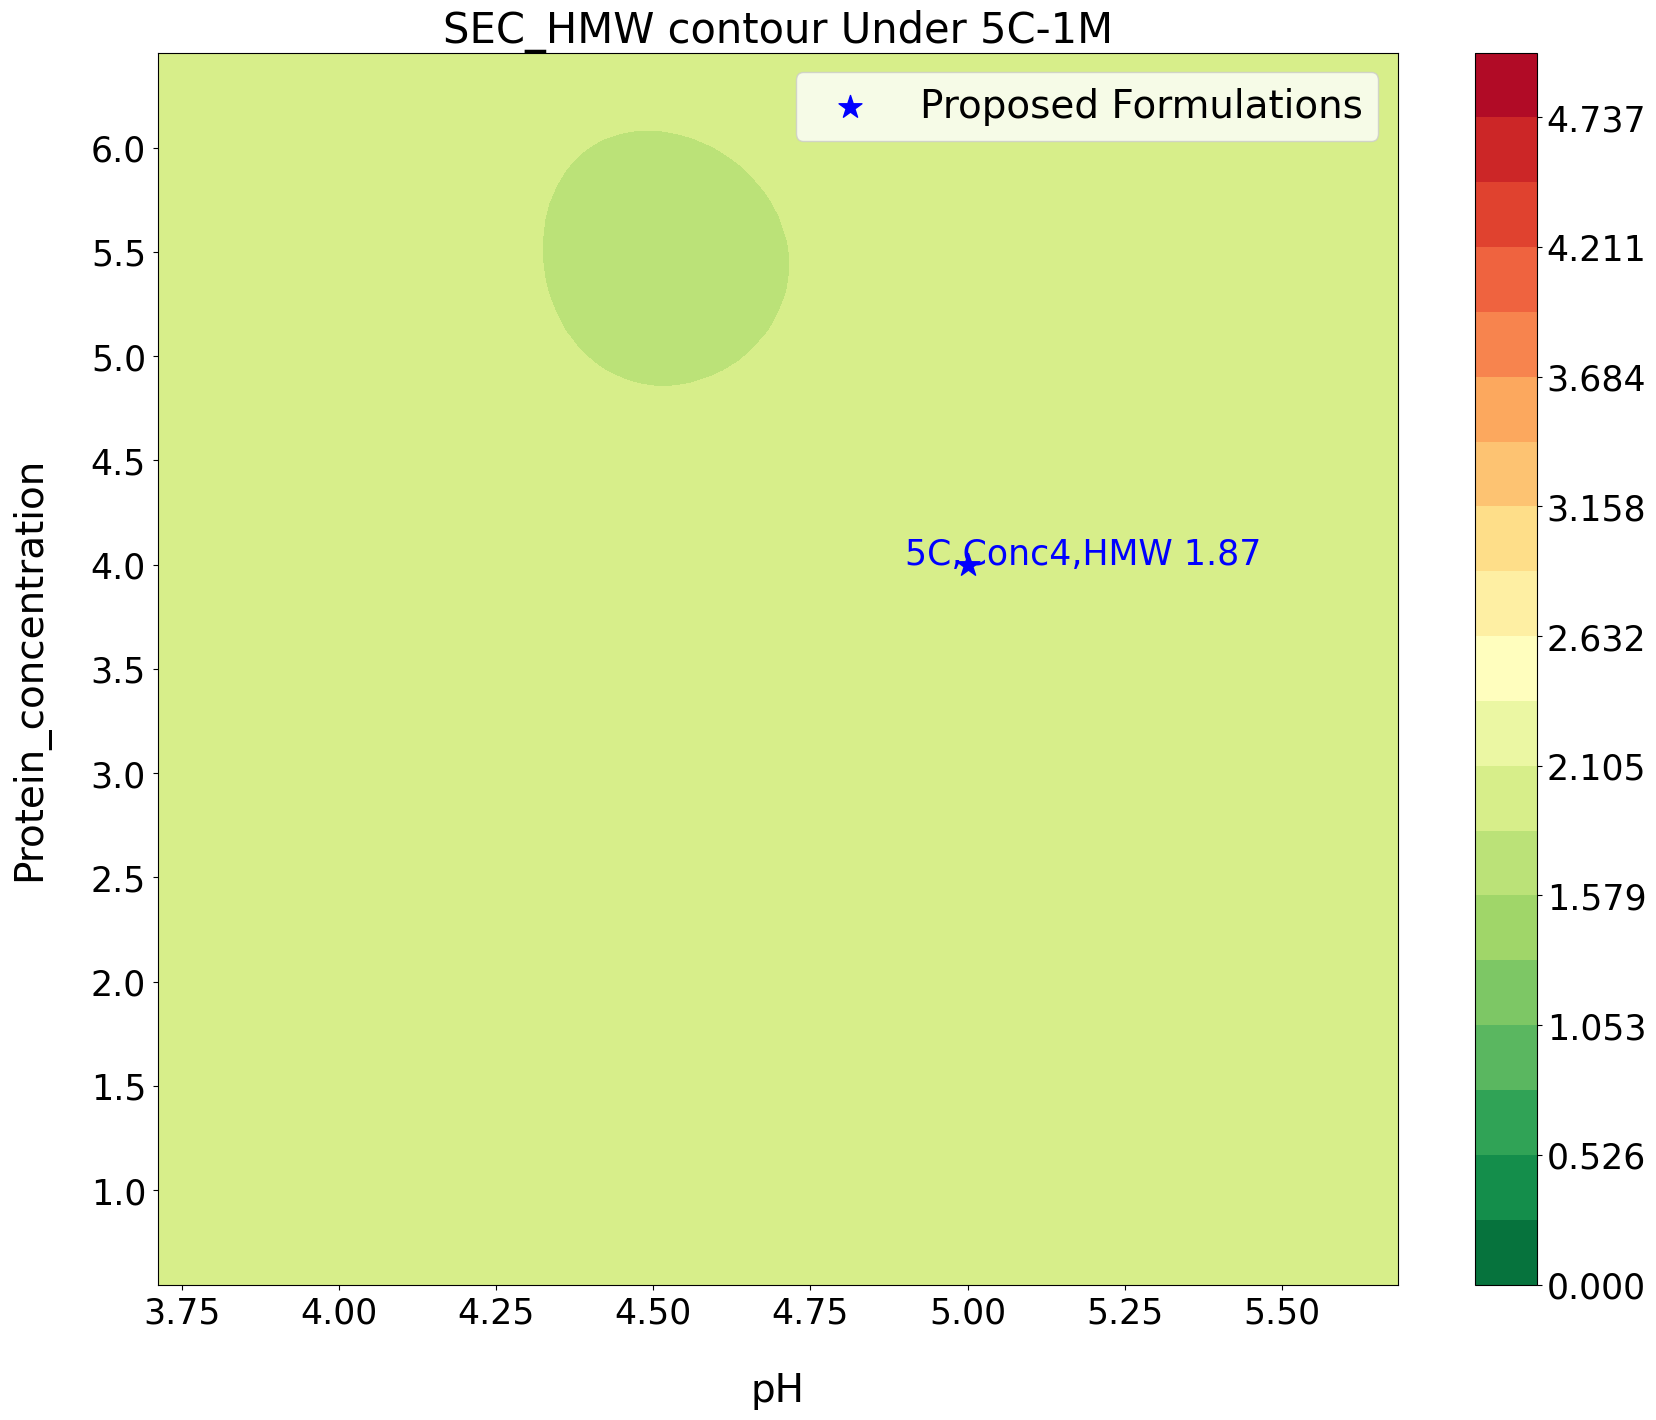

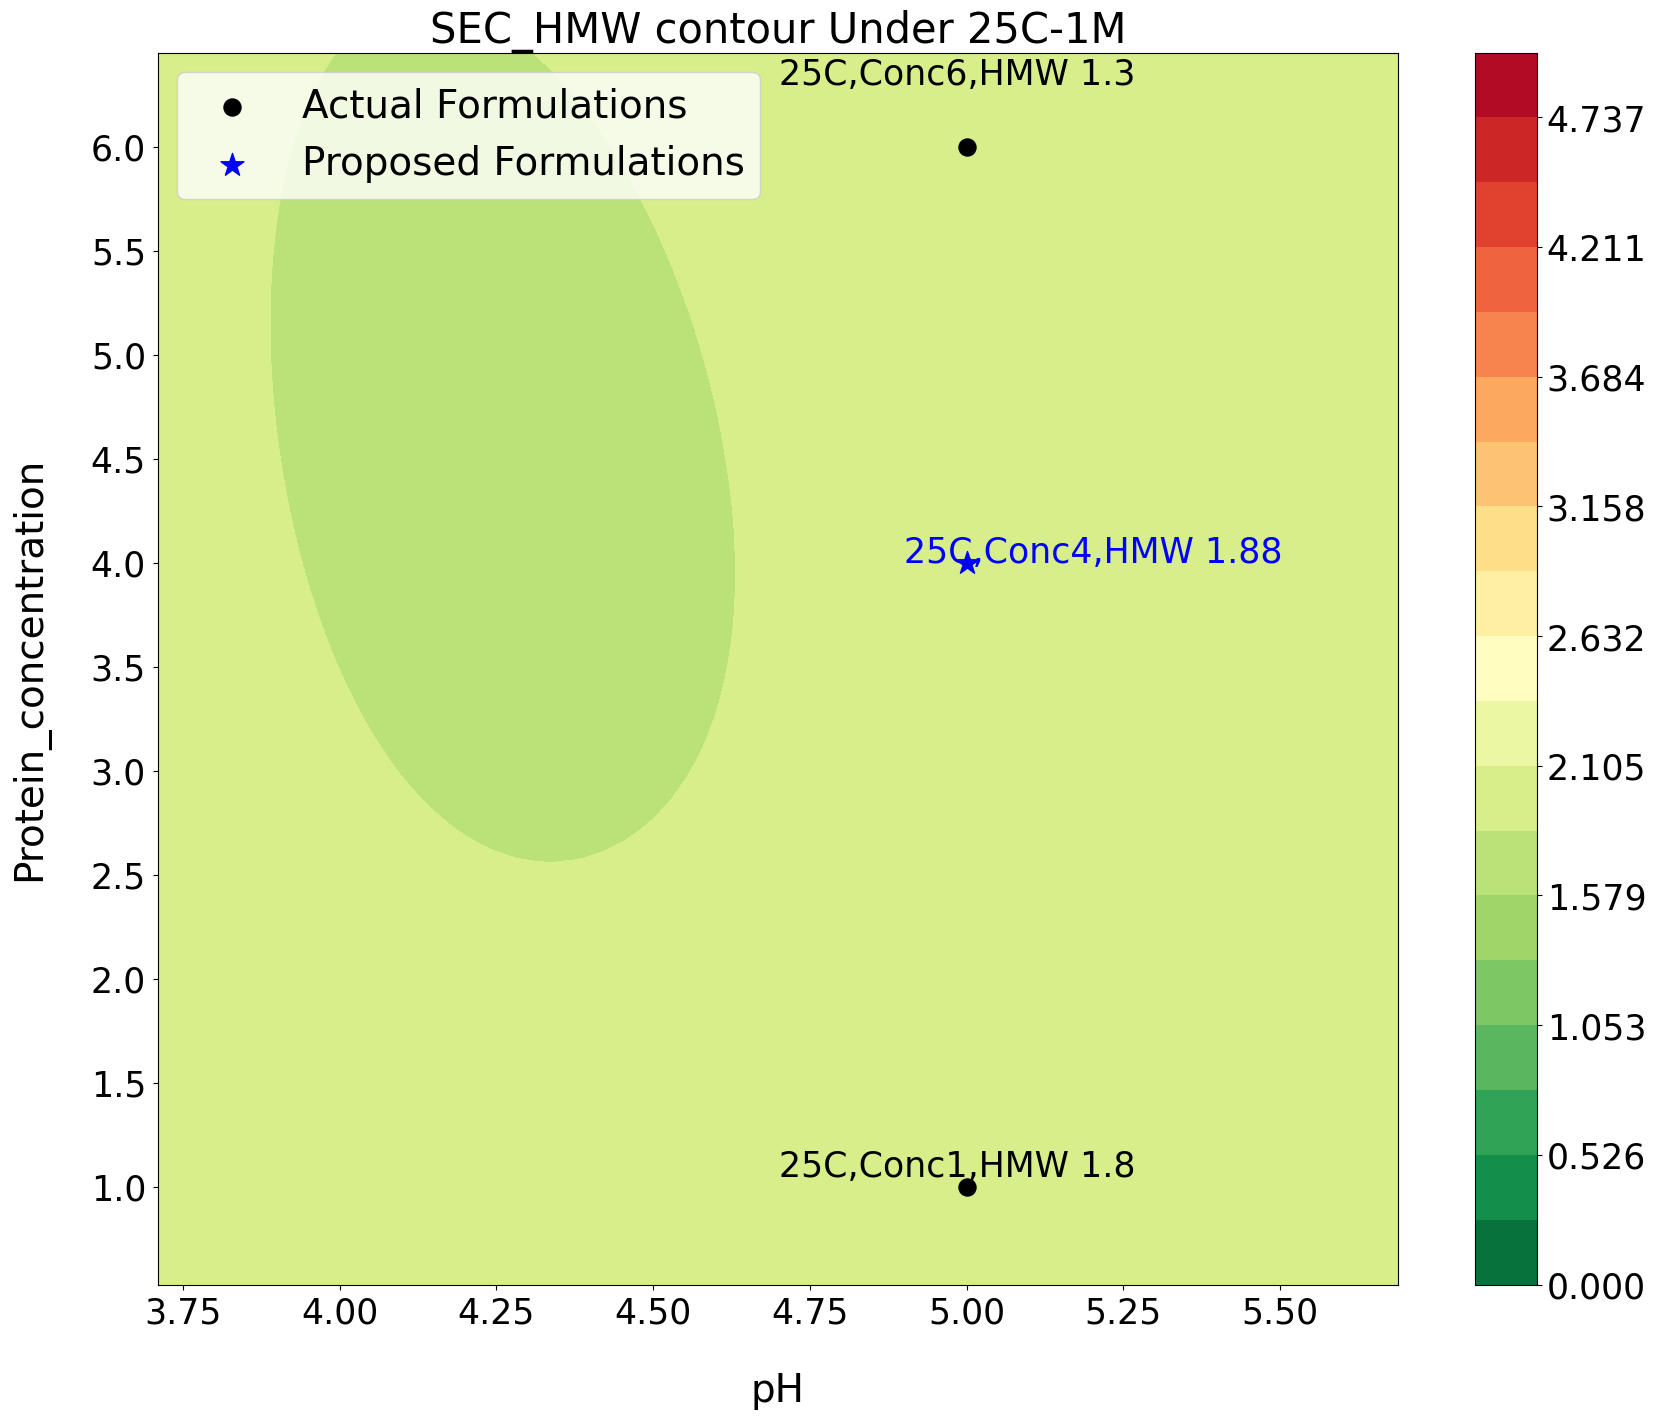

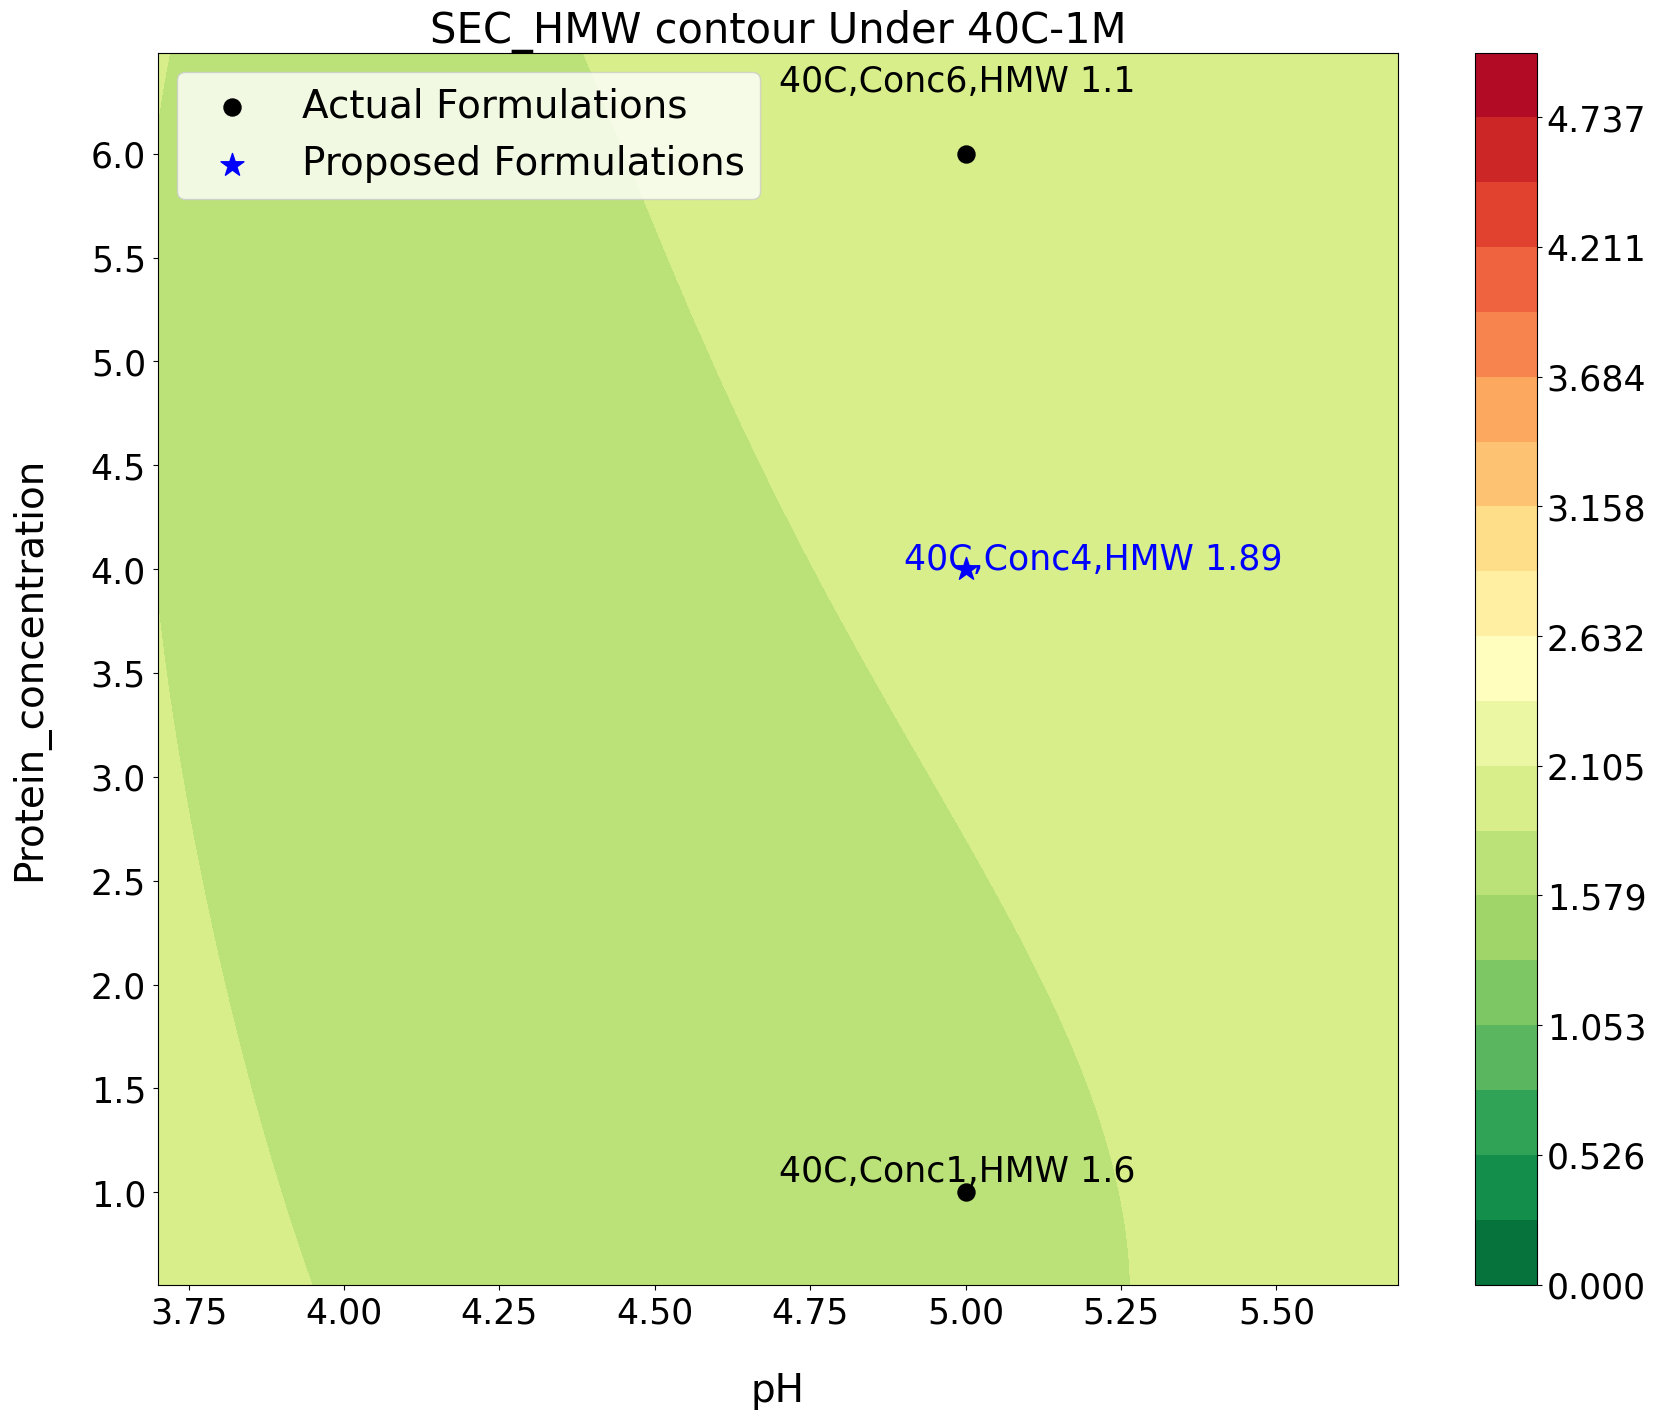

In [389]:
from matplotlib import cm
import pickle
my_cmap = plt.cm.get_cmap('RdYlGn_r')

ls_df_X_syn_bt = []
ls_df_y_syn_bt = []
ls_df_X_syn_bt_mesh = []

#plot_target_ind = 0
#temp_label_idx = 2

plot_type = 'contour'#surface#contour
scale_type = 'uniform' #uniform#custom
my_min = 0.0
#my_max = 10.0#7.0(5C)#26(40C)#7.5(25C)
my_max = 5.0

if plot_type == 'contour':
    if scale_type == 'uniform':
        contour_levels = np.linspace(my_min, my_max, 20)
    else:
        contour_levels = 20




for plot_target_ind in range(1,2):
    col_target = cols_target[plot_target_ind]
    print('===============target: '+col_target +' ==========:')
    model = lls_models[plot_target_ind]

    for temp_label_idx in range(n_temp_level):
    #for temp_label_idx in range(1,2):
            #for task_idx in task_dict:
                task_idx = 1
                print('===============Temperature'+temp_dict[temp_label_idx]+'==========:')
                row_conds = (df_X_train['Temperature']==temp_label_idx)
                df_X_train_bt = df_X_train[row_conds]
                df_y_train_bt = df_y_train[row_conds][col_target]
                df_Xy_train_bt = pd.concat([df_X_train_bt,df_y_train_bt],axis = 1)
                df_Xy_train_bt.index = range(len(df_Xy_train_bt))
                new_train_mean =  lls_arr_mean[plot_target_ind][row_conds]*(-1)
                best_train_idx_bt = np.argmax(new_train_mean)
                print('==Among training data==')
                with pd.option_context('display.float_format', '{:0.2f}'.format):
                        print(df_X_train_bt.iloc[best_train_idx_bt,:])
                
                
                sample = sampler.random(n=n_sample)
                sample_scaled = qmc.scale(sample, l_bounds.values, u_bounds.values)
                df_X_syn_bt = pd.DataFrame(index = range(n_sample))
               
                df_X_syn_bt[cols_cont] = sample_scaled
                if col_x == 'pH' and col_y!='Protein_concentration':
                    df_X_syn_bt['Protein_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,0]
                elif col_x == 'Protein_concentration' and col_y!='pH':
                     df_X_syn_bt['pH'] = df_X_train_bt.iloc[best_train_idx_bt,5]
                df_X_syn_bt['Surfactant_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,1] #0.02
                df_X_syn_bt['Temperature'] = temp_label_idx
                df_X_syn_bt['If_10mM_L_Met'] = 1#np.random.choice(range(n_met_level),n_sample)#1
                if col_y != 'Time_M_':
                    df_X_syn_bt['Time_M_'] = task_idx
                #reorder df_X_syn_bt columns
                df_X_syn_bt = df_X_syn_bt[df_X_train_bt.columns]
            
                #add training to plot points
                df_X_syn_bt = pd.concat([df_X_train_bt,df_X_syn_bt],axis = 0)
                df_X_syn_bt.reset_index(inplace = True, drop= True)
                
                mesh_x = df_X_syn_bt[col_x].sort_values().unique()
                mesh_y = df_X_syn_bt[col_y].sort_values().unique()
                
                X,Y= np.meshgrid(mesh_x, mesh_y)
                df_X_syn_bt_mesh = pd.DataFrame(columns=df_X_syn_bt.columns,index = range(X.shape[0]*X.shape[1]))

                
                df_X_syn_bt_mesh[col_x] = np.ravel(X)
                df_X_syn_bt_mesh[col_y] = np.ravel(Y)
                
                
                if col_x == 'pH' and col_y!='Protein_concentration':
                    df_X_syn_bt_mesh['Protein_concentration'] = 4.0#4.0
                elif col_x == 'Protein_concentration' and col_y!='pH':
                     df_X_syn_bt_mesh['pH'] = 5.0
                df_X_syn_bt_mesh['Surfactant_concentration'] = 0.02
                df_X_syn_bt_mesh['Temperature'] = temp_label_idx
                
                df_X_syn_bt_mesh['If_10mM_L_Met'] = 1#df_X_train_bt.iloc[best_train_idx_bt,4]
                if col_y != 'Time_M_':
                    df_X_syn_bt_mesh['Time_M_'] = task_idx
                

                df_X_syn_bt_mesh_copy1,df_X_syn_bt_mesh_copy2 = df_X_syn_bt_mesh.copy(),df_X_syn_bt_mesh.copy()
                #df_X_syn_bt_mesh_copy1['Temperature'] = 0
                df_X_syn_bt_mesh_copy1['Time_M_'] = 0
                df_X_syn_bt_mesh_copy1['Protein_concentration'] = 1
                #df_X_syn_bt_mesh_copy2['Temperature'] = 0
                df_X_syn_bt_mesh_copy2['Time_M_'] = 0

                scaled_X_syn=xct.transform(df_X_syn_bt_mesh)
                t_syn_x = torch.Tensor(scaled_X_syn)
                scaled_X_syn_copy1=xct.transform(df_X_syn_bt_mesh_copy1)
                t_syn_x_copy1 = torch.Tensor(scaled_X_syn_copy1)
                scaled_X_syn_copy2=xct.transform(df_X_syn_bt_mesh_copy2)
                t_syn_x_copy2 = torch.Tensor(scaled_X_syn_copy2)

                
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    syn_pred = model(t_syn_x)
                    syn_mean = syn_pred.mean
                    syn_lower, syn_upper = syn_pred.confidence_region()

                    if col_target == 'SEC_HMW':
                        syn_pred_copy1 = model_hmw(t_syn_x_copy1)  
                        syn_mean_copy1 = syn_pred_copy1.mean
                        syn_lower_copy1, syn_upper_copy1 = syn_pred_copy1.confidence_region()
                        syn_pred_copy2 =  model_hmw(t_syn_x_copy2)  
                        syn_mean_copy2 = syn_pred_copy2.mean
                        syn_lower_copy2, syn_upper_copy2 = syn_pred_copy2.confidence_region()

                y_scaler = ls_y_scaler[plot_target_ind]
                arr_syn_x = t_syn_x.detach().numpy()
                arr_syn_mean = y_scaler.inverse_transform(syn_mean.reshape(-1,1))
                arr_syn_lower = y_scaler.inverse_transform(syn_lower.reshape(-1,1))
                arr_syn_upper = y_scaler.inverse_transform(syn_upper.reshape(-1,1))
                if is_normalize_hmw and col_target == 'SEC_HMW':
                                arr_syn_mean_copy1 = y_scaler.inverse_transform(syn_mean_copy1.reshape(-1,1))
                                arr_syn_lower_copy1 = y_scaler.inverse_transform(syn_lower_copy1.reshape(-1,1))
                                arr_syn_upper_copy1 = y_scaler.inverse_transform(syn_upper_copy1.reshape(-1,1))

                                arr_syn_mean_copy2 = y_scaler.inverse_transform(syn_mean_copy2.reshape(-1,1))
                                arr_syn_lower_copy2 = y_scaler.inverse_transform(syn_lower_copy2.reshape(-1,1))
                                arr_syn_upper_copy2 = y_scaler.inverse_transform(syn_upper_copy2.reshape(-1,1))

                                arr_syn_mean = arr_syn_mean +  arr_syn_mean_copy1 -  arr_syn_mean_copy2
                                arr_syn_lower = arr_syn_lower +  arr_syn_lower_copy1 -  arr_syn_lower_copy2
                                arr_syn_upper = arr_syn_upper +  arr_syn_upper_copy1 -  arr_syn_upper_copy2
                df_y_syn_bt = pd.DataFrame(arr_syn_mean,columns=[cols_target[plot_target_ind]])
        

                #calculate expected improvement
                new_syn_mean =  (arr_syn_mean)*(-1)
                y_std = np.mean(arr_syn_upper - arr_syn_mean,axis = 1)
                df_y_syn_bt['err'] = y_std
                z = (new_syn_mean - new_train_mean[best_train_idx_bt])/y_std.reshape(-1,1)
                ei = (new_syn_mean - new_train_mean[best_train_idx_bt])*norm.cdf(z) + y_std.reshape(-1,1)*norm.pdf(z)
                df_y_syn_bt['ei'] = ei

                ls_df_X_syn_bt.append(df_X_syn_bt)
                ls_df_y_syn_bt.append(df_y_syn_bt)
                ls_df_X_syn_bt_mesh.append(df_X_syn_bt_mesh)

                print('==After simulation==')
                
                best_syn_idx = np.argmax(new_syn_mean)
                
                with pd.option_context('display.float_format', '{:0.2f}'.format):
                        print(df_X_syn_bt_mesh.iloc[best_syn_idx,:])


                
                col_target = cols_target[plot_target_ind]
                
                x = df_X_syn_bt_mesh[col_x]
                y = df_X_syn_bt_mesh[col_y]
                r = df_y_syn_bt[col_target].values
                R = r.reshape(X.shape)
                
                

                recom_conds2 = (df_x['pH']==5.0) & (df_x['If_10mM_L_Met'] == 1)&(df_x['Surfactant_concentration'] == 0.02) & (df_x['Temperature'] == temp_label_idx)
                df_X_recom2 = df_x[recom_conds2]
                df_y_recom2 = df_y[recom_conds2]

                df_X_recom2_copy1,df_X_recom2_copy2 = df_X_recom2.copy(),df_X_recom2.copy()
                scaled_X_recom2_copy1=xct.transform(df_X_recom2_copy1)
                t_recom2_x_copy1 = torch.Tensor(scaled_X_recom2_copy1)
                scaled_X_recom2_copy2=xct.transform(df_X_recom2_copy2)
                t_recom2_x_copy2 = torch.Tensor(scaled_X_recom2_copy2)
                
                #update 'SEC_HMW' in df_y_recom2
                model_hmw = lls_models[1]
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                        recom2_pred_copy1 =  model_hmw(t_recom2_x_copy1)  
                        recom2_mean_copy1 = recom2_pred_copy1.mean
                        recom2_lower_copy1, recom2_upper_copy1 = recom2_pred_copy1.confidence_region()
                        recom2_pred_copy2 =  model_hmw(t_recom2_x_copy2)  
                        recom2_mean_copy2 = recom2_pred_copy2.mean
                        recom2_lower_copy2, recom2_upper_copy2 = recom2_pred_copy2.confidence_region()
                if is_normalize_hmw:
                        df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()
                
                #Plot sampled points
                if col_y != 'Time_M_':
                    act_conds_task = (df_X_recom2['Time_M_']==task_idx)
                    df_plot_act= df_X_recom2[act_conds_task]
                else:
                    df_plot_act=df_X_recom2
                if len(df_plot_act)>0:
                    df_plot_act['z'] = df_y_recom2[col_target]
                    xa = df_plot_act[col_x].values
                    ya = df_plot_act[col_y].values
                    za = df_plot_act['z'].values
                    tempa = df_plot_act['Temperature'].values
                    proconca = df_plot_act['Protein_concentration'].values
                    pha = df_plot_act['pH'].values
                
                

                recom_conds1 = (df_X_train['pH']==5.0) & (df_X_train['Protein_concentration']==4.0)&(df_X_train['Surfactant_concentration'] == 0.02) & (df_X_train['Temperature'] == temp_label_idx)
                df_X_recom1 = df_X_train[recom_conds1]
                df_y_recom1 = df_y_train[recom_conds1]
                df_X_recom1['If_10mM_L_Met'] = 1
                
                
                
                df_X_recom1_row = df_X_recom1.iloc[[0]]
                df_X_recom1_repeat = df_X_recom1_row.loc[df_X_recom1_row.index.repeat(n_time_level)]
                df_X_recom1_repeat.reset_index(inplace = True, drop = True)
                df_X_recom1_repeat['Time_M_'] = range(n_time_level)
                #df_plot_recom = df_X_recom1_repeat
                df_X_recom1_repeat_copy1,df_X_recom1_repeat_copy2 = df_X_recom1_repeat.copy(),df_X_recom1_repeat.copy()
                df_X_recom1_repeat_copy1['Protein_concentration'] = 1
                #df_X_recom1_repeat_copy1['Temperature'] = 0
                #df_X_recom1_repeat_copy2['Temperature'] = 0
                df_X_recom1_repeat_copy1['Time_M_'] = 0
                df_X_recom1_repeat_copy2['Time_M_'] = 0
                scaled_X_recom=xct.transform(df_X_recom1_repeat)
                scaled_X_recom_copy1=xct.transform(df_X_recom1_repeat_copy1)
                scaled_X_recom_copy2=xct.transform(df_X_recom1_repeat_copy2)
                """
                else:
                                df_plot_recom = df_X_recom1
                                df_X_recom1_copy1,df_X_recom1_copy2 = df_X_recom1.copy(),df_X_recom1.copy()
                                df_X_recom1_copy1['Protein_concentration'] = 1
                                #df_X_recom1_copy1['Temperature'] = 0
                                #df_X_recom1_copy2['Temperature'] = 0
                                df_X_recom1_copy1['Time_M_'] = 0
                                df_X_recom1_copy2['Time_M_'] = 0
                                scaled_X_recom=xct.transform(df_X_recom1)
                                scaled_X_recom_copy1=xct.transform(df_X_recom1_copy1)
                                scaled_X_recom_copy2=xct.transform(df_X_recom1_copy2)
                """

                t_recom_x = torch.Tensor(scaled_X_recom)
                # = t_recom_x.detach().numpy()

                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    recom_pred = model(t_recom_x)
                    recom_mean = recom_pred.mean
                    recom_lower, recom_upper = recom_pred.confidence_region()

                    arr_recom_mean = y_scaler.inverse_transform(recom_mean.reshape(-1,1))
                    arr_recom_lower = y_scaler.inverse_transform(recom_lower.reshape(-1,1))
                    arr_recom_upper = y_scaler.inverse_transform(recom_upper.reshape(-1,1)) 

                    if col_target == 'SEC_HMW':
                                t_recom_x_copy1 = torch.Tensor(scaled_X_recom_copy1)
                                t_recom_x_copy2 = torch.Tensor(scaled_X_recom_copy2)

                                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                                        recom_pred_copy1 =  model_hmw(t_recom_x_copy1)
                                        recom_pred_copy2 =  model_hmw(t_recom_x_copy2)
                                recom_mean_copy1 = recom_pred_copy1.mean
                                recom_mean_copy2 = recom_pred_copy2.mean
                                recom_lower_copy1, recom_upper_copy1 = recom_pred_copy1.confidence_region()
                                recom_lower_copy2, recom_upper_copy2 = recom_pred_copy2.confidence_region()

                                arr_recom_mean_copy1 = y_scaler.inverse_transform(recom_mean_copy1.reshape(-1,1))
                                arr_recom_lower_copy1 = y_scaler.inverse_transform(recom_lower_copy1.reshape(-1,1))
                                arr_recom_upper_copy1 = y_scaler.inverse_transform(recom_upper_copy1.reshape(-1,1)) 

                                arr_recom_mean_copy2 = y_scaler.inverse_transform(recom_mean_copy2.reshape(-1,1))
                                arr_recom_lower_copy2 = y_scaler.inverse_transform(recom_lower_copy2.reshape(-1,1))
                                arr_recom_upper_copy2 = y_scaler.inverse_transform(recom_upper_copy2.reshape(-1,1)) 

                                arr_recom_mean = arr_recom_mean + arr_recom_mean_copy1 - arr_recom_mean_copy2
                                arr_recom_lower = arr_recom_lower + arr_recom_lower_copy1 - arr_recom_lower_copy2
                                arr_recom_upper = arr_recom_upper + arr_recom_upper_copy1 - arr_recom_upper_copy2
                
                #if col_y == 'Time_M_':
                #df_plot_recom = df_X_recom1_repeat
                #df_plot_recom['z'] = arr_recom_mean
                #else:
                df_plot_recom = df_X_recom1_repeat[df_X_recom1_repeat['Time_M_']==task_idx]
                df_plot_recom['z'] = arr_recom_mean[df_X_recom1_repeat['Time_M_']==task_idx]

                xr = df_plot_recom[col_x].values
                yr = df_plot_recom[col_y].values
                zr = df_plot_recom['z'].values
                tempr = df_plot_recom['Temperature'].values
                proconcr = df_plot_recom['Protein_concentration'].values

                if scale_type != 'uniform':
                    if len(df_plot_act)>0:
                        z_min = min(df_plot_recom['z'].min(),R.min(),df_plot_act['z'].min())
                        z_max = max(df_plot_recom['z'].max(),R.max(),df_plot_act['z'].max())
                    else:
                        z_min = min(df_plot_recom['z'].min(),R.min())
                        z_max = max(df_plot_recom['z'].max(),R.max())
                else:
                    z_min = my_min
                    z_max = my_max
                
                if plot_type != 'contour':
                    fig = plt.figure(figsize=(25, 25))
                    ax = plt.axes(projection ='3d')
                
                    surf = ax.plot_surface(X, Y, R, cmap=my_cmap, alpha=0.5,
                       linewidth=0, antialiased=False, label = 'Surrogate Model')
                    
                    scatter_act =ax.scatter(xa, ya, za,s = 150,c = 'black',label = 'Actual Formulations')
                    for i in range(len(df_plot_act)):
                        scatter_label = temp_dict[tempa[i]]+ ',' + 'Conc '+str(int(ya[i]))+ ',' + col_target[-3:]+' '+str(round(za[i],2))
                        #ax.text(xa[i]+0.1, ya[i]+0.5*tempa[i], za[i], scatter_label,fontsize = 25)
                        if proconca[i] == 6:
                            ax.text(xa[i] + 0.2, proconca[i]-0*tempa[i], za[i], scatter_label,fontsize = 25)
                        else:
                            ax.text(xa[i] + 0.2, proconca[i]-1.2*tempa[i], za[i], scatter_label,fontsize = 25)
                
                
                    scatter_recom = ax.scatter(xr, yr, zr,
                           s = 300,marker = '*',c = 'blue',label = 'Proposed Formulations')
                
                    for i in range(len(df_plot_recom)):
                        scatter_label = temp_dict[tempr[i]]+ ',' + 'Conc '+str(int(yr[i]))+ ','+ col_target[-3:]+' '+ str(round(zr[i],2))
                        #scatter_label = str(round(zr[i],2))
                        ax.text(xr[i]-0.2, yr[i]+1*tempr[i], zr[i], scatter_label,fontsize = 25,color='blue')
                    
                    cbar = fig.colorbar(surf)
                    cbar.mappable.set_clim(vmin=z_min,vmax=z_max) #this works
                    cbar.ax.tick_params(labelsize=25)
                    

                    ax.tick_params(axis='both', which='major', labelsize=25)
                    ax.tick_params(axis='z', which='major', labelsize=25)
                    ax.tick_params(axis='z', which='major', pad=10)
                    ax.tick_params(axis='x', which='major', pad=5)
                    ax.tick_params(axis='y', which='major', pad=5)
                    ax.set_xlabel(col_x,fontsize=28, labelpad=30)
                    ax.set_ylabel(col_y,fontsize=28, labelpad=20)
                    ax.set_zlabel(col_target,fontsize=28, labelpad=30)
                    ax.set_zlim(z_max, z_min)
                    
                else:
                    fig = plt.figure(figsize=(20, 16))
                    if scale_type == 'uniform':
                        cont = plt.contourf(X, Y, R, cmap=my_cmap, levels = contour_levels)
                    else:
                        cont = plt.contourf(X, Y, R, cmap=my_cmap, levels = contour_levels)
    
                    if len(df_plot_act)>0:
                        scatter_act =plt.scatter(xa, ya, s = 150,c = 'black',label = 'Actual Formulations')
                        for i in range(len(df_plot_act)):
                            if col_y != 'Protein_concentration':
                                scatter_label = temp_dict[tempa[i]]+ ',' + 'Conc' +str(int(proconca[i]))+ ','+ col_y+str(int(ya[i]))+ ',' + col_target[-3:]+' '+str(round(za[i],2))
                            else:
                                scatter_label = temp_dict[tempa[i]]+ ',' + 'Conc' +str(int(proconca[i]))+ ',' + col_target[-3:]+' '+str(round(za[i],2))
                           
                            if col_x == 'pH':
                                plt.text(xa[i]-0.3, ya[i]+0.05*proconca[i], scatter_label,fontsize = 25)
                            elif col_x == 'Protein_concentration':
                                plt.text(xa[i], ya[i]+0.05*proconca[i], scatter_label,fontsize = 25)
                
                
                    scatter_recom = plt.scatter(xr, yr,
                           s = 300,marker = '*',c = 'blue',label = 'Proposed Formulations')
                
                    for i in range(len(df_plot_recom)):
                        if col_y != 'Protein_concentration':
                            scatter_label = temp_dict[tempr[i]]+ ',' + 'Conc' +str(int(proconcr[i]))+ ','+ col_y+str(int(yr[i]))+ ','+ col_target[-3:]+' '+ str(round(zr[i],2))
                        else:
                            scatter_label = temp_dict[tempr[i]]+ ',' + 'Conc' +str(int(proconcr[i]))+ ','+ col_target[-3:]+' '+ str(round(zr[i],2))
                        plt.text(xr[i]-0.1, yr[i], scatter_label,fontsize = 25,color='blue')

                    cbar = plt.colorbar(cont)
                    cbar.ax.tick_params(labelsize=25)
                    plt.tick_params(axis='both', which='major', labelsize=25, pad=5)
                    #plt.yticks(np.arange(z_min, z_max, tick_spacing))
                    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(tick_spacing))
                    plt.xlabel(col_x,fontsize=28, labelpad=30)
                    #plt.ylabel('Protein_concentration',fontsize=28, labelpad=20)
                    plt.ylabel(col_y,fontsize=28, labelpad=30)
                
                
                
                
                if col_y != 'Time_M_':
                    str_title1 = col_target + ' ' +plot_type + ' Under ' + temp_dict[temp_label_idx] + '-' +task_dict[task_idx]
                    str_title2 = col_target + ' ' +plot_type + ' Under ' + temp_dict[temp_label_idx] + '-'+ task_dict[task_idx] + scale_type + col_x + col_y
                else:
                    str_title1 = col_target + ' ' +plot_type + ' Under ' + temp_dict[temp_label_idx]
                    str_title2 = col_target + ' ' +plot_type + ' Under ' + temp_dict[temp_label_idx] + scale_type + col_x + col_y
                plt.title(str_title1, fontsize = 30)
                plt.legend(fontsize = 28)
                
                

                
                file_name = '/'+str_title2 + '.png'
                plt.savefig(figPath+file_name)
                
df_X_syn = pd.concat(ls_df_X_syn_bt)
df_y_syn = pd.concat(ls_df_y_syn_bt)

## Double y plot

In [27]:
from matplotlib import cm

from scipy.stats import qmc, norm

is_normalize_hmw = True
n_sample = 100


task_dict = {0:'0M',1:'1M',2:'2M',3:'3M'}
temp_dict = {0:'5C',1:'25C',2:'40C'}

np.random.seed(2024)
n_temp_level = df_x['Temperature'].unique().shape[0]
n_met_level = df_x['If_10mM_L_Met'].unique().shape[0]


ls_df_X_syn_bt = []
ls_df_y_syn_bt = []
#plot_target_ind = 0
ls_colors = ['b','r']

col_x = 'Surfactant_concentration'
#col_x = 'pH'
#col_x = 'Protein_concentration'
#col_x = 'Time_M_'
#temp_label_idx = 1

sampler_2d = qmc.LatinHypercube(d=1) #numerous columns
if col_x == 'pH':
    l_bound = 4.0#3.7
    u_bound = 5.5#5.7

if col_x == 'Protein_concentration':
    l_bound = 0.5
    u_bound = 6.5

if col_x == 'Surfactant_concentration':
    l_bound = 0.01
    u_bound = 0.11


if col_x == 'Time_M_':
    l_bound = 0.0
    u_bound = 4.0
#



df_X_train_bt = df_X_train
df_y_train_bt = df_y_train
df_Xy_train_bt = pd.concat([df_X_train_bt,df_y_train_bt],axis = 1)
df_Xy_train_bt.index = range(len(df_Xy_train_bt))

plot_target_ind = 0                
new_train_mean =  lls_arr_mean[plot_target_ind]*(-1)
best_train_idx_bt = np.argmax(new_train_mean)
print('==Among training data==')
with pd.option_context('display.float_format', '{:0.2f}'.format):
        print(df_X_train_bt.iloc[best_train_idx_bt,:])

==Among training data==
Protein_concentration      6.00
Surfactant_concentration   0.02
Temperature                0.00
Time_M_                    0.00
If_10mM_L_Met              0.00
pH                         5.50
Name: 44, dtype: float64


In [25]:
PH_OPT = 5.0
PROT_OPT = 4.0 #2.5
PROT_CURRENT = 4.0
SURF_OPT = 0.06
SURF_CURRENT = 0.02
L_Met_OPT = 1.0

===============temp5C==========:
==After simulation==
==After simulation==


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X_recom1[col_x] = SURF_OPT
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:206: SettingWithCopyWarning: 
A val

===============temp25C==========:
==After simulation==
==After simulation==


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X_recom1[col_x] = SURF_OPT
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:206: SettingWithCopyWarning: 
A val

===============temp40C==========:
==After simulation==
==After simulation==


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X_recom1[col_x] = SURF_OPT
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_6448/1904445133.py:206: SettingWithCopyWarning: 
A val

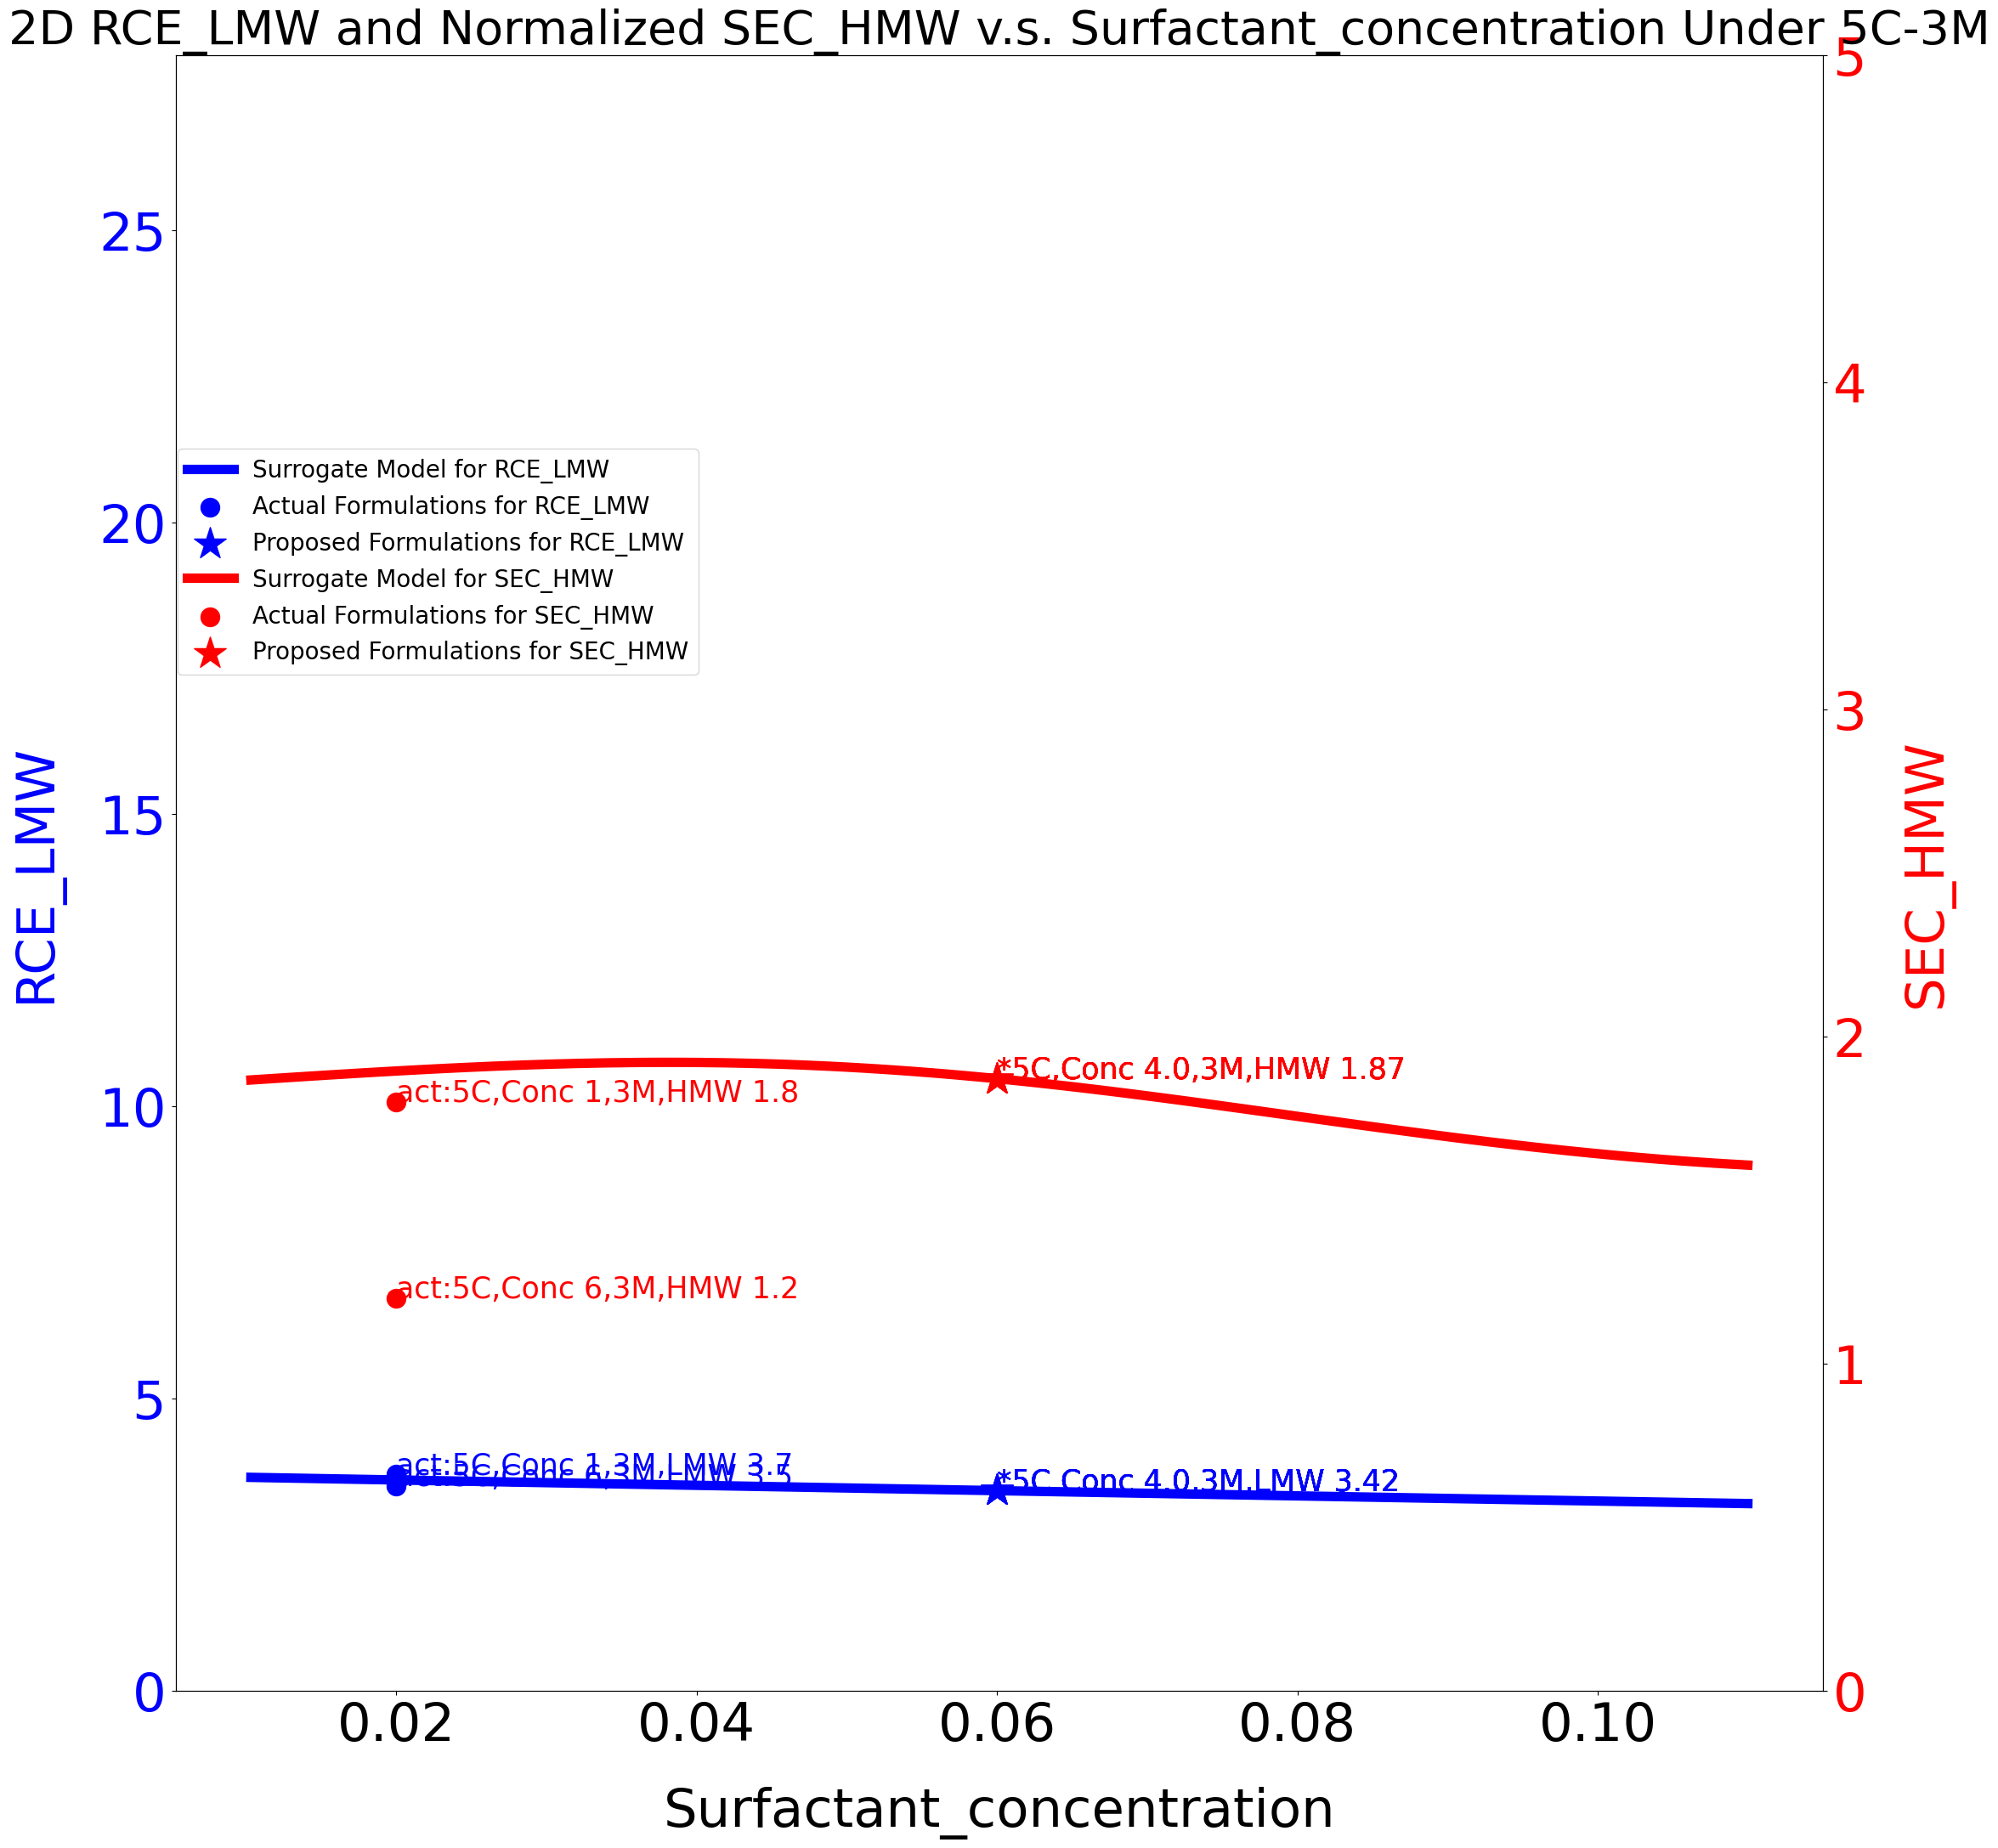

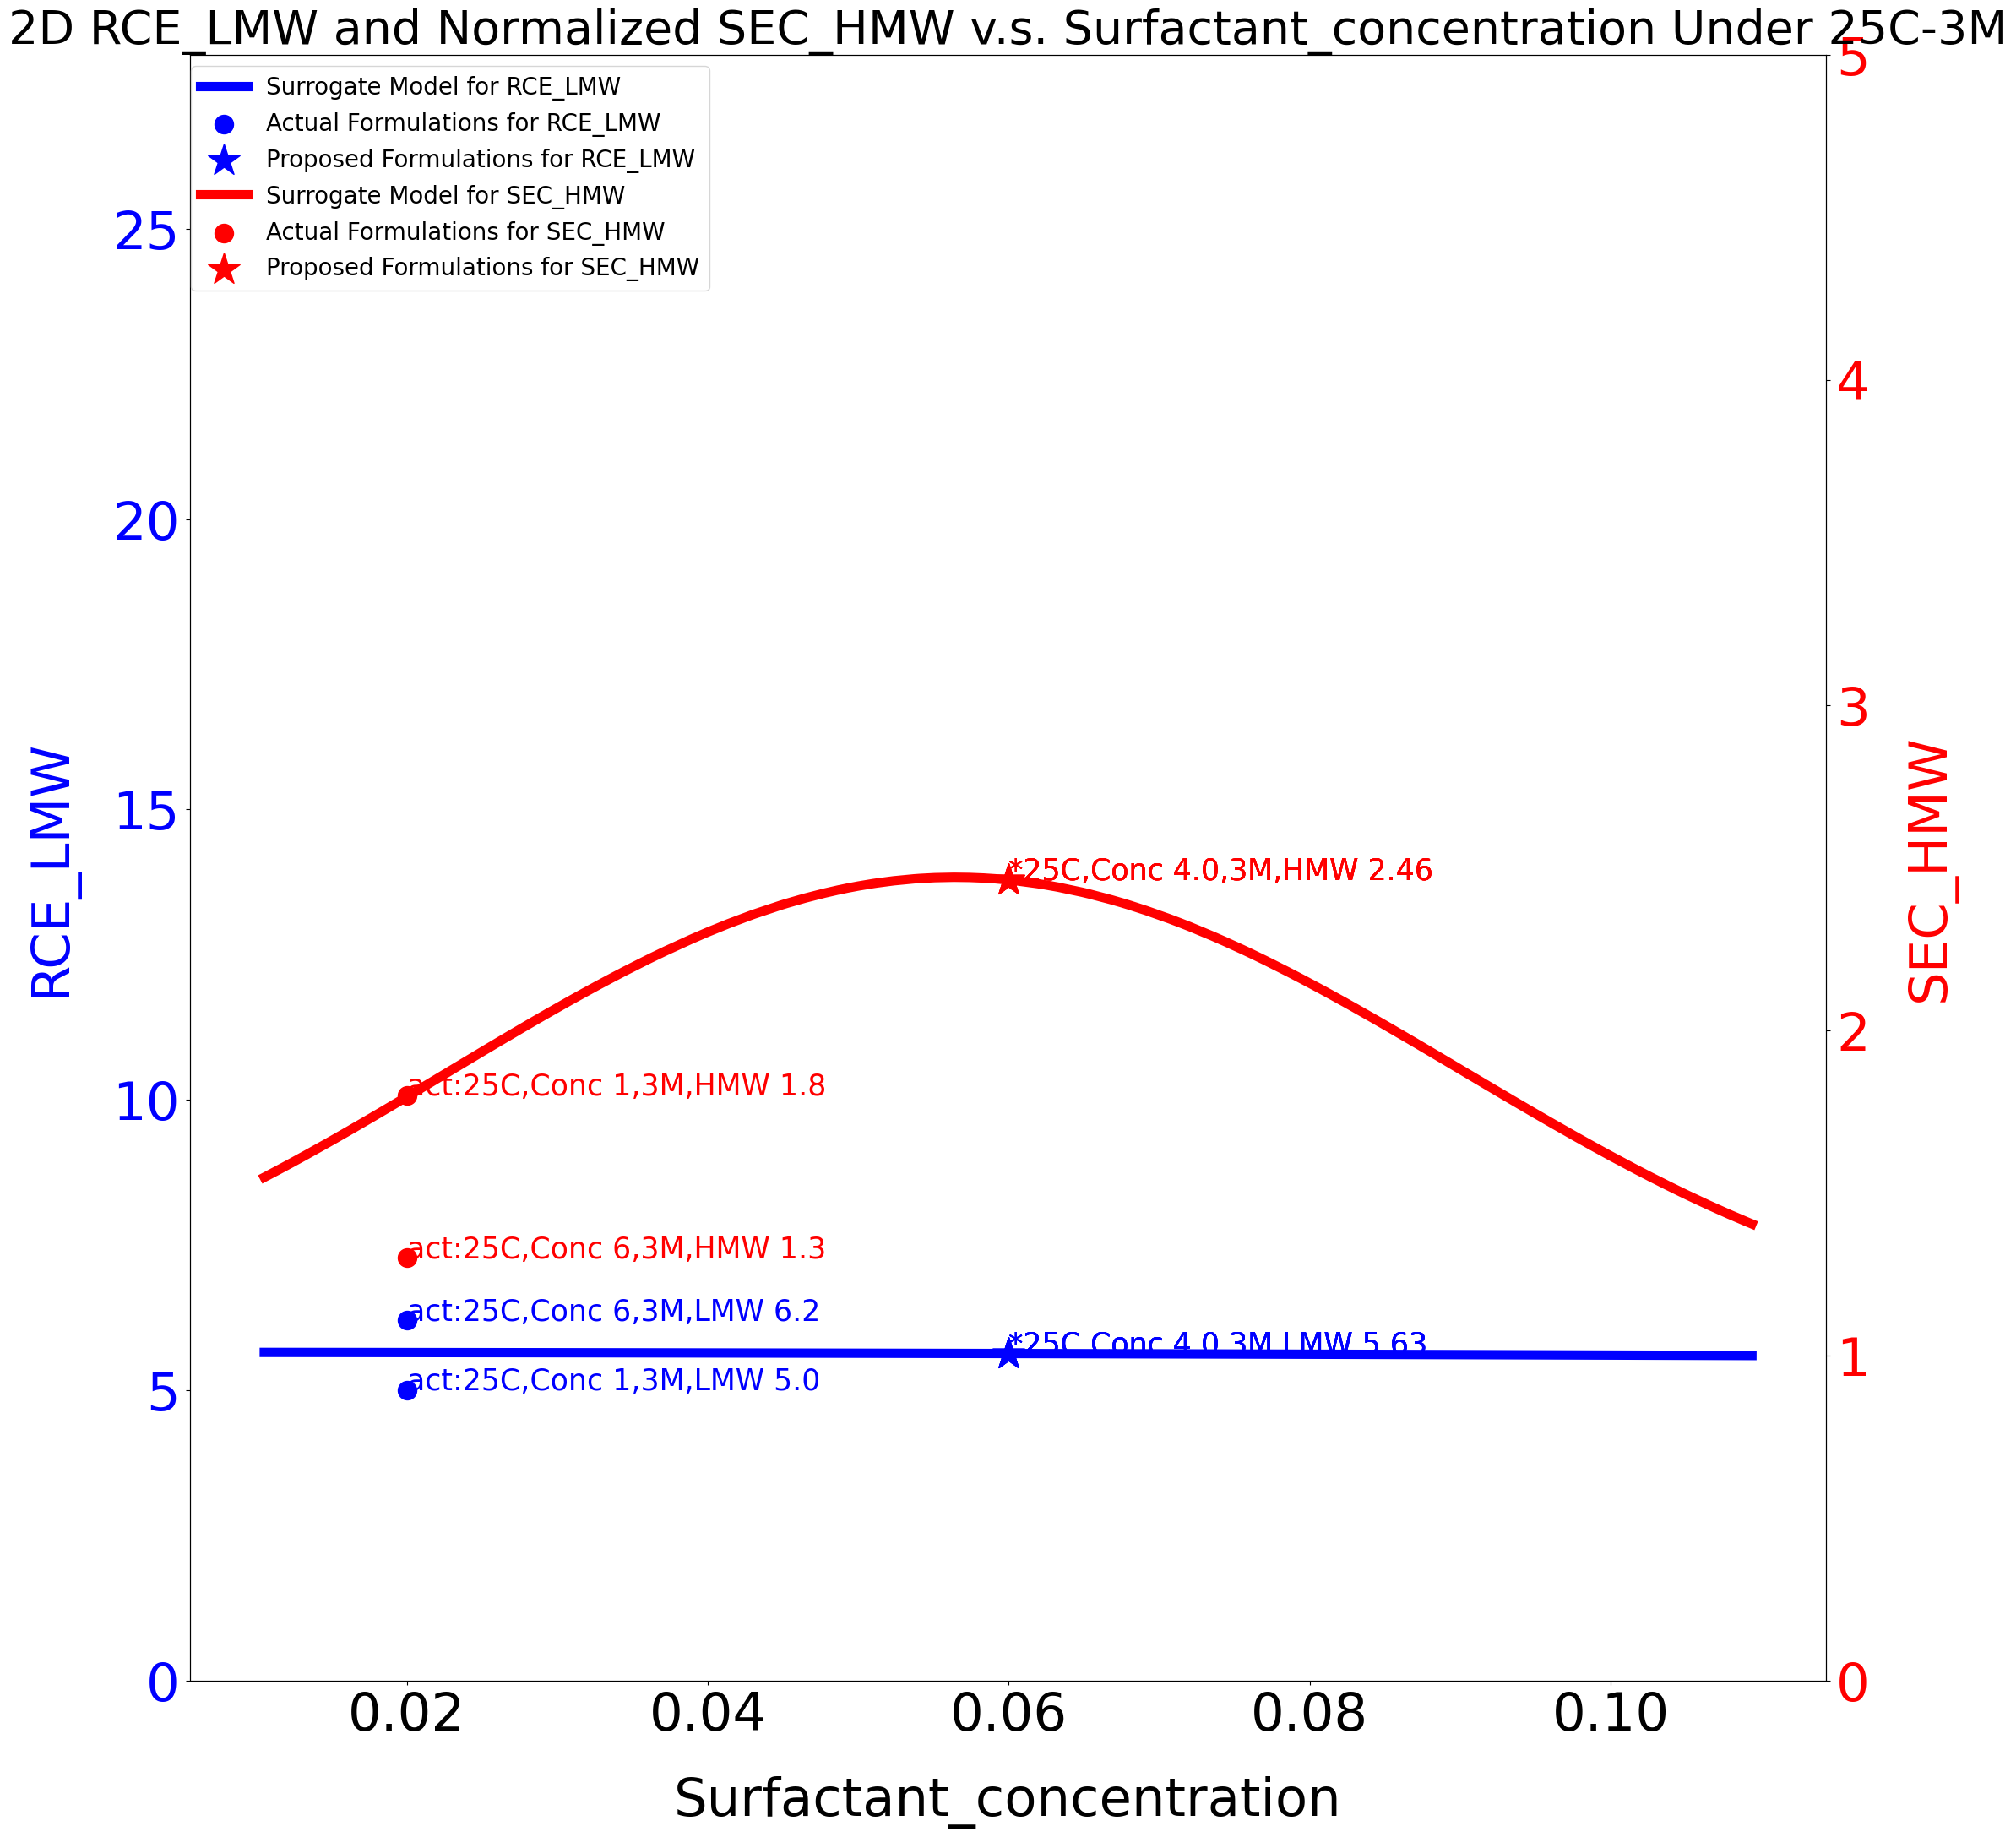

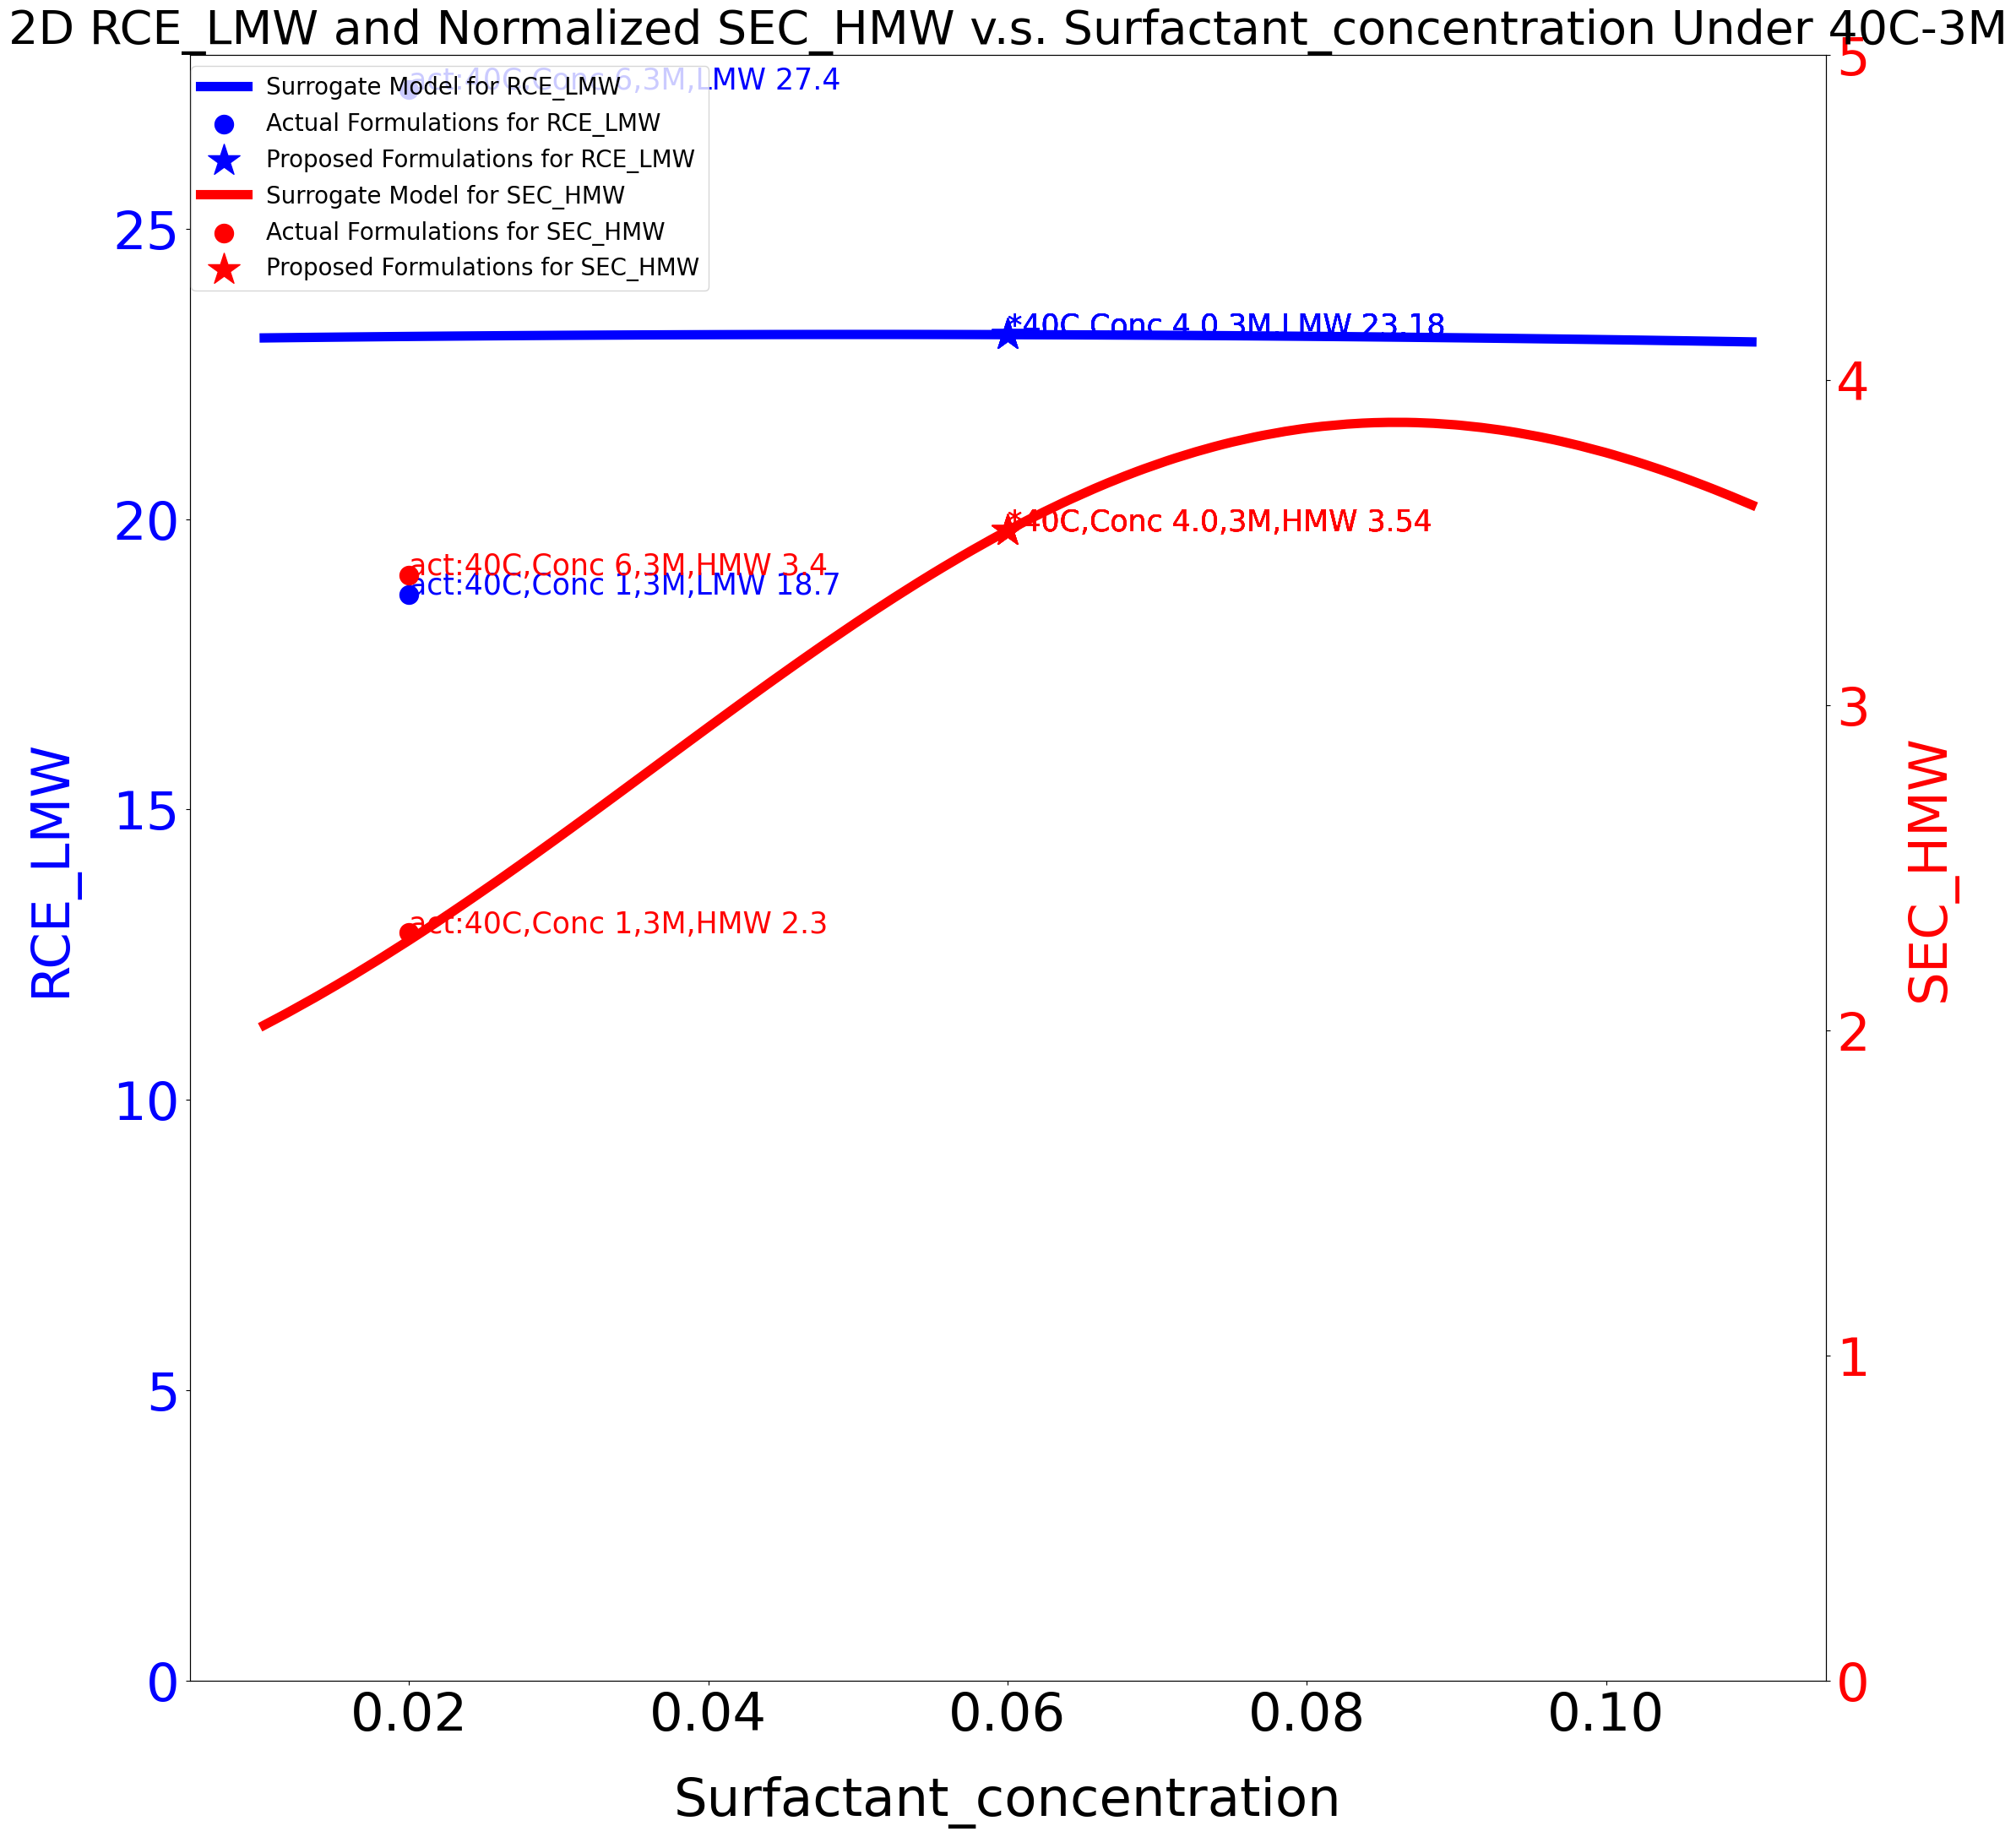

In [30]:
import matplotlib.ticker as plticker
tick_spacing = 0.02#0.5(pH)
is_normalize_hmw = True
if is_normalize_hmw:
        normalize_label = 'Normalized '
else:
        normalize_label =''

if col_x !='Time_M_':
        task_idx = 3

ls_y_min = [0,0]
ls_y_max = [28,5]

for temp_label_idx in range(len(temp_dict)):
#for temp_label_idx in range(2,3):

                print('===============temp'+temp_dict[temp_label_idx]+'==========:')

                
                sample = sampler_2d.random(n=n_sample)
                sample_scaled = qmc.scale(sample, l_bound, u_bound)
                df_X_syn_bt = pd.DataFrame(index = range(n_sample))
                if col_x != 'Time_M_':
                        df_X_syn_bt[col_x] = sample_scaled
                        df_X_syn_bt['Time_M_'] = df_X_train_bt.iloc[best_train_idx_bt,3]
                        if col_x =='pH':
                                df_X_syn_bt['Protein_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,0]#sample_scaled#df_X_train_bt.iloc[best_train_idx_bt,0] #4
                                df_X_syn_bt['Surfactant_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,1] #0.02
                        elif col_x == 'Protein_concentration':
                                df_X_syn_bt['pH'] = df_X_train_bt.iloc[best_train_idx_bt,5]#sample_scaled
                                df_X_syn_bt['Surfactant_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,1] #0.02
                        
                        elif col_x == 'Surfactant_concentration':
                                df_X_syn_bt['pH'] = df_X_train_bt.iloc[best_train_idx_bt,5]#sample_scaled
                                df_X_syn_bt['Protein_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,0]

                else:
                        df_X_syn_bt['Time_M_'] = sample_scaled
                        df_X_syn_bt['pH'] = PH_OPT#df_X_train_bt.iloc[best_train_idx_bt,5]#sample_scaled
                        df_X_syn_bt['Protein_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,0]#sample_scaled#df_X_train_bt.iloc[best_train_idx_bt,0] #4  
                        df_X_syn_bt['Surfactant_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,1] #0.02
                
                
                #df_X_syn_bt['Surfactant_concentration'] = df_X_train_bt.iloc[best_train_idx_bt,1] #0.02
                df_X_syn_bt['Temperature'] = temp_label_idx
                df_X_syn_bt['If_10mM_L_Met'] = L_Met_OPT
                
                #reorder df_X_syn_bt columns
                df_X_syn_bt = df_X_syn_bt[df_X_train_bt.columns]
            
                #add training to plot points
                df_X_syn_bt = pd.concat([df_X_train_bt,df_X_syn_bt],axis = 0)
                df_X_syn_bt.reset_index(inplace = True, drop= True)

                X = np.unique(df_X_syn_bt[col_x].sort_values())
                df_X_syn_bt_mesh = pd.DataFrame(columns=df_X_syn_bt.columns,index = range(X.shape[0]))
                
                if col_x != 'Time_M_':
                        df_X_syn_bt_mesh[col_x] = np.ravel(X)
                        df_X_syn_bt_mesh['Time_M_'] = task_idx
                        if col_x =='pH':
                                df_X_syn_bt_mesh['Protein_concentration'] = PROT_OPT#np.ravel(X)#4.0
                                df_X_syn_bt_mesh['Surfactant_concentration'] = SURF_OPT
                        elif col_x == 'Protein_concentration':
                                df_X_syn_bt_mesh['pH'] = PH_OPT#np.ravel(X)
                                df_X_syn_bt_mesh['Surfactant_concentration'] = SURF_OPT
                        elif col_x == 'Surfactant_concentration':
                                df_X_syn_bt_mesh['pH'] = PH_OPT#np.ravel(X)
                                df_X_syn_bt_mesh['Protein_concentration'] = PROT_OPT

                else:
                        df_X_syn_bt_mesh['Time_M_'] = np.ravel(X)
                        df_X_syn_bt_mesh['pH'] = PH_OPT#np.ravel(X)
                        df_X_syn_bt_mesh['Protein_concentration'] = PROT_OPT#np.ravel(X)#4.0
                        df_X_syn_bt_mesh['Surfactant_concentration'] = SURF_OPT
                
                
                #df_X_syn_bt_mesh['Surfactant_concentration'] = 0.02
                df_X_syn_bt_mesh['Temperature'] = temp_label_idx
                df_X_syn_bt_mesh['If_10mM_L_Met'] = L_Met_OPT
                

                df_X_syn_bt_mesh_copy1 = df_X_syn_bt_mesh.copy()
                df_X_syn_bt_mesh_copy2 = df_X_syn_bt_mesh.copy()
                df_X_syn_bt_mesh_copy1['Time_M_'] = 0
                df_X_syn_bt_mesh_copy1['Protein_concentration'] = 1
                df_X_syn_bt_mesh_copy2['Time_M_'] = 0

                scaled_X_syn=xct.transform(df_X_syn_bt_mesh)
                t_syn_x = torch.Tensor(scaled_X_syn)
                scaled_X_syn_copy1=xct.transform(df_X_syn_bt_mesh_copy1)
                t_syn_x_copy1 = torch.Tensor(scaled_X_syn_copy1)
                scaled_X_syn_copy2=xct.transform(df_X_syn_bt_mesh_copy2)
                t_syn_x_copy2 = torch.Tensor(scaled_X_syn_copy2)

                

                df_y_syn_bt =pd.DataFrame(index = range(len(df_X_syn_bt_mesh)),columns = cols_target)
                #df_y_syn_bt_copy1,df_y_syn_bt_copy2 =df_y_syn_bt.copy(),df_y_syn_bt.copy()

                recom_conds2 = (df_x['pH']==PH_OPT) & (df_x['If_10mM_L_Met'] == L_Met_OPT)&(df_x['Surfactant_concentration'] == SURF_CURRENT) & (df_x['Temperature'] == temp_label_idx)
                df_X_recom2 = df_x[recom_conds2]
                df_y_recom2 = df_y[recom_conds2]

                df_X_recom2_copy1,df_X_recom2_copy2 = df_X_recom2.copy(),df_X_recom2.copy()
                scaled_X_recom2_copy1=xct.transform(df_X_recom2_copy1)
                t_recom2_x_copy1 = torch.Tensor(scaled_X_recom2_copy1)
                scaled_X_recom2_copy2=xct.transform(df_X_recom2_copy2)
                t_recom2_x_copy2 = torch.Tensor(scaled_X_recom2_copy2)
                
                #update 'SEC_HMW' in df_y_recom2
                model_hmw = lls_models[1]
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                        recom2_pred_copy1 =  model_hmw(t_recom2_x_copy1)  
                        recom2_mean_copy1 = recom2_pred_copy1.mean
                        recom2_lower_copy1, recom2_upper_copy1 = recom2_pred_copy1.confidence_region()
                        recom2_pred_copy2 =  model_hmw(t_recom2_x_copy2)  
                        recom2_mean_copy2 = recom2_pred_copy2.mean
                        recom2_lower_copy2, recom2_upper_copy2 = recom2_pred_copy2.confidence_region()
                if is_normalize_hmw:
                        df_y_recom2['SEC_HMW'] = df_y_recom2['SEC_HMW'].values + recom2_mean_copy1.numpy() - recom2_mean_copy2.numpy()

                if col_x !='Time_M_':
                        act_conds_task = (df_X_recom2['Time_M_']==task_idx)
                        df_plot_act= df_X_recom2[act_conds_task]
                else:
                        df_plot_act= df_X_recom2
                xa = df_plot_act[col_x].values
                ya = df_plot_act['Protein_concentration'].values
                ta = df_plot_act['Time_M_'].values
                tempa = df_plot_act['Temperature'].values
                #recom_conds_task = (df_X_syn_bt_mesh['pH']==5.0) & (df_X_syn_bt_mesh['Protein_concentration']==4.0)&(df_X_syn_bt_mesh['Surfactant_concentration'] == 0.02)&(df_X_syn_bt_mesh['If_10mM_L_Met'] == 1.0) &(df_X_syn_bt_mesh['Protein_concentration'] == 4)
                #df_plot_recom = df_X_syn_bt_mesh[recom_conds_task]

                fig = plt.figure(figsize=(25, 25))
                ax0= plt.axes()
                ax1 = ax0.twinx()
                
                
                
                for plot_target_ind in range(len(cols_target)):
                        col_target= cols_target[plot_target_ind]
                        model = lls_models[plot_target_ind]
                        with torch.no_grad(), gpytorch.settings.fast_pred_var():
                                syn_pred = model(t_syn_x)  
                                syn_mean = syn_pred.mean
                                syn_lower, syn_upper = syn_pred.confidence_region()
                                if col_target == 'SEC_HMW':
                                        syn_pred_copy1 = model_hmw(t_syn_x_copy1)  
                                        syn_mean_copy1 = syn_pred_copy1.mean
                                        syn_lower_copy1, syn_upper_copy1 = syn_pred_copy1.confidence_region()
                                        syn_pred_copy2 =  model_hmw(t_syn_x_copy2)  
                                        syn_mean_copy2 = syn_pred_copy2.mean
                                        syn_lower_copy2, syn_upper_copy2 = syn_pred_copy2.confidence_region()
                
                        y_scaler = ls_y_scaler[plot_target_ind]
                        
                        arr_syn_mean = y_scaler.inverse_transform(syn_mean.reshape(-1,1))
                        arr_syn_lower = y_scaler.inverse_transform(syn_lower.reshape(-1,1))
                        arr_syn_upper = y_scaler.inverse_transform(syn_upper.reshape(-1,1))
                        
                        
                        if is_normalize_hmw and col_target == 'SEC_HMW':
                                arr_syn_mean_copy1 = y_scaler.inverse_transform(syn_mean_copy1.reshape(-1,1))
                                arr_syn_lower_copy1 = y_scaler.inverse_transform(syn_lower_copy1.reshape(-1,1))
                                arr_syn_upper_copy1 = y_scaler.inverse_transform(syn_upper_copy1.reshape(-1,1))

                                arr_syn_mean_copy2 = y_scaler.inverse_transform(syn_mean_copy2.reshape(-1,1))
                                arr_syn_lower_copy2 = y_scaler.inverse_transform(syn_lower_copy2.reshape(-1,1))
                                arr_syn_upper_copy2 = y_scaler.inverse_transform(syn_upper_copy2.reshape(-1,1))

                                arr_syn_mean = arr_syn_mean +  arr_syn_mean_copy1 -  arr_syn_mean_copy2
                                arr_syn_lower = arr_syn_lower +  arr_syn_lower_copy1 -  arr_syn_lower_copy2
                                arr_syn_upper = arr_syn_upper +  arr_syn_upper_copy1 -  arr_syn_upper_copy2
                        df_y_syn_bt[col_target] = arr_syn_mean
                

                        #calculate expected improvement
                        new_syn_mean =  (arr_syn_mean)*(-1)
                        y_std = np.mean(arr_syn_upper - arr_syn_mean,axis = 1).reshape(-1,1)
                        df_y_syn_bt[col_target+'_err'] = y_std
                        z = (new_syn_mean - new_train_mean[best_train_idx_bt])/y_std
                        ei = (new_syn_mean - new_train_mean[best_train_idx_bt])*norm.cdf(z) + y_std*norm.pdf(z)
                        df_y_syn_bt[col_target+'_ei'] = ei

                

                        print('==After simulation==')
                
                        best_syn_idx = np.argmax(new_syn_mean)
                        
                

                        df_y_syn_bt['lower'+str(plot_target_ind)] = (arr_syn_mean - df_y_syn_bt[col_target+'_ei'].values.reshape(-1,1))
                        df_y_syn_bt['upper'+str(plot_target_ind)] = (arr_syn_mean + df_y_syn_bt[col_target+'_ei'].values.reshape(-1,1))

                        #df_y_syn_bt['lower'+str(plot_target_ind)] = (arr_syn_mean - df_y_syn_bt[col_target+'_err'].values.reshape(-1,1))
                        #df_y_syn_bt['upper'+str(plot_target_ind)] = (arr_syn_mean + df_y_syn_bt[col_target+'_err'].values.reshape(-1,1))

                        #plot recommend formulations
                        if col_x == 'Surfactant_concentration':
                                recom_conds1 = (df_X_train['pH']==PH_OPT) & (df_X_train['Protein_concentration']==PROT_CURRENT)& (df_X_train['Temperature'] == temp_label_idx)
                                df_X_recom1 = df_X_train[recom_conds1]
                                df_X_recom1[col_x] = SURF_OPT
                                df_X_recom1['Protein_concentration'] = PROT_OPT
                        elif col_x == 'Protein_concentration':
                                #recom_conds1 = (df_X_train['pH']==PH_OPT) & (df_X_train['Protein_concentration']==PROT_CURRENT)&(df_X_train['Surfactant_concentration'] == SURF_CURRENT) & (df_X_train['Temperature'] == temp_label_idx)
                                recom_conds1 = (df_X_train['pH']==PH_OPT) &(df_X_train['Surfactant_concentration'] == SURF_CURRENT) & (df_X_train['Temperature'] == temp_label_idx)
                                df_X_recom1 = df_X_train[recom_conds1]
                                df_X_recom1[col_x] = PROT_OPT
                                df_X_recom1['Surfactant_concentration'] = SURF_OPT
                        elif col_x == 'pH':
                                recom_conds1 = (df_X_train['Surfactant_concentration'] == SURF_CURRENT) &(df_X_train['Surfactant_concentration'] == SURF_CURRENT)& (df_X_train['Temperature'] == temp_label_idx)
                                df_X_recom1 = df_X_train[recom_conds1]
                                df_X_recom1[col_x] = PH_OPT
                        #df_X_recom1 = df_X_train[recom_conds1]
                        
                        if col_x != 'Time_M_':
                                df_X_recom1['Time_M_'] = task_idx
                        df_X_recom1['If_10mM_L_Met'] = L_Met_OPT
                        df_y_recom1 = df_y_train[recom_conds1]

                        
                        if col_x == 'Time_M_':
                                df_X_recom1_row = df_X_recom1.iloc[[0]]
                                df_X_recom1_repeat = df_X_recom1_row.loc[df_X_recom1_row.index.repeat(n_time_level)]
                                df_X_recom1_repeat.reset_index(inplace = True, drop = True)
                                df_X_recom1_repeat['Time_M_'] = range(n_time_level)
                                df_plot_recom = df_X_recom1_repeat
                                df_X_recom1_repeat_copy1,df_X_recom1_repeat_copy2 = df_X_recom1_repeat.copy(),df_X_recom1_repeat.copy()
                                df_X_recom1_repeat_copy1['Protein_concentration'] = 1
                                df_X_recom1_repeat_copy1['Time_M_'] = 0
                                df_X_recom1_repeat_copy2['Time_M_'] = 0
                                scaled_X_recom=xct.transform(df_X_recom1_repeat)
                                scaled_X_recom_copy1=xct.transform(df_X_recom1_repeat_copy1)
                                scaled_X_recom_copy2=xct.transform(df_X_recom1_repeat_copy2)
                        else:
                                df_plot_recom = df_X_recom1
                                df_X_recom1_copy1,df_X_recom1_copy2 = df_X_recom1.copy(),df_X_recom1.copy()
                                df_X_recom1_copy1['Protein_concentration'] = 1
                                df_X_recom1_copy1['Time_M_'] = 0
                                df_X_recom1_copy2['Time_M_'] = 0
                                scaled_X_recom=xct.transform(df_X_recom1)
                                scaled_X_recom_copy1=xct.transform(df_X_recom1_copy1)
                                scaled_X_recom_copy2=xct.transform(df_X_recom1_copy2)
                        t_recom_x = torch.Tensor(scaled_X_recom) #exclude task_ind column
                        

                        with torch.no_grad(), gpytorch.settings.fast_pred_var():
                                recom_pred = model(t_recom_x)
                        recom_mean = recom_pred.mean
                        recom_lower, recom_upper = recom_pred.confidence_region()

                        arr_recom_mean = y_scaler.inverse_transform(recom_mean.reshape(-1,1))
                        arr_recom_lower = y_scaler.inverse_transform(recom_lower.reshape(-1,1))
                        arr_recom_upper = y_scaler.inverse_transform(recom_upper.reshape(-1,1)) 

                        if col_target == 'SEC_HMW':
                                t_recom_x_copy1 = torch.Tensor(scaled_X_recom_copy1)
                                t_recom_x_copy2 = torch.Tensor(scaled_X_recom_copy2)

                                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                                        recom_pred_copy1 =  model_hmw(t_recom_x_copy1)
                                        recom_pred_copy2 =  model_hmw(t_recom_x_copy2)
                                recom_mean_copy1 = recom_pred_copy1.mean
                                recom_mean_copy2 = recom_pred_copy2.mean
                                recom_lower_copy1, recom_upper_copy1 = recom_pred_copy1.confidence_region()
                                recom_lower_copy2, recom_upper_copy2 = recom_pred_copy2.confidence_region()

                                arr_recom_mean_copy1 = y_scaler.inverse_transform(recom_mean_copy1.reshape(-1,1))
                                arr_recom_lower_copy1 = y_scaler.inverse_transform(recom_lower_copy1.reshape(-1,1))
                                arr_recom_upper_copy1 = y_scaler.inverse_transform(recom_upper_copy1.reshape(-1,1)) 

                                arr_recom_mean_copy2 = y_scaler.inverse_transform(recom_mean_copy2.reshape(-1,1))
                                arr_recom_lower_copy2 = y_scaler.inverse_transform(recom_lower_copy2.reshape(-1,1))
                                arr_recom_upper_copy2 = y_scaler.inverse_transform(recom_upper_copy2.reshape(-1,1)) 

                                arr_recom_mean = arr_recom_mean + arr_recom_mean_copy1 - arr_recom_mean_copy2
                                arr_recom_lower = arr_recom_lower + arr_recom_lower_copy1 - arr_recom_lower_copy2
                                arr_recom_upper = arr_recom_upper + arr_recom_upper_copy1 - arr_recom_upper_copy2
                
                        

                        xr = df_plot_recom[col_x].values
                        yr = df_plot_recom['Protein_concentration'].values
                        tr = df_plot_recom['Time_M_'].values
                        tempr = df_plot_recom['Temperature'].values

                        
                        df_plot_recom['z'+str(plot_target_ind)] = arr_recom_mean

                        x = df_X_syn_bt_mesh[col_x]
                        r = df_y_syn_bt[col_target].values
                        y_l = df_y_syn_bt['lower'+str(plot_target_ind)].values
                        y_u = df_y_syn_bt['upper'+str(plot_target_ind)].values

                        if plot_target_ind == 0:
                                ax = ax0
                        else:
                                ax = ax1
                        # Plot the surrogate model
                        ax.plot(x, r, ls_colors[plot_target_ind],label = 'Surrogate Model for '+col_target,linewidth=8)
                        #if col_target == 'SEC_HMW':
                        #        ax.fill_between(x = x,y1 = y_l, y2 = y_u, color=ls_colors[plot_target_ind], alpha=.15)
                        if len(df_plot_act)>0:
                                df_plot_act['z'+str(plot_target_ind)] = df_y_recom2[col_target]
                                za = df_plot_act['z'+str(plot_target_ind)].values
                                #scatter_act =ax.scatter(xa-0.05, za,s = 250,c = ls_colors[plot_target_ind],label = 'Actual Formulations for ' + col_target)
                                scatter_act =ax.scatter(xa, za,s = 250,c = ls_colors[plot_target_ind],label = 'Actual Formulations for ' + col_target)
                                for i in range(len(df_plot_act)):
                                        scatter_label = 'act:'+temp_dict[tempa[i]]+ ',' + 'Conc '+str(round(ya[i],1))+ ','+ str(int(ta[i]))+ 'M'+',' + col_target[-3:]+' '+str(round(za[i],2))
                                        #ax.text(xa[i]-0.5, za[i]-0.2*np.power(ya[i],0.5), scatter_label,fontsize = 25,color = ls_colors[plot_target_ind])
                                        ax.text(xa[i], za[i], scatter_label,fontsize = 25,color = ls_colors[plot_target_ind])
                
                        zr = df_plot_recom['z'+str(plot_target_ind)].values
                        scatter_recom = ax.scatter(xr, zr,
                           s = 800,marker = '*',c = ls_colors[plot_target_ind],label = 'Proposed Formulations for '+ col_target)
                        
                        for i in range(len(df_plot_recom)):
                                scatter_label = '*'+temp_dict[tempr[i]]+ ',' + 'Conc '+str(round(yr[i],1))+ ','+str(int(tr[i]))+ 'M'+ ','+ col_target[-3:]+' '+ str(round(zr[i],2))
                                #ax.text(xr[i]+0.15, zr[i]+0.1, scatter_label,fontsize = 25,color=ls_colors[plot_target_ind])
                                ax.text(xr[i], zr[i], scatter_label,fontsize = 25,color=ls_colors[plot_target_ind])
                        
                        ax.set_ylabel(col_target,fontsize=45, labelpad=30,color=ls_colors[plot_target_ind])
                        ax.tick_params(axis='y', which='major', labelsize=45, pad=5, labelcolor=ls_colors[plot_target_ind])
                        ax.tick_params(axis='x', which='major', labelsize=45, pad=5)
                        ax.set_xlabel(col_x,fontsize=45, labelpad=30)
                        #ax.set_ylim(min(r.min(),za.min())*.95,max(r.max(),za.max())*1.05)
                        ax.set_ylim(ls_y_min[plot_target_ind],ls_y_max[plot_target_ind])
                        ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))

                ls_df_X_syn_bt.append(df_X_syn_bt)
                ls_df_y_syn_bt.append(df_y_syn_bt)

                
                
                if col_x != 'Time_M_':
                        str_title = '2D '+ cols_target[0] + ' and '+ normalize_label + cols_target[1] + ' v.s. '+ col_x +' Under '+  temp_dict[temp_label_idx]+ '-' + task_dict[task_idx]
                else:
                        str_title = '2D '+ cols_target[0] + ' and '+ normalize_label + cols_target[1] + ' v.s. '+ col_x +' Under '+  temp_dict[temp_label_idx]
                ax.set_title(str_title, fontsize = 40)

                if temp_label_idx != 0:
                        fig.legend(fontsize = 20,loc='upper left', bbox_to_anchor=(0.12, 0.88))
                else:
                        fig.legend(fontsize = 20,loc='upper left', bbox_to_anchor=(0.12, 0.70))
                
                #plt.show()
                file_name = '/'+str_title + '.png'
                plt.savefig(figPath+file_name,dpi=300)
                
df_X_syn = pd.concat(ls_df_X_syn_bt)
df_y_syn = pd.concat(ls_df_y_syn_bt)